In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import theseus as th
import copy
from cvae_utilities import *
import copy
import os
import wandb
# Plot with matplotlib
import matplotlib.pyplot as plt


class CVAEWithTrajectoryOptimization(nn.Module):
    def __init__(self, cfg):
        super(CVAEWithTrajectoryOptimization, self).__init__()
        state_dim = cfg.state_dim
        action_dim = cfg.action_dim
        latent_dim_state = cfg.latent_dim_state 
        latent_dim_action = cfg.latent_dim_action
        horizon_action_dim = cfg.horizon * action_dim
        posterior_dim = cfg.posterior_dim
        device = cfg.device
        self.state_encoder = StateEncoder(state_dim, latent_dim_state).to(device)
        self.action_encoder = ActionEncoder(action_dim, latent_dim_action).to(device)
        self.fusing_encoder = FusingEncoder(latent_dim_state, horizon_action_dim, posterior_dim).to(device)
        self.dynamics_function = DynamicsFunction(latent_dim_state, action_dim, posterior_dim).to(device)
        self.action_decoder = ActionDecoder(posterior_dim, latent_dim_state, horizon_action_dim).to(device)
        self.reward_decoder = RewardDecoder(latent_dim_state, action_dim, posterior_dim).to(device)
        self.posterior_dim = posterior_dim
        self.device = device
        self.cfg = cfg

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, zs, za):
        """
        Perform a forward pass through the model.
        Args:
            obs: Observation (raw img input), shape [batch_size, state_dim].
            state: State (latent state input), shape [batch_size, state_dim].
            action: Action (latent action input), shape [batch_size, horizon * action_dim].
        Returns:
            reconstructed_action: Reconstructed action, shape [batch_size, horizon, action_dim].
            z_mu: Mean of the posterior Gaussian, shape [batch_size, posterior_dim].
            z_logvar: Log-variance of the posterior Gaussian, shape [batch_size, posterior_dim].
            _zs: Predicted next latent state, shape [batch_size, state_dim].
        """
    
        # Encode state and action
        # zs = self.state_encoder(obs, state)
        # za = self.action_encoder(action)

        # Fuse state and action for posterior Gaussian
        z_mu, z_logvar = self.fusing_encoder(zs, za)

        # Sample from posterior Gaussian
        fused_latent = self.reparameterize(z_mu, z_logvar)

        reconstructed_action = self.action_decoder(fused_latent, zs)

        zs_seq = []
        for t in range(self.cfg.horizon):
            _zs, _zp = self.dynamics_function(zs, self.action_encoder(reconstructed_action[:,2*t:2*(t+1)]), fused_latent)
            zs = _zs
            zs_seq.append(zs)
            fused_latent = _zp
        
        zs_seq = torch.stack(zs_seq, dim=1)

        return reconstructed_action, z_mu, z_logvar, zs_seq
    
    def generate_action(self, zs, zp):
        """
        Generate an action based on the given observation.
        Args:
            obs: Observation (raw state input), shape [batch_size, state_dim].
            state: State (latent state input), shape [batch_size, state_dim].
            z: Latent variable z, shape [batch_size, posterior_dim].
        Returns:
            action: Generated action, shape [batch_size, action_dim].
        """

        # Decode action from latent state and z
        reconstructed_action = self.action_decoder(zp, zs)  # Reconstruct action

        _zs, _zp = self.dynamics_function(zs, self.action_encoder(reconstructed_action), zp)

        return reconstructed_action, _zs, _zp

    def save_pretrained(self, save_directory):
        """Save model weights and config to directory"""
        os.makedirs(save_directory, exist_ok=True)
        
        # Save model state dict
        model_path = os.path.join(save_directory, "model.pt")
        torch.save({
            'state_encoder': self.state_encoder.state_dict(),
            'action_encoder': self.action_encoder.state_dict(),
            'fusing_encoder': self.fusing_encoder.state_dict(),
            'dynamics_function': self.dynamics_function.state_dict(),
            'action_decoder': self.action_decoder.state_dict(),
            'reward_decoder': self.reward_decoder.state_dict(),
            'cfg': self.cfg
        }, model_path)

    def load_pretrained(self, load_directory):
        """Load model weights and config from directory"""
        model_path = os.path.join(load_directory, "model.pt")
        if not os.path.exists(model_path):
            raise ValueError(f"Model file not found at {model_path}")
            
        checkpoint = torch.load(model_path, map_location=self.device)
        
        # Load model weights
        self.state_encoder.load_state_dict(checkpoint['state_encoder'])
        self.action_encoder.load_state_dict(checkpoint['action_encoder'])
        self.fusing_encoder.load_state_dict(checkpoint['fusing_encoder'])
        self.dynamics_function.load_state_dict(checkpoint['dynamics_function'])
        self.action_decoder.load_state_dict(checkpoint['action_decoder'])
        self.reward_decoder.load_state_dict(checkpoint['reward_decoder'])
        
        # Load config
        self.cfg = checkpoint['cfg']

    def plan_with_theseus_update(self, obs, state, action, horizon, gamma, cfg, eval_mode=False):
        """
        Perform trajectory optimization using Theseus.
        Args:
            obs: Observation (raw state input).
            horizon: Planning horizon.
            gamma: Discount factor.
            model: The CVAE model containing dynamics and state encoders.
            cfg: Configuration object (for damping, step size, etc.).
            eval_mode: Whether to evaluate without gradients.
        """
        # Prepare initial observation
        batch_size = obs.shape[0]
        obs = obs[:,0,...].clone().detach().requires_grad_(True).to(self.device) # [bs, 3, 96, 96]
        state = state[:,0,...].clone().detach().requires_grad_(True).to(self.device)# [bs, 2]
        action = action.clone().detach().requires_grad_(True).to(self.device) # [bs, horizon * 2]
        horizon = int(min(horizon, cfg.horizon))  # Clip planning horizon

        # Initialize latent state and actions
          # Latent state
        # actions = torch.zeros(batch_size, horizon, cfg.action_dim, device=self.device, requires_grad=True)  # Initial actions

        # Precompute initial actions using policy (if available)
        pi_actions = torch.empty(batch_size, cfg.action_dim * horizon, device=self.device)
        expert_actions = torch.empty(batch_size, cfg.action_dim * horizon, device=self.device)

        zs = self.state_encoder(obs, state) # 【bs, 50]
        zs0 = zs.clone()

        zp = torch.randn(batch_size, self.posterior_dim, device=self.device)

        # for t in range(horizon):
        #     # pi_actions[:,t] = model.generate_action(obs, state, pz)
        #     if not eval_mode:
        #         za = self.action_encoder(action[:,2*t:2*(horizon+t)]) # [bs, 14]
        #         reconstructed_action, z_mu, z_logvar, (zs0, _) = self.forward(zs0, za) # [bs, 14]
        #         z_mus.append(z_mu)
        #         z_logvars.append(z_logvar)
        #     else:
        #         with torch.no_grad():
        #             reconstructed_action, zs0, zp = self.generate_action(zs0, zp)
        #     pi_actions[:,t] = reconstructed_action
        #     expert_actions[:,t] = action[:,2*t:2*(horizon+t)]


        if not eval_mode:
            za = self.action_encoder(action).view(batch_size, cfg.action_dim * horizon)
            reconstructed_action, z_mu, z_logvar, zs_seq = self.forward(zs0, za)
            pi_actions = reconstructed_action
        else:
            pass

        print(reconstructed_action.shape)
        # Define cost function
        def value_cost_fn(optim_vars, aux_vars):
            actions = optim_vars[0].tensor  # [bs, horizon * action_dim]

            obs = aux_vars[0].tensor
            state = aux_vars[1].tensor
            pz = aux_vars[2].tensor

            actions = actions.view(actions.shape[0],  horizon, cfg.action_dim)
            tmp = torch.where(
                torch.abs(actions) > 1,
                (torch.abs(actions) - 1)**2,
                torch.zeros_like(actions)
            )
            actions = torch.clamp(actions, -1, 1) 

            z = self.state_encoder(obs, state)  # Latent state
            total_reward = 0.0
            discount = 1.0
            # pz = torch.randn(batch_size, self.posterior_dim, device=self.device)
            # Compute cumulative reward
            for t in range(horizon):
                reward = self.reward_decoder(z, actions[:,t], pz)
                z, pz = self.dynamics_function(z, actions[:,t], pz)
                total_reward += discount * reward
                discount *= gamma

            err = -torch.nan_to_num(total_reward, nan=0.0) + 1e3 + torch.clamp(tmp.sum(axis=[1,2]), max=1e3).unsqueeze(1) * 10
            return err
        
        all_actions_var = []
        all_obs_var = []
        all_state_var = []
        all_zp = []

        for i in range(batch_size):
            actions_var = th.Vector(tensor = pi_actions[0].view(1, -1), name=f"actions_{i}")
            obs_var = th.Variable(obs[0].unsqueeze(0), name=f"obs_{i}")
            state_var = th.Variable(state[0].unsqueeze(0), name=f"state_{i}")
            posterior = th.Variable(zp[0].unsqueeze(0), name=f"posterior_{i}")
            all_actions_var.append(actions_var)
            all_obs_var.append(obs_var)
            all_state_var.append(state_var)
            all_zp.append(posterior)
        

        objective = th.Objective()
        for i in range(batch_size):
            cost_function = th.AutoDiffCostFunction(
                [all_actions_var[i]],
                value_cost_fn,
                dim=1,
                aux_vars=[all_obs_var[i], all_state_var[i], all_zp[i]],
                name=f"value_cost_fn_{i}",
            )
            objective.add(cost_function)
        optimizer = th.LevenbergMarquardt(
            objective,
            th.CholeskyDenseSolver,
            max_iterations=cfg.max_iterations,
            step_size=cfg.step_size,
        )
        theseus_layer = th.TheseusLayer(optimizer)
        theseus_layer.to(device=self.device)



        def construct_theseus_layer_inputs():
            theseus_inputs = {}
            for i in range(batch_size):
                theseus_inputs.update({
                    f"actions_{i}": pi_actions[i].view(1, -1),
                    f"obs_{i}": obs[i].unsqueeze(0), 
                    f"state_{i}": state[i].unsqueeze(0), 
                    f"posterior_{i}": zp[i].unsqueeze(0)})
            return theseus_inputs

        # Solve optimization problem
        theseus_input = construct_theseus_layer_inputs()
        updated_inputs, info = theseus_layer.forward(
            theseus_input,
            optimizer_kwargs={
                "track_best_solution": True,
                "damping": cfg.damping,
                "verbose": False,
                "backward_mode" : "implicit",
                "backward_num_iterations":10,
            },
        )

        batch_best_actions = []
        batch_updated_actions = []

        for i in range(batch_size):
            best_actions = info.best_solution[f"actions_{i}"].view(horizon, horizon * cfg.action_dim)
            updated_actions = updated_inputs[f"actions_{i}"].nan_to_num_(0).view(horizon, horizon * cfg.action_dim)
            batch_best_actions.append(best_actions)
            batch_updated_actions.append(updated_actions)

        batch_best_actions_tensor = torch.stack(batch_best_actions)
        batch_updated_actions_tensor = torch.stack(batch_updated_actions)

        if not eval_mode:
            # bc_loss = F.mse_loss(updated_actions[:,:1,:], expert_actions[:,:1,:])
            z_mus = torch.stack(z_mus, dim=1)
            z_logvars = torch.stack(z_logvars, dim=1)

            elbo_loss, recon_loss = compute_elbo_loss(batch_updated_actions_tensor[:,:,:6], expert_actions[:,:,:6], z_mus, z_logvars, cfg.beta)
            # bc_loss = F.mse_loss(batch_best_actions_tensor[:,:,:6], expert_actions[:,:,:6].cpu())
            output_dict = {
                "best_actions": batch_best_actions_tensor,
                "elbo_loss": elbo_loss,
                "recon_loss": recon_loss
            }
        else:
            bc_loss = F.mse_loss(batch_best_actions_tensor[:,:,:6], expert_actions[:,:,:6].cpu())
            output_dict = {
                "bc_loss": bc_loss,
                "best_actions": batch_best_actions_tensor,
            }
        return output_dict


In [19]:
# # Example Usage
class Config:
    def __init__(self):
        self.horizon = 7
        self.action_dim = 2
        # Theseus optimization parameters
        self.max_iterations = 50
        self.step_size = 1e-2
        self.damping = 1e-3
        self.min_std = 1e-4
        self.discount = 0.99
        self.state_dim = 512*3*3 + 2
        self.batch_size = 16
        self.latent_dim_state = 50
        self.latent_dim_action = self.action_dim
        self.posterior_dim = 64
        self.device = torch.device("mps")
        self.beta = 1.0
cfg = Config()
device = cfg.device

# Create CVAE model
model = CVAEWithTrajectoryOptimization(cfg)

# Example observation
obs = torch.randn(cfg.batch_size,1,3,96,96).to(device)
state = torch.randn(cfg.batch_size,1,2).to(device)
action = torch.randn(cfg.batch_size,7,2).to(device)
# obs = (obs, state)

# Perform trajectory optimization with Theseus
output_dict = model.plan_with_theseus_update(obs, state, action, horizon=cfg.horizon, gamma=cfg.discount, cfg=cfg, eval_mode=False)
# print("Optimized Actions:", optimized_actions)


torch.Size([16, 14])


/opt/anaconda3/envs/dl/lib/python3.11/site-packages/theseus/optimizer/nonlinear/nonlinear_least_squares.py:150: RuntimeWarning: There was an error while running the linear optimizer. Original error message: The operator 'aten::linalg_cholesky_ex.L' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS..
  warnings.warn(msg, RuntimeWarning)


RuntimeError: There was an error while running the linear optimizer. Original error message: The operator 'aten::linalg_cholesky_ex.L' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.. Backward pass will not work. To obtain the best solution seen before the error, run with torch.no_grad()

In [3]:
# Set up the the policy.
# Policies are initialized with a configuration class, in this case `DiffusionConfig`.
# For this example, no arguments need to be passed because the defaults are set up for PushT.
# If you're doing something different, you will likely need to change at least some of the defaults.

import wandb
import os
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
import torch
from torch.utils.data import random_split
import numpy as np
from lerobot.common.datasets.sampler import EpisodeAwareSampler
import tqdm
import gymnasium as gym
import gym_pusht

# Set PyTorch memory allocation config to avoid fragmentation
torch.cuda.set_per_process_memory_fraction(0.9)  # Limit max memory usage to 80%
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config_dict = {
        "horizon": 7,
        "action_dim": 2,
        "state_dim": 512*3*3 + 2,
        "batch_size": 64,  # Reduced batch size
        "latent_dim_state": 50,
        "latent_dim_action": 2,  # Same as action_dim
        "posterior_dim": 64,
        "beta": 10.0,
        "num_epochs": 100,
        "learning_rate": 3e-4,
        "max_iterations": 50,
        "step_size": 1e-4,
        "damping": 1e-3,
        "min_std": 1e-4,
        "discount": 0.9,
        "log_freq": 1,
        "eval_freq": 20,  # Evaluate every 100 steps
        "output_directory": "./output",
        "device": "cuda:0",
        "gradient_accumulation_steps": 1,  # Increased to compensate for smaller batch size
        "online_eval_episodes": 5,  # Number of episodes for online evaluation
    }

config = Config(config_dict)

# Initialize wandb first with all configuration parameters
wandb.init(
    project="difftop-training",
    config=config_dict,
    resume=True
)

device = torch.device("cuda")
policy = CVAEWithTrajectoryOptimization(config)

# Load previous checkpoint if exists
if os.path.exists(f"{wandb.config.output_directory}/best_model"):
    print("Loading previous checkpoint...")
    policy.load_pretrained(f"{wandb.config.output_directory}/best_model")

policy.train()
policy.to(device)

optimizer = torch.optim.Adam(policy.parameters(), lr=wandb.config.learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

# Set up the dataset
delta_timestamps = {
    "observation.image": [0.0],
    "observation.state": [0.0],
    "action": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3],
}

dataset = LeRobotDataset("lerobot/pusht_image", delta_timestamps=delta_timestamps)

episode_indices_to_use = np.arange(dataset.num_episodes)
test_episode_indices = np.random.choice(episode_indices_to_use, 10, replace=False)
train_episode_indices = np.setdiff1d(episode_indices_to_use, test_episode_indices)

train_sampler = EpisodeAwareSampler(dataset.episode_data_index, episode_indices_to_use=train_episode_indices, shuffle=True)
test_sampler = EpisodeAwareSampler(dataset.episode_data_index, episode_indices_to_use=test_episode_indices, shuffle=True)

train_dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=2,  # Reduced number of workers
    batch_size=wandb.config.batch_size,
    sampler=train_sampler,
    pin_memory=True,
    drop_last=True,
)

eval_dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=1,  # Reduced number of workers
    batch_size=wandb.config.batch_size,
    sampler=test_sampler,
    pin_memory=True,
    drop_last=True,
)

def evaluate(policy, eval_dataloader):
    torch.cuda.empty_cache()  # Clear cache before evaluation
    policy.eval()
    total_loss = 0
    num_batches = 0
    with torch.no_grad():
        for batch in tqdm.tqdm(eval_dataloader, desc="Evaluating"):
            batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
            obs = batch['observation.image']
            state = batch['observation.state']/512 * 2 - 1
            action = batch['action'].view(wandb.config.batch_size,-1)/512 * 2 - 1
            output_dict = policy.plan_with_theseus_update(obs, state, action, horizon=wandb.config.horizon, gamma=wandb.config.discount, cfg=wandb.config, eval_mode=True)
            total_loss += output_dict["bc_loss"].item()
            num_batches += 1
            if num_batches >= 5:  # Limit eval to 5 batches
                break
            del output_dict  # Explicitly delete to free memory
            torch.cuda.empty_cache()
    policy.train()
    return total_loss / num_batches

import collections
def online_evaluate(policy, num_episodes=5):
    """Evaluate policy in the actual environment"""
    policy.eval()
    env = gym.vector.make(
        "gym_pusht/PushT-v0",
        num_envs=num_episodes,
        obs_type="pixels_agent_pos",
        max_episode_steps=200,
    )

    env.seed(42)
    
    
    total_rewards = np.zeros(num_episodes)
    episode_lengths = np.zeros(num_episodes)
    last_rewards = np.zeros(num_episodes)
    
    batch_observations, _ = env.reset(seed=42)
    done = [False] * num_episodes
    
    pbar = tqdm.tqdm(total=200, desc="Online evaluation")  # Max episode steps
    
    # Action queues for each environment
    action_queues = [collections.deque() for _ in range(num_episodes)]
    
    while not all(done):
        actions = np.zeros((num_episodes, 2))
        
        for i in range(num_episodes):
            if not done[i]:
                if len(action_queues[i]) == 0:
                    # Prepare observation for the policy
                    state = torch.from_numpy(batch_observations["agent_pos"][i])
                    image = torch.from_numpy(batch_observations["pixels"][i])
                    
                    state = state.to(torch.float32)
                    image = image.to(torch.float32) / 255
                    image = image.permute(2, 0, 1)
                    
                    state = state.to(device, non_blocking=True)
                    image = image.to(device, non_blocking=True)
                    action = torch.randn(1,28).cuda()
                    
                    state = state.unsqueeze(0).unsqueeze(0)/512 * 2 - 1
                    obs = image.unsqueeze(0).unsqueeze(0)
                    
                    # Get next actions
                    with torch.inference_mode():
                        output_dict = policy.plan_with_theseus_update(obs, state, action, 7, wandb.config.discount, wandb.config, eval_mode=True)
                    
                    # Add actions to queue
                    actions_pred = output_dict['best_actions'][0].reshape(7,-1, 2)[:,0]
                    for act in actions_pred:
                        numpy_act = (act.cpu().numpy() + 1)/2 * 512
                        action_queues[i].append(numpy_act)
                
                # Get next action from queue
                actions[i] = action_queues[i].popleft()
        
        # Step environment
        batch_observations, rewards, terminated, truncated, _ = env.step(actions)
        
        # Update metrics
        for i in range(num_episodes):
            if not done[i]:
                total_rewards[i] += rewards[i]
                last_rewards[i] = rewards[i]
                episode_lengths[i] += 1
                done[i] = terminated[i] or truncated[i]
        
        pbar.update(1)
    
    pbar.close()
    policy.train()
    return last_rewards.mean(), episode_lengths.mean()

# Training loop by epoch
best_eval_loss = float('inf')
best_online_reward = float('-inf')
global_step = 0

for epoch in range(wandb.config.num_epochs):
    print(f"Epoch {epoch+1}/{wandb.config.num_epochs}")
    epoch_loss = 0
    num_batches = 0
    optimizer.zero_grad()

    for batch_idx, batch in enumerate(tqdm.tqdm(train_dataloader, desc=f"Epoch {epoch+1}")):
        torch.cuda.empty_cache()  # Clear cache before each batch
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        obs = batch['observation.image']
        assert (obs >= 0).all() and (obs <= 1).all(), "image should be normalized to [0,1]"
        state = batch['observation.state']/512 * 2 - 1
        action = batch['action'].view(wandb.config.batch_size,-1)/512 * 2 - 1
        
        output_dict = policy.plan_with_theseus_update(obs, state, action, horizon=wandb.config.horizon, gamma=wandb.config.discount, cfg=wandb.config)
        loss = output_dict["elbo_loss"] / wandb.config.gradient_accumulation_steps
        bc_loss = output_dict["recon_loss"] / wandb.config.gradient_accumulation_steps
        loss.backward()
        epoch_loss += loss.item() * wandb.config.gradient_accumulation_steps
        num_batches += 1

        # Free memory
        del output_dict
        torch.cuda.empty_cache()

        if (batch_idx + 1) % wandb.config.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
            if batch_idx % wandb.config.log_freq == 0:
                current_lr = scheduler.get_last_lr()[0]
                print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item():.3f}, LR: {current_lr:.6f}")
                wandb.log({
                    "train/batch_loss": loss.item(),
                    "train/bc_loss":bc_loss.item(),
                    "train/learning_rate": current_lr,
                    "train/batch": batch_idx + 1,
                    "train/global_step": global_step
                })

            # Evaluate every eval_freq steps
            if global_step % wandb.config.eval_freq == 0:
                # Offline evaluation
                eval_loss = evaluate(policy, eval_dataloader)
                print(f"Step {global_step} Eval Loss: {eval_loss:.3f}")
                
                # Online evaluation
                mean_reward, mean_length = online_evaluate(policy, num_episodes=wandb.config.online_eval_episodes)
                print(f"Online Eval - Mean Reward: {mean_reward:.3f}, Mean Episode Length: {mean_length:.1f}")
                
                wandb.log({
                    "eval/loss": eval_loss,
                    "eval/online_reward": mean_reward,
                    "eval/episode_length": mean_length,
                    "eval/global_step": global_step
                })

                # Save best model based on both metrics
                if eval_loss < best_eval_loss or mean_reward > best_online_reward:
                    best_eval_loss = min(eval_loss, best_eval_loss)
                    best_online_reward = max(mean_reward, best_online_reward)
                    policy.save_pretrained(f"{wandb.config.output_directory}/best_model")
                    wandb.log({
                        "eval/best_loss": best_eval_loss,
                        "eval/best_online_reward": best_online_reward,
                        "eval/best_step": global_step
                    })

            global_step += 1

    # End of epoch
    avg_epoch_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1} Average Loss: {avg_epoch_loss:.3f}")
    wandb.log({
        "train/epoch_loss": avg_epoch_loss,
        "train/epoch": epoch + 1
    })

# Save final policy checkpoint
policy.save_pretrained(wandb.config.output_directory)
wandb.finish()


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lawrence-rs-lin (lawrence-rs-lin-university-of-toronto). Use `wandb login --relogin` to force relogin


Epoch 1/100


Epoch 1:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 1, Batch 1, Loss: 15815.809, LR: 0.000271


Evaluating:  20%|██        | 4/20 [00:23<01:33,  5.87s/it]

Step 0 Eval Loss: 0.489



/home/lawrence/anaconda3/envs/lerobot/lib/python3.10/site-packages/gymnasium/vector/__init__.py:53: UserWarning: WARN: `gymnasium.vector.make(...)` is deprecated and will be replaced by `gymnasium.make_vec(...)` in v1.0
  gym.logger.warn(
Epoch 1:   0%|          | 1/380 [00:45<4:49:38, 45.85s/it]

Online Eval - Mean Reward: 0.016, Mean Episode Length: 200.0


Epoch 1:   1%|          | 2/380 [00:50<2:16:35, 21.68s/it]

Epoch 1, Batch 2, Loss: 25525.508, LR: 0.000197


Epoch 1:   1%|          | 3/380 [00:55<1:27:03, 13.86s/it]

Epoch 1, Batch 3, Loss: 2899.396, LR: 0.000104


Epoch 1:   1%|          | 4/380 [00:59<1:04:22, 10.27s/it]

Epoch 1, Batch 4, Loss: 637.242, LR: 0.000030


Epoch 1:   1%|▏         | 5/380 [01:04<51:56,  8.31s/it]  

Epoch 1, Batch 5, Loss: 348.011, LR: 0.000300


Epoch 1:   2%|▏         | 6/380 [01:09<44:38,  7.16s/it]

Epoch 1, Batch 6, Loss: 488.832, LR: 0.000293


Epoch 1:   2%|▏         | 7/380 [01:14<39:50,  6.41s/it]

Epoch 1, Batch 7, Loss: 1237.650, LR: 0.000271


Epoch 1:   2%|▏         | 8/380 [01:19<36:36,  5.90s/it]

Epoch 1, Batch 8, Loss: 478.472, LR: 0.000238


Epoch 1:   2%|▏         | 9/380 [01:24<34:21,  5.56s/it]

Epoch 1, Batch 9, Loss: 265.087, LR: 0.000197


Epoch 1:   3%|▎         | 10/380 [01:28<32:38,  5.29s/it]

Epoch 1, Batch 10, Loss: 137.802, LR: 0.000150


Epoch 1:   3%|▎         | 11/380 [01:33<31:40,  5.15s/it]

Epoch 1, Batch 11, Loss: 201.711, LR: 0.000104


Epoch 1:   3%|▎         | 12/380 [01:38<30:45,  5.01s/it]

Epoch 1, Batch 12, Loss: 220.597, LR: 0.000063


Epoch 1:   3%|▎         | 13/380 [01:43<29:59,  4.90s/it]

Epoch 1, Batch 13, Loss: 197.774, LR: 0.000030


Epoch 1:   4%|▎         | 14/380 [01:47<29:20,  4.81s/it]

Epoch 1, Batch 14, Loss: 225.916, LR: 0.000008


Epoch 1:   4%|▍         | 15/380 [01:52<29:01,  4.77s/it]

Epoch 1, Batch 15, Loss: 180.538, LR: 0.000300


Epoch 1:   4%|▍         | 16/380 [01:56<28:41,  4.73s/it]

Epoch 1, Batch 16, Loss: 217.913, LR: 0.000298


Epoch 1:   4%|▍         | 17/380 [02:01<28:23,  4.69s/it]

Epoch 1, Batch 17, Loss: 110.737, LR: 0.000293


Epoch 1:   5%|▍         | 18/380 [02:06<28:17,  4.69s/it]

Epoch 1, Batch 18, Loss: 329.707, LR: 0.000284


Epoch 1:   5%|▌         | 19/380 [02:11<28:23,  4.72s/it]

Epoch 1, Batch 19, Loss: 362.827, LR: 0.000271


Epoch 1:   5%|▌         | 20/380 [02:15<28:33,  4.76s/it]

Epoch 1, Batch 20, Loss: 259.560, LR: 0.000256
Epoch 1, Batch 21, Loss: 116.915, LR: 0.000238


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.95s/it]

Step 20 Eval Loss: 0.154



/home/lawrence/anaconda3/envs/lerobot/lib/python3.10/site-packages/gymnasium/vector/__init__.py:53: UserWarning: WARN: `gymnasium.vector.make(...)` is deprecated and will be replaced by `gymnasium.make_vec(...)` in v1.0
  gym.logger.warn(
Online evaluation: 100%|██████████| 200/200 [00:15<00:00, 12.51it/s]


Online Eval - Mean Reward: 0.018, Mean Episode Length: 200.0


Epoch 1:   6%|▌         | 22/380 [03:05<1:18:59, 13.24s/it]

Epoch 1, Batch 22, Loss: 76.408, LR: 0.000218


Epoch 1:   6%|▌         | 23/380 [03:10<1:03:36, 10.69s/it]

Epoch 1, Batch 23, Loss: 108.643, LR: 0.000197


Epoch 1:   6%|▋         | 24/380 [03:15<52:48,  8.90s/it]  

Epoch 1, Batch 24, Loss: 161.247, LR: 0.000174


Epoch 1:   7%|▋         | 25/380 [03:19<44:40,  7.55s/it]

Epoch 1, Batch 25, Loss: 159.031, LR: 0.000150


Epoch 1:   7%|▋         | 26/380 [03:24<39:30,  6.70s/it]

Epoch 1, Batch 26, Loss: 116.596, LR: 0.000127


Epoch 1:   7%|▋         | 27/380 [03:29<35:53,  6.10s/it]

Epoch 1, Batch 27, Loss: 89.070, LR: 0.000104


Epoch 1:   7%|▋         | 28/380 [03:33<32:43,  5.58s/it]

Epoch 1, Batch 28, Loss: 63.168, LR: 0.000083


Epoch 1:   8%|▊         | 29/380 [03:38<31:05,  5.31s/it]

Epoch 1, Batch 29, Loss: 54.585, LR: 0.000063


Epoch 1:   8%|▊         | 30/380 [03:42<30:02,  5.15s/it]

Epoch 1, Batch 30, Loss: 52.703, LR: 0.000045


Epoch 1:   8%|▊         | 31/380 [03:47<29:18,  5.04s/it]

Epoch 1, Batch 31, Loss: 52.557, LR: 0.000030


Epoch 1:   8%|▊         | 32/380 [03:52<29:20,  5.06s/it]

Epoch 1, Batch 32, Loss: 55.410, LR: 0.000017


Epoch 1:   9%|▊         | 33/380 [03:57<28:42,  4.96s/it]

Epoch 1, Batch 33, Loss: 54.091, LR: 0.000008


Epoch 1:   9%|▉         | 34/380 [04:02<28:20,  4.92s/it]

Epoch 1, Batch 34, Loss: 55.860, LR: 0.000003


Epoch 1:   9%|▉         | 35/380 [04:07<28:04,  4.88s/it]

Epoch 1, Batch 35, Loss: 54.858, LR: 0.000300


Epoch 1:   9%|▉         | 36/380 [04:12<28:01,  4.89s/it]

Epoch 1, Batch 36, Loss: 55.075, LR: 0.000300


Epoch 1:  10%|▉         | 37/380 [04:16<27:51,  4.87s/it]

Epoch 1, Batch 37, Loss: 44.346, LR: 0.000298


Epoch 1:  10%|█         | 38/380 [04:21<27:38,  4.85s/it]

Epoch 1, Batch 38, Loss: 40.662, LR: 0.000296


Epoch 1:  10%|█         | 39/380 [04:26<27:36,  4.86s/it]

Epoch 1, Batch 39, Loss: 42.177, LR: 0.000293


Epoch 1:  11%|█         | 40/380 [04:31<27:29,  4.85s/it]

Epoch 1, Batch 40, Loss: 43.042, LR: 0.000289
Epoch 1, Batch 41, Loss: 45.075, LR: 0.000284


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.95s/it]

Step 40 Eval Loss: 0.164



Epoch 1:  11%|█         | 41/380 [05:16<1:35:27, 16.89s/it]

Online Eval - Mean Reward: 0.015, Mean Episode Length: 200.0


Epoch 1:  11%|█         | 42/380 [05:21<1:14:40, 13.26s/it]

Epoch 1, Batch 42, Loss: 43.720, LR: 0.000278


Epoch 1:  11%|█▏        | 43/380 [05:25<1:00:05, 10.70s/it]

Epoch 1, Batch 43, Loss: 40.769, LR: 0.000271


Epoch 1:  12%|█▏        | 44/380 [05:30<49:27,  8.83s/it]  

Epoch 1, Batch 44, Loss: 36.726, LR: 0.000264


Epoch 1:  12%|█▏        | 45/380 [05:35<42:31,  7.62s/it]

Epoch 1, Batch 45, Loss: 36.565, LR: 0.000256


Epoch 1:  12%|█▏        | 46/380 [05:39<37:47,  6.79s/it]

Epoch 1, Batch 46, Loss: 38.016, LR: 0.000248


Epoch 1:  12%|█▏        | 47/380 [05:44<34:24,  6.20s/it]

Epoch 1, Batch 47, Loss: 35.448, LR: 0.000238


Epoch 1:  13%|█▎        | 48/380 [05:49<32:00,  5.78s/it]

Epoch 1, Batch 48, Loss: 33.900, LR: 0.000229


Epoch 1:  13%|█▎        | 49/380 [05:54<30:15,  5.49s/it]

Epoch 1, Batch 49, Loss: 32.732, LR: 0.000218


Epoch 1:  13%|█▎        | 50/380 [05:59<29:03,  5.28s/it]

Epoch 1, Batch 50, Loss: 31.095, LR: 0.000208


Epoch 1:  13%|█▎        | 51/380 [06:04<28:12,  5.14s/it]

Epoch 1, Batch 51, Loss: 29.921, LR: 0.000197


Epoch 1:  14%|█▎        | 52/380 [06:08<27:32,  5.04s/it]

Epoch 1, Batch 52, Loss: 29.442, LR: 0.000185


Epoch 1:  14%|█▍        | 53/380 [06:13<27:04,  4.97s/it]

Epoch 1, Batch 53, Loss: 27.675, LR: 0.000174


Epoch 1:  14%|█▍        | 54/380 [06:18<26:42,  4.92s/it]

Epoch 1, Batch 54, Loss: 26.981, LR: 0.000162


Epoch 1:  14%|█▍        | 55/380 [06:23<26:25,  4.88s/it]

Epoch 1, Batch 55, Loss: 26.290, LR: 0.000150


Epoch 1:  15%|█▍        | 56/380 [06:28<26:17,  4.87s/it]

Epoch 1, Batch 56, Loss: 25.833, LR: 0.000139


Epoch 1:  15%|█▌        | 57/380 [06:32<26:11,  4.87s/it]

Epoch 1, Batch 57, Loss: 25.303, LR: 0.000127


Epoch 1:  15%|█▌        | 58/380 [06:37<26:01,  4.85s/it]

Epoch 1, Batch 58, Loss: 24.234, LR: 0.000116


Epoch 1:  16%|█▌        | 59/380 [06:42<25:57,  4.85s/it]

Epoch 1, Batch 59, Loss: 25.438, LR: 0.000104


Epoch 1:  16%|█▌        | 60/380 [06:47<25:39,  4.81s/it]

Epoch 1, Batch 60, Loss: 24.602, LR: 0.000093
Epoch 1, Batch 61, Loss: 23.873, LR: 0.000083


Evaluating:  20%|██        | 4/20 [00:24<01:36,  6.00s/it]

Step 60 Eval Loss: 0.165



Epoch 1:  16%|█▌        | 61/380 [07:32<1:29:36, 16.85s/it]

Online Eval - Mean Reward: 0.012, Mean Episode Length: 200.0


Epoch 1:  16%|█▋        | 62/380 [07:37<1:10:09, 13.24s/it]

Epoch 1, Batch 62, Loss: 24.056, LR: 0.000072


Epoch 1:  17%|█▋        | 63/380 [07:41<56:37, 10.72s/it]  

Epoch 1, Batch 63, Loss: 22.159, LR: 0.000063


Epoch 1:  17%|█▋        | 64/380 [07:46<47:04,  8.94s/it]

Epoch 1, Batch 64, Loss: 22.807, LR: 0.000053


Epoch 1:  17%|█▋        | 65/380 [07:51<40:22,  7.69s/it]

Epoch 1, Batch 65, Loss: 23.080, LR: 0.000045


Epoch 1:  17%|█▋        | 66/380 [07:56<35:42,  6.82s/it]

Epoch 1, Batch 66, Loss: 22.221, LR: 0.000037


Epoch 1:  18%|█▊        | 67/380 [08:01<32:24,  6.21s/it]

Epoch 1, Batch 67, Loss: 21.805, LR: 0.000030


Epoch 1:  18%|█▊        | 68/380 [08:05<30:04,  5.78s/it]

Epoch 1, Batch 68, Loss: 22.774, LR: 0.000023


Epoch 1:  18%|█▊        | 69/380 [08:11<29:14,  5.64s/it]

Epoch 1, Batch 69, Loss: 21.908, LR: 0.000017


Epoch 1:  18%|█▊        | 70/380 [08:16<28:11,  5.46s/it]

Epoch 1, Batch 70, Loss: 21.881, LR: 0.000012


Epoch 1:  19%|█▊        | 71/380 [08:21<27:15,  5.29s/it]

Epoch 1, Batch 71, Loss: 22.284, LR: 0.000008


Epoch 1:  19%|█▉        | 72/380 [08:26<26:49,  5.22s/it]

Epoch 1, Batch 72, Loss: 21.756, LR: 0.000005


Epoch 1:  19%|█▉        | 73/380 [08:31<26:16,  5.14s/it]

Epoch 1, Batch 73, Loss: 22.298, LR: 0.000003


Epoch 1:  19%|█▉        | 74/380 [08:35<25:51,  5.07s/it]

Epoch 1, Batch 74, Loss: 21.129, LR: 0.000001


Epoch 1:  20%|█▉        | 75/380 [08:40<25:27,  5.01s/it]

Epoch 1, Batch 75, Loss: 21.814, LR: 0.000300


Epoch 1:  20%|██        | 76/380 [08:45<24:28,  4.83s/it]

Epoch 1, Batch 76, Loss: 21.712, LR: 0.000300


Epoch 1:  20%|██        | 77/380 [08:50<24:16,  4.81s/it]

Epoch 1, Batch 77, Loss: 21.837, LR: 0.000300


Epoch 1:  21%|██        | 78/380 [08:54<24:20,  4.83s/it]

Epoch 1, Batch 78, Loss: 21.897, LR: 0.000299


Epoch 1:  21%|██        | 79/380 [08:59<24:15,  4.83s/it]

Epoch 1, Batch 79, Loss: 22.462, LR: 0.000298


Epoch 1:  21%|██        | 80/380 [09:04<24:13,  4.84s/it]

Epoch 1, Batch 80, Loss: 20.735, LR: 0.000297
Epoch 1, Batch 81, Loss: 19.781, LR: 0.000296


Evaluating:  20%|██        | 4/20 [00:24<01:36,  6.00s/it]

Step 80 Eval Loss: 0.180



Epoch 1:  21%|██▏       | 81/380 [09:49<1:24:41, 16.99s/it]

Online Eval - Mean Reward: 0.011, Mean Episode Length: 200.0


Epoch 1:  22%|██▏       | 82/380 [09:54<1:05:49, 13.25s/it]

Epoch 1, Batch 82, Loss: 20.084, LR: 0.000294


Epoch 1:  22%|██▏       | 83/380 [09:58<52:33, 10.62s/it]  

Epoch 1, Batch 83, Loss: 19.650, LR: 0.000293


Epoch 1:  22%|██▏       | 84/380 [10:03<43:17,  8.78s/it]

Epoch 1, Batch 84, Loss: 19.042, LR: 0.000291


Epoch 1:  22%|██▏       | 85/380 [10:07<36:48,  7.49s/it]

Epoch 1, Batch 85, Loss: 18.762, LR: 0.000289


Epoch 1:  23%|██▎       | 86/380 [10:12<32:14,  6.58s/it]

Epoch 1, Batch 86, Loss: 18.064, LR: 0.000286


Epoch 1:  23%|██▎       | 87/380 [10:16<29:05,  5.96s/it]

Epoch 1, Batch 87, Loss: 17.886, LR: 0.000284


Epoch 1:  23%|██▎       | 88/380 [10:21<26:54,  5.53s/it]

Epoch 1, Batch 88, Loss: 17.721, LR: 0.000281


Epoch 1:  23%|██▎       | 89/380 [10:25<25:26,  5.24s/it]

Epoch 1, Batch 89, Loss: 17.912, LR: 0.000278


Epoch 1:  24%|██▎       | 90/380 [10:30<24:22,  5.04s/it]

Epoch 1, Batch 90, Loss: 15.963, LR: 0.000275


Epoch 1:  24%|██▍       | 91/380 [10:35<23:47,  4.94s/it]

Epoch 1, Batch 91, Loss: 17.028, LR: 0.000271


Epoch 1:  24%|██▍       | 92/380 [10:39<23:08,  4.82s/it]

Epoch 1, Batch 92, Loss: 16.721, LR: 0.000268


Epoch 1:  24%|██▍       | 93/380 [10:44<22:35,  4.72s/it]

Epoch 1, Batch 93, Loss: 15.873, LR: 0.000264


Epoch 1:  25%|██▍       | 94/380 [10:49<22:39,  4.75s/it]

Epoch 1, Batch 94, Loss: 15.041, LR: 0.000260


Epoch 1:  25%|██▌       | 95/380 [10:53<22:29,  4.73s/it]

Epoch 1, Batch 95, Loss: 14.383, LR: 0.000256


Epoch 1:  25%|██▌       | 96/380 [10:58<22:28,  4.75s/it]

Epoch 1, Batch 96, Loss: 14.862, LR: 0.000252


Epoch 1:  26%|██▌       | 97/380 [11:03<22:33,  4.78s/it]

Epoch 1, Batch 97, Loss: 15.388, LR: 0.000248


Epoch 1:  26%|██▌       | 98/380 [11:08<22:32,  4.80s/it]

Epoch 1, Batch 98, Loss: 14.032, LR: 0.000243


Epoch 1:  26%|██▌       | 99/380 [11:13<22:26,  4.79s/it]

Epoch 1, Batch 99, Loss: 14.001, LR: 0.000238


Epoch 1:  26%|██▋       | 100/380 [11:17<22:29,  4.82s/it]

Epoch 1, Batch 100, Loss: 13.878, LR: 0.000234
Epoch 1, Batch 101, Loss: 13.719, LR: 0.000229


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.93s/it]

Step 100 Eval Loss: 0.224



Epoch 1:  27%|██▋       | 101/380 [12:02<1:18:30, 16.88s/it]

Online Eval - Mean Reward: 0.008, Mean Episode Length: 200.0


Epoch 1:  27%|██▋       | 102/380 [12:07<1:01:27, 13.27s/it]

Epoch 1, Batch 102, Loss: 13.375, LR: 0.000224


Epoch 1:  27%|██▋       | 103/380 [12:12<49:29, 10.72s/it]  

Epoch 1, Batch 103, Loss: 13.926, LR: 0.000218


Epoch 1:  27%|██▋       | 104/380 [12:17<41:07,  8.94s/it]

Epoch 1, Batch 104, Loss: 13.426, LR: 0.000213


Epoch 1:  28%|██▊       | 105/380 [12:22<35:22,  7.72s/it]

Epoch 1, Batch 105, Loss: 13.048, LR: 0.000208


Epoch 1:  28%|██▊       | 106/380 [12:27<31:18,  6.86s/it]

Epoch 1, Batch 106, Loss: 13.194, LR: 0.000202


Epoch 1:  28%|██▊       | 107/380 [12:31<28:31,  6.27s/it]

Epoch 1, Batch 107, Loss: 12.536, LR: 0.000197


Epoch 1:  28%|██▊       | 108/380 [12:37<26:54,  5.93s/it]

Epoch 1, Batch 108, Loss: 12.308, LR: 0.000191


Epoch 1:  29%|██▊       | 109/380 [12:42<26:40,  5.91s/it]

Epoch 1, Batch 109, Loss: 12.845, LR: 0.000185


Epoch 1:  29%|██▉       | 110/380 [12:47<25:13,  5.61s/it]

Epoch 1, Batch 110, Loss: 12.033, LR: 0.000180


Epoch 1:  29%|██▉       | 111/380 [12:53<24:27,  5.46s/it]

Epoch 1, Batch 111, Loss: 12.053, LR: 0.000174


Epoch 1:  29%|██▉       | 112/380 [12:58<23:59,  5.37s/it]

Epoch 1, Batch 112, Loss: 11.593, LR: 0.000168


Epoch 1:  30%|██▉       | 113/380 [13:03<23:38,  5.31s/it]

Epoch 1, Batch 113, Loss: 11.994, LR: 0.000162


Epoch 1:  30%|███       | 114/380 [13:08<23:11,  5.23s/it]

Epoch 1, Batch 114, Loss: 12.255, LR: 0.000156


Epoch 1:  30%|███       | 115/380 [13:13<23:03,  5.22s/it]

Epoch 1, Batch 115, Loss: 11.117, LR: 0.000150


Epoch 1:  31%|███       | 116/380 [13:18<22:56,  5.21s/it]

Epoch 1, Batch 116, Loss: 11.897, LR: 0.000145


Epoch 1:  31%|███       | 117/380 [13:23<22:46,  5.20s/it]

Epoch 1, Batch 117, Loss: 11.501, LR: 0.000139


Epoch 1:  31%|███       | 118/380 [13:29<22:42,  5.20s/it]

Epoch 1, Batch 118, Loss: 11.443, LR: 0.000133


Epoch 1:  31%|███▏      | 119/380 [13:34<22:22,  5.14s/it]

Epoch 1, Batch 119, Loss: 11.751, LR: 0.000127


Epoch 1:  32%|███▏      | 120/380 [13:38<21:51,  5.04s/it]

Epoch 1, Batch 120, Loss: 10.921, LR: 0.000121
Epoch 1, Batch 121, Loss: 11.021, LR: 0.000116


Evaluating:  20%|██        | 4/20 [00:25<01:41,  6.33s/it]

Step 120 Eval Loss: 0.224



Epoch 1:  32%|███▏      | 121/380 [14:26<1:17:23, 17.93s/it]

Online Eval - Mean Reward: 0.014, Mean Episode Length: 200.0


Epoch 1:  32%|███▏      | 122/380 [14:31<1:00:19, 14.03s/it]

Epoch 1, Batch 122, Loss: 10.767, LR: 0.000110


Epoch 1:  32%|███▏      | 123/380 [14:36<48:28, 11.32s/it]  

Epoch 1, Batch 123, Loss: 10.825, LR: 0.000104


Epoch 1:  33%|███▎      | 124/380 [14:41<39:55,  9.36s/it]

Epoch 1, Batch 124, Loss: 10.666, LR: 0.000099


Epoch 1:  33%|███▎      | 125/380 [14:46<34:16,  8.07s/it]

Epoch 1, Batch 125, Loss: 11.237, LR: 0.000093


Epoch 1:  33%|███▎      | 126/380 [14:51<30:03,  7.10s/it]

Epoch 1, Batch 126, Loss: 11.529, LR: 0.000088


Epoch 1:  33%|███▎      | 127/380 [14:56<27:09,  6.44s/it]

Epoch 1, Batch 127, Loss: 10.672, LR: 0.000083


Epoch 1:  34%|███▎      | 128/380 [15:01<25:10,  5.99s/it]

Epoch 1, Batch 128, Loss: 10.249, LR: 0.000077


Epoch 1:  34%|███▍      | 129/380 [15:06<23:50,  5.70s/it]

Epoch 1, Batch 129, Loss: 10.457, LR: 0.000072


Epoch 1:  34%|███▍      | 130/380 [15:11<22:49,  5.48s/it]

Epoch 1, Batch 130, Loss: 10.522, LR: 0.000067


Epoch 1:  34%|███▍      | 131/380 [15:16<21:58,  5.29s/it]

Epoch 1, Batch 131, Loss: 10.502, LR: 0.000063


Epoch 1:  35%|███▍      | 132/380 [15:20<20:52,  5.05s/it]

Epoch 1, Batch 132, Loss: 10.480, LR: 0.000058


Epoch 1:  35%|███▌      | 133/380 [15:25<20:03,  4.87s/it]

Epoch 1, Batch 133, Loss: 10.217, LR: 0.000053


Epoch 1:  35%|███▌      | 134/380 [15:29<19:29,  4.75s/it]

Epoch 1, Batch 134, Loss: 9.864, LR: 0.000049


Epoch 1:  36%|███▌      | 135/380 [15:34<19:04,  4.67s/it]

Epoch 1, Batch 135, Loss: 10.477, LR: 0.000045


Epoch 1:  36%|███▌      | 136/380 [15:38<18:44,  4.61s/it]

Epoch 1, Batch 136, Loss: 9.545, LR: 0.000041


Epoch 1:  36%|███▌      | 137/380 [15:43<18:27,  4.56s/it]

Epoch 1, Batch 137, Loss: 9.909, LR: 0.000037


Epoch 1:  36%|███▋      | 138/380 [15:47<18:13,  4.52s/it]

Epoch 1, Batch 138, Loss: 10.072, LR: 0.000033


Epoch 1:  37%|███▋      | 139/380 [15:51<18:03,  4.50s/it]

Epoch 1, Batch 139, Loss: 10.527, LR: 0.000030


Epoch 1:  37%|███▋      | 140/380 [15:56<17:53,  4.47s/it]

Epoch 1, Batch 140, Loss: 9.946, LR: 0.000026
Epoch 1, Batch 141, Loss: 9.239, LR: 0.000023


Evaluating:  20%|██        | 4/20 [00:22<01:29,  5.57s/it]

Step 140 Eval Loss: 0.234



Epoch 1:  37%|███▋      | 141/380 [16:38<1:03:17, 15.89s/it]

Online Eval - Mean Reward: 0.011, Mean Episode Length: 200.0


Epoch 1:  37%|███▋      | 142/380 [16:43<49:26, 12.47s/it]  

Epoch 1, Batch 142, Loss: 10.045, LR: 0.000020


Epoch 1:  38%|███▊      | 143/380 [16:47<39:44, 10.06s/it]

Epoch 1, Batch 143, Loss: 10.774, LR: 0.000017


Epoch 1:  38%|███▊      | 144/380 [16:52<32:58,  8.38s/it]

Epoch 1, Batch 144, Loss: 10.016, LR: 0.000015


Epoch 1:  38%|███▊      | 145/380 [16:56<28:12,  7.20s/it]

Epoch 1, Batch 145, Loss: 10.162, LR: 0.000012


Epoch 1:  38%|███▊      | 146/380 [17:01<24:53,  6.38s/it]

Epoch 1, Batch 146, Loss: 10.268, LR: 0.000010


Epoch 1:  39%|███▊      | 147/380 [17:05<22:35,  5.82s/it]

Epoch 1, Batch 147, Loss: 9.452, LR: 0.000008


Epoch 1:  39%|███▉      | 148/380 [17:10<20:54,  5.41s/it]

Epoch 1, Batch 148, Loss: 9.743, LR: 0.000007


Epoch 1:  39%|███▉      | 149/380 [17:14<19:49,  5.15s/it]

Epoch 1, Batch 149, Loss: 10.300, LR: 0.000005


Epoch 1:  39%|███▉      | 150/380 [17:19<18:54,  4.93s/it]

Epoch 1, Batch 150, Loss: 10.198, LR: 0.000004


Epoch 1:  40%|███▉      | 151/380 [17:23<18:18,  4.80s/it]

Epoch 1, Batch 151, Loss: 10.238, LR: 0.000003


Epoch 1:  40%|████      | 152/380 [17:28<18:17,  4.81s/it]

Epoch 1, Batch 152, Loss: 9.857, LR: 0.000002


Epoch 1:  40%|████      | 153/380 [17:32<17:47,  4.70s/it]

Epoch 1, Batch 153, Loss: 9.716, LR: 0.000001


Epoch 1:  41%|████      | 154/380 [17:37<17:24,  4.62s/it]

Epoch 1, Batch 154, Loss: 9.963, LR: 0.000001


Epoch 1:  41%|████      | 155/380 [17:41<17:07,  4.57s/it]

Epoch 1, Batch 155, Loss: 9.747, LR: 0.000300


Epoch 1:  41%|████      | 156/380 [17:46<16:52,  4.52s/it]

Epoch 1, Batch 156, Loss: 9.803, LR: 0.000300


Epoch 1:  41%|████▏     | 157/380 [17:50<16:45,  4.51s/it]

Epoch 1, Batch 157, Loss: 10.626, LR: 0.000300


Epoch 1:  42%|████▏     | 158/380 [17:55<16:34,  4.48s/it]

Epoch 1, Batch 158, Loss: 10.522, LR: 0.000300


Epoch 1:  42%|████▏     | 159/380 [17:59<16:27,  4.47s/it]

Epoch 1, Batch 159, Loss: 10.661, LR: 0.000300


Epoch 1:  42%|████▏     | 160/380 [18:03<16:21,  4.46s/it]

Epoch 1, Batch 160, Loss: 11.247, LR: 0.000299
Epoch 1, Batch 161, Loss: 11.827, LR: 0.000299


Evaluating:  20%|██        | 4/20 [00:22<01:28,  5.53s/it]

Step 160 Eval Loss: 0.232



Epoch 1:  42%|████▏     | 161/380 [18:46<57:39, 15.80s/it]

Online Eval - Mean Reward: 0.016, Mean Episode Length: 200.0


Epoch 1:  43%|████▎     | 162/380 [18:50<44:42, 12.31s/it]

Epoch 1, Batch 162, Loss: 11.850, LR: 0.000299


Epoch 1:  43%|████▎     | 163/380 [18:54<35:55,  9.93s/it]

Epoch 1, Batch 163, Loss: 10.195, LR: 0.000298


Epoch 1:  43%|████▎     | 164/380 [18:59<29:52,  8.30s/it]

Epoch 1, Batch 164, Loss: 10.391, LR: 0.000298


Epoch 1:  43%|████▎     | 165/380 [19:03<25:40,  7.16s/it]

Epoch 1, Batch 165, Loss: 11.322, LR: 0.000297


Epoch 1:  44%|████▎     | 166/380 [19:08<22:42,  6.37s/it]

Epoch 1, Batch 166, Loss: 10.027, LR: 0.000297


Epoch 1:  44%|████▍     | 167/380 [19:12<20:35,  5.80s/it]

Epoch 1, Batch 167, Loss: 10.103, LR: 0.000296


Epoch 1:  44%|████▍     | 168/380 [19:17<19:01,  5.39s/it]

Epoch 1, Batch 168, Loss: 9.410, LR: 0.000295


Epoch 1:  44%|████▍     | 169/380 [19:21<17:57,  5.11s/it]

Epoch 1, Batch 169, Loss: 8.978, LR: 0.000294


Epoch 1:  45%|████▍     | 170/380 [19:26<17:13,  4.92s/it]

Epoch 1, Batch 170, Loss: 9.073, LR: 0.000294


Epoch 1:  45%|████▌     | 171/380 [19:30<16:39,  4.78s/it]

Epoch 1, Batch 171, Loss: 8.687, LR: 0.000293


Epoch 1:  45%|████▌     | 172/380 [19:35<16:16,  4.70s/it]

Epoch 1, Batch 172, Loss: 8.802, LR: 0.000292


Epoch 1:  46%|████▌     | 173/380 [19:39<15:58,  4.63s/it]

Epoch 1, Batch 173, Loss: 9.019, LR: 0.000291


Epoch 1:  46%|████▌     | 174/380 [19:44<15:43,  4.58s/it]

Epoch 1, Batch 174, Loss: 8.085, LR: 0.000290


Epoch 1:  46%|████▌     | 175/380 [19:48<15:32,  4.55s/it]

Epoch 1, Batch 175, Loss: 7.765, LR: 0.000289


Epoch 1:  46%|████▋     | 176/380 [19:52<15:24,  4.53s/it]

Epoch 1, Batch 176, Loss: 8.698, LR: 0.000287


Epoch 1:  47%|████▋     | 177/380 [19:57<15:19,  4.53s/it]

Epoch 1, Batch 177, Loss: 7.619, LR: 0.000286


Epoch 1:  47%|████▋     | 178/380 [20:01<15:09,  4.50s/it]

Epoch 1, Batch 178, Loss: 7.372, LR: 0.000285


Epoch 1:  47%|████▋     | 179/380 [20:06<15:02,  4.49s/it]

Epoch 1, Batch 179, Loss: 7.870, LR: 0.000284


Epoch 1:  47%|████▋     | 180/380 [20:10<14:57,  4.49s/it]

Epoch 1, Batch 180, Loss: 7.651, LR: 0.000282
Epoch 1, Batch 181, Loss: 7.739, LR: 0.000281


Evaluating:  20%|██        | 4/20 [00:22<01:28,  5.53s/it]

Step 180 Eval Loss: 0.229



Epoch 1:  48%|████▊     | 181/380 [20:52<52:17, 15.77s/it]

Online Eval - Mean Reward: 0.016, Mean Episode Length: 200.0


Epoch 1:  48%|████▊     | 182/380 [20:57<40:53, 12.39s/it]

Epoch 1, Batch 182, Loss: 7.642, LR: 0.000279


Epoch 1:  48%|████▊     | 183/380 [21:01<32:51, 10.01s/it]

Epoch 1, Batch 183, Loss: 7.123, LR: 0.000278


Epoch 1:  48%|████▊     | 184/380 [21:06<27:16,  8.35s/it]

Epoch 1, Batch 184, Loss: 6.666, LR: 0.000276


Epoch 1:  49%|████▊     | 185/380 [21:10<23:20,  7.18s/it]

Epoch 1, Batch 185, Loss: 7.176, LR: 0.000275


Epoch 1:  49%|████▉     | 186/380 [21:15<20:20,  6.29s/it]

Epoch 1, Batch 186, Loss: 6.571, LR: 0.000273


Epoch 1:  49%|████▉     | 187/380 [21:19<18:07,  5.64s/it]

Epoch 1, Batch 187, Loss: 6.859, LR: 0.000271


Epoch 1:  49%|████▉     | 188/380 [21:23<16:54,  5.28s/it]

Epoch 1, Batch 188, Loss: 6.790, LR: 0.000270


Epoch 1:  50%|████▉     | 189/380 [21:28<16:04,  5.05s/it]

Epoch 1, Batch 189, Loss: 6.296, LR: 0.000268


Epoch 1:  50%|█████     | 190/380 [21:32<15:26,  4.88s/it]

Epoch 1, Batch 190, Loss: 6.272, LR: 0.000266


Epoch 1:  50%|█████     | 191/380 [21:37<14:58,  4.75s/it]

Epoch 1, Batch 191, Loss: 6.884, LR: 0.000264


Epoch 1:  51%|█████     | 192/380 [21:41<14:35,  4.66s/it]

Epoch 1, Batch 192, Loss: 6.540, LR: 0.000262


Epoch 1:  51%|█████     | 193/380 [21:46<14:43,  4.72s/it]

Epoch 1, Batch 193, Loss: 7.083, LR: 0.000260


Epoch 1:  51%|█████     | 194/380 [21:50<14:22,  4.64s/it]

Epoch 1, Batch 194, Loss: 7.070, LR: 0.000258


Epoch 1:  51%|█████▏    | 195/380 [21:55<14:08,  4.59s/it]

Epoch 1, Batch 195, Loss: 6.633, LR: 0.000256


Epoch 1:  52%|█████▏    | 196/380 [21:59<13:57,  4.55s/it]

Epoch 1, Batch 196, Loss: 6.344, LR: 0.000254


Epoch 1:  52%|█████▏    | 197/380 [22:04<13:49,  4.53s/it]

Epoch 1, Batch 197, Loss: 5.802, LR: 0.000252


Epoch 1:  52%|█████▏    | 198/380 [22:08<13:39,  4.50s/it]

Epoch 1, Batch 198, Loss: 6.061, LR: 0.000250


Epoch 1:  52%|█████▏    | 199/380 [22:13<13:32,  4.49s/it]

Epoch 1, Batch 199, Loss: 5.910, LR: 0.000248


Epoch 1:  53%|█████▎    | 200/380 [22:17<13:25,  4.47s/it]

Epoch 1, Batch 200, Loss: 5.834, LR: 0.000245
Epoch 1, Batch 201, Loss: 5.991, LR: 0.000243


Evaluating:  20%|██        | 4/20 [00:21<01:27,  5.48s/it]

Step 200 Eval Loss: 0.245



Epoch 1:  53%|█████▎    | 201/380 [22:59<46:48, 15.69s/it]

Online Eval - Mean Reward: 0.017, Mean Episode Length: 200.0


Epoch 1:  53%|█████▎    | 202/380 [23:03<36:35, 12.33s/it]

Epoch 1, Batch 202, Loss: 5.923, LR: 0.000241


Epoch 1:  53%|█████▎    | 203/380 [23:08<29:24,  9.97s/it]

Epoch 1, Batch 203, Loss: 5.640, LR: 0.000238


Epoch 1:  54%|█████▎    | 204/380 [23:12<24:24,  8.32s/it]

Epoch 1, Batch 204, Loss: 5.455, LR: 0.000236


Epoch 1:  54%|█████▍    | 205/380 [23:17<20:53,  7.16s/it]

Epoch 1, Batch 205, Loss: 5.538, LR: 0.000234


Epoch 1:  54%|█████▍    | 206/380 [23:21<18:25,  6.35s/it]

Epoch 1, Batch 206, Loss: 5.730, LR: 0.000231


Epoch 1:  54%|█████▍    | 207/380 [23:26<16:40,  5.78s/it]

Epoch 1, Batch 207, Loss: 5.302, LR: 0.000229


Epoch 1:  55%|█████▍    | 208/380 [23:30<15:28,  5.40s/it]

Epoch 1, Batch 208, Loss: 5.442, LR: 0.000226


Epoch 1:  55%|█████▌    | 209/380 [23:35<14:35,  5.12s/it]

Epoch 1, Batch 209, Loss: 5.259, LR: 0.000224


Epoch 1:  55%|█████▌    | 210/380 [23:39<13:56,  4.92s/it]

Epoch 1, Batch 210, Loss: 5.107, LR: 0.000221


Epoch 1:  56%|█████▌    | 211/380 [23:44<13:29,  4.79s/it]

Epoch 1, Batch 211, Loss: 5.091, LR: 0.000218


Epoch 1:  56%|█████▌    | 212/380 [23:48<13:07,  4.69s/it]

Epoch 1, Batch 212, Loss: 5.539, LR: 0.000216


Epoch 1:  56%|█████▌    | 213/380 [23:53<12:53,  4.63s/it]

Epoch 1, Batch 213, Loss: 4.944, LR: 0.000213


Epoch 1:  56%|█████▋    | 214/380 [23:57<12:40,  4.58s/it]

Epoch 1, Batch 214, Loss: 5.397, LR: 0.000210


Epoch 1:  57%|█████▋    | 215/380 [24:02<12:30,  4.55s/it]

Epoch 1, Batch 215, Loss: 5.312, LR: 0.000208


Epoch 1:  57%|█████▋    | 216/380 [24:06<12:22,  4.53s/it]

Epoch 1, Batch 216, Loss: 4.820, LR: 0.000205


Epoch 1:  57%|█████▋    | 217/380 [24:11<12:16,  4.52s/it]

Epoch 1, Batch 217, Loss: 4.847, LR: 0.000202


Epoch 1:  57%|█████▋    | 218/380 [24:15<12:09,  4.51s/it]

Epoch 1, Batch 218, Loss: 5.090, LR: 0.000199


Epoch 1:  58%|█████▊    | 219/380 [24:19<12:03,  4.49s/it]

Epoch 1, Batch 219, Loss: 4.935, LR: 0.000197


Epoch 1:  58%|█████▊    | 220/380 [24:24<11:59,  4.50s/it]

Epoch 1, Batch 220, Loss: 4.454, LR: 0.000194
Epoch 1, Batch 221, Loss: 4.819, LR: 0.000191


Evaluating:  20%|██        | 4/20 [00:21<01:27,  5.49s/it]

Step 220 Eval Loss: 0.260



Epoch 1:  58%|█████▊    | 221/380 [25:06<41:55, 15.82s/it]

Online Eval - Mean Reward: 0.019, Mean Episode Length: 200.0


Epoch 1:  58%|█████▊    | 222/380 [25:11<32:41, 12.42s/it]

Epoch 1, Batch 222, Loss: 4.940, LR: 0.000188


Epoch 1:  59%|█████▊    | 223/380 [25:15<26:14, 10.03s/it]

Epoch 1, Batch 223, Loss: 4.515, LR: 0.000185


Epoch 1:  59%|█████▉    | 224/380 [25:20<21:43,  8.35s/it]

Epoch 1, Batch 224, Loss: 4.874, LR: 0.000183


Epoch 1:  59%|█████▉    | 225/380 [25:24<18:32,  7.18s/it]

Epoch 1, Batch 225, Loss: 4.398, LR: 0.000180


Epoch 1:  59%|█████▉    | 226/380 [25:28<16:18,  6.35s/it]

Epoch 1, Batch 226, Loss: 4.796, LR: 0.000177


Epoch 1:  60%|█████▉    | 227/380 [25:33<14:43,  5.77s/it]

Epoch 1, Batch 227, Loss: 4.315, LR: 0.000174


Epoch 1:  60%|██████    | 228/380 [25:37<13:35,  5.37s/it]

Epoch 1, Batch 228, Loss: 4.519, LR: 0.000171


Epoch 1:  60%|██████    | 229/380 [25:42<12:49,  5.10s/it]

Epoch 1, Batch 229, Loss: 4.640, LR: 0.000168


Epoch 1:  61%|██████    | 230/380 [25:46<12:15,  4.90s/it]

Epoch 1, Batch 230, Loss: 4.368, LR: 0.000165


Epoch 1:  61%|██████    | 231/380 [25:51<11:49,  4.76s/it]

Epoch 1, Batch 231, Loss: 4.403, LR: 0.000162


Epoch 1:  61%|██████    | 232/380 [25:55<11:47,  4.78s/it]

Epoch 1, Batch 232, Loss: 4.428, LR: 0.000159


Epoch 1:  61%|██████▏   | 233/380 [26:00<11:27,  4.68s/it]

Epoch 1, Batch 233, Loss: 4.287, LR: 0.000156


Epoch 1:  62%|██████▏   | 234/380 [26:04<11:14,  4.62s/it]

Epoch 1, Batch 234, Loss: 4.354, LR: 0.000153


Epoch 1:  62%|██████▏   | 235/380 [26:09<11:01,  4.57s/it]

Epoch 1, Batch 235, Loss: 4.358, LR: 0.000150


Epoch 1:  62%|██████▏   | 236/380 [26:13<10:50,  4.52s/it]

Epoch 1, Batch 236, Loss: 4.219, LR: 0.000148


Epoch 1:  62%|██████▏   | 237/380 [26:18<10:41,  4.48s/it]

Epoch 1, Batch 237, Loss: 4.036, LR: 0.000145


Epoch 1:  63%|██████▎   | 238/380 [26:22<10:32,  4.46s/it]

Epoch 1, Batch 238, Loss: 4.238, LR: 0.000142


Epoch 1:  63%|██████▎   | 239/380 [26:26<10:27,  4.45s/it]

Epoch 1, Batch 239, Loss: 3.927, LR: 0.000139


Epoch 1:  63%|██████▎   | 240/380 [26:31<10:20,  4.43s/it]

Epoch 1, Batch 240, Loss: 4.133, LR: 0.000136
Epoch 1, Batch 241, Loss: 4.102, LR: 0.000133


Evaluating:  20%|██        | 4/20 [00:22<01:28,  5.54s/it]

Step 240 Eval Loss: 0.276



Epoch 1:  63%|██████▎   | 241/380 [27:13<36:34, 15.79s/it]

Online Eval - Mean Reward: 0.013, Mean Episode Length: 200.0


Epoch 1:  64%|██████▎   | 242/380 [27:18<28:29, 12.38s/it]

Epoch 1, Batch 242, Loss: 4.160, LR: 0.000130


Epoch 1:  64%|██████▍   | 243/380 [27:22<22:48,  9.99s/it]

Epoch 1, Batch 243, Loss: 4.181, LR: 0.000127


Epoch 1:  64%|██████▍   | 244/380 [27:26<18:51,  8.32s/it]

Epoch 1, Batch 244, Loss: 4.061, LR: 0.000124


Epoch 1:  64%|██████▍   | 245/380 [27:31<16:05,  7.15s/it]

Epoch 1, Batch 245, Loss: 4.315, LR: 0.000121


Epoch 1:  65%|██████▍   | 246/380 [27:35<14:10,  6.35s/it]

Epoch 1, Batch 246, Loss: 4.018, LR: 0.000118


Epoch 1:  65%|██████▌   | 247/380 [27:40<12:48,  5.78s/it]

Epoch 1, Batch 247, Loss: 3.882, LR: 0.000116


Epoch 1:  65%|██████▌   | 248/380 [27:44<11:37,  5.28s/it]

Epoch 1, Batch 248, Loss: 3.815, LR: 0.000113


Epoch 1:  66%|██████▌   | 249/380 [27:48<10:52,  4.98s/it]

Epoch 1, Batch 249, Loss: 3.857, LR: 0.000110


Epoch 1:  66%|██████▌   | 250/380 [27:53<10:27,  4.83s/it]

Epoch 1, Batch 250, Loss: 3.690, LR: 0.000107


Epoch 1:  66%|██████▌   | 251/380 [27:57<10:08,  4.72s/it]

Epoch 1, Batch 251, Loss: 3.896, LR: 0.000104


Epoch 1:  66%|██████▋   | 252/380 [28:02<09:52,  4.63s/it]

Epoch 1, Batch 252, Loss: 3.695, LR: 0.000102


Epoch 1:  67%|██████▋   | 253/380 [28:06<09:41,  4.58s/it]

Epoch 1, Batch 253, Loss: 4.097, LR: 0.000099


Epoch 1:  67%|██████▋   | 254/380 [28:10<09:31,  4.54s/it]

Epoch 1, Batch 254, Loss: 3.764, LR: 0.000096


Epoch 1:  67%|██████▋   | 255/380 [28:15<09:24,  4.52s/it]

Epoch 1, Batch 255, Loss: 3.738, LR: 0.000093


Epoch 1:  67%|██████▋   | 256/380 [28:19<09:17,  4.50s/it]

Epoch 1, Batch 256, Loss: 3.753, LR: 0.000091


Epoch 1:  68%|██████▊   | 257/380 [28:24<09:10,  4.48s/it]

Epoch 1, Batch 257, Loss: 3.902, LR: 0.000088


Epoch 1:  68%|██████▊   | 258/380 [28:28<09:04,  4.46s/it]

Epoch 1, Batch 258, Loss: 3.657, LR: 0.000085


Epoch 1:  68%|██████▊   | 259/380 [28:33<08:59,  4.46s/it]

Epoch 1, Batch 259, Loss: 3.499, LR: 0.000083


Epoch 1:  68%|██████▊   | 260/380 [28:37<08:54,  4.45s/it]

Epoch 1, Batch 260, Loss: 3.816, LR: 0.000080
Epoch 1, Batch 261, Loss: 3.755, LR: 0.000077


Evaluating:  20%|██        | 4/20 [00:22<01:29,  5.59s/it]

Step 260 Eval Loss: 0.288



Epoch 1:  69%|██████▊   | 261/380 [29:20<31:30, 15.89s/it]

Online Eval - Mean Reward: 0.013, Mean Episode Length: 200.0


Epoch 1:  69%|██████▉   | 262/380 [29:24<24:20, 12.38s/it]

Epoch 1, Batch 262, Loss: 3.598, LR: 0.000075


Epoch 1:  69%|██████▉   | 263/380 [29:28<19:19,  9.91s/it]

Epoch 1, Batch 263, Loss: 3.685, LR: 0.000072


Epoch 1:  69%|██████▉   | 264/380 [29:32<15:48,  8.18s/it]

Epoch 1, Batch 264, Loss: 3.650, LR: 0.000070


Epoch 1:  70%|██████▉   | 265/380 [29:36<13:20,  6.96s/it]

Epoch 1, Batch 265, Loss: 3.894, LR: 0.000067


Epoch 1:  70%|███████   | 266/380 [29:41<11:47,  6.21s/it]

Epoch 1, Batch 266, Loss: 3.649, LR: 0.000065


Epoch 1:  70%|███████   | 267/380 [29:45<10:42,  5.68s/it]

Epoch 1, Batch 267, Loss: 3.656, LR: 0.000063


Epoch 1:  71%|███████   | 268/380 [29:50<09:54,  5.30s/it]

Epoch 1, Batch 268, Loss: 3.577, LR: 0.000060


Epoch 1:  71%|███████   | 269/380 [29:54<09:33,  5.17s/it]

Epoch 1, Batch 269, Loss: 3.532, LR: 0.000058


Epoch 1:  71%|███████   | 270/380 [29:59<09:05,  4.96s/it]

Epoch 1, Batch 270, Loss: 3.880, LR: 0.000056


Epoch 1:  71%|███████▏  | 271/380 [30:03<08:35,  4.73s/it]

Epoch 1, Batch 271, Loss: 3.711, LR: 0.000053


Epoch 1:  72%|███████▏  | 272/380 [30:08<08:22,  4.66s/it]

Epoch 1, Batch 272, Loss: 3.602, LR: 0.000051


Epoch 1:  72%|███████▏  | 273/380 [30:12<08:12,  4.60s/it]

Epoch 1, Batch 273, Loss: 3.644, LR: 0.000049


Epoch 1:  72%|███████▏  | 274/380 [30:17<08:03,  4.56s/it]

Epoch 1, Batch 274, Loss: 3.590, LR: 0.000047


Epoch 1:  72%|███████▏  | 275/380 [30:21<07:54,  4.52s/it]

Epoch 1, Batch 275, Loss: 3.584, LR: 0.000045


Epoch 1:  73%|███████▎  | 276/380 [30:25<07:48,  4.50s/it]

Epoch 1, Batch 276, Loss: 3.477, LR: 0.000043


Epoch 1:  73%|███████▎  | 277/380 [30:30<07:34,  4.42s/it]

Epoch 1, Batch 277, Loss: 3.539, LR: 0.000041


Epoch 1:  73%|███████▎  | 278/380 [30:34<07:24,  4.36s/it]

Epoch 1, Batch 278, Loss: 3.521, LR: 0.000039


Epoch 1:  73%|███████▎  | 279/380 [30:38<07:24,  4.40s/it]

Epoch 1, Batch 279, Loss: 3.485, LR: 0.000037


Epoch 1:  74%|███████▎  | 280/380 [30:43<07:17,  4.37s/it]

Epoch 1, Batch 280, Loss: 3.449, LR: 0.000035
Epoch 1, Batch 281, Loss: 3.507, LR: 0.000033


Evaluating:  20%|██        | 4/20 [00:22<01:28,  5.53s/it]

Step 280 Eval Loss: 0.279



Epoch 1:  74%|███████▍  | 281/380 [31:25<25:57, 15.73s/it]

Online Eval - Mean Reward: 0.015, Mean Episode Length: 200.0


Epoch 1:  74%|███████▍  | 282/380 [31:29<20:11, 12.36s/it]

Epoch 1, Batch 282, Loss: 3.420, LR: 0.000031


Epoch 1:  74%|███████▍  | 283/380 [31:34<16:08,  9.99s/it]

Epoch 1, Batch 283, Loss: 3.552, LR: 0.000030


Epoch 1:  75%|███████▍  | 284/380 [31:38<13:18,  8.32s/it]

Epoch 1, Batch 284, Loss: 3.501, LR: 0.000028


Epoch 1:  75%|███████▌  | 285/380 [31:43<11:18,  7.15s/it]

Epoch 1, Batch 285, Loss: 3.434, LR: 0.000026


Epoch 1:  75%|███████▌  | 286/380 [31:47<09:53,  6.31s/it]

Epoch 1, Batch 286, Loss: 3.589, LR: 0.000025


Epoch 1:  76%|███████▌  | 287/380 [31:51<08:50,  5.71s/it]

Epoch 1, Batch 287, Loss: 3.615, LR: 0.000023


Epoch 1:  76%|███████▌  | 288/380 [31:56<08:06,  5.29s/it]

Epoch 1, Batch 288, Loss: 3.681, LR: 0.000022


Epoch 1:  76%|███████▌  | 289/380 [32:00<07:38,  5.04s/it]

Epoch 1, Batch 289, Loss: 3.644, LR: 0.000020


Epoch 1:  76%|███████▋  | 290/380 [32:04<07:16,  4.85s/it]

Epoch 1, Batch 290, Loss: 3.347, LR: 0.000019


Epoch 1:  77%|███████▋  | 291/380 [32:09<07:00,  4.72s/it]

Epoch 1, Batch 291, Loss: 3.640, LR: 0.000017


Epoch 1:  77%|███████▋  | 292/380 [32:13<06:51,  4.67s/it]

Epoch 1, Batch 292, Loss: 3.403, LR: 0.000016


Epoch 1:  77%|███████▋  | 293/380 [32:18<06:51,  4.73s/it]

Epoch 1, Batch 293, Loss: 3.262, LR: 0.000015


Epoch 1:  77%|███████▋  | 294/380 [32:23<06:46,  4.73s/it]

Epoch 1, Batch 294, Loss: 3.515, LR: 0.000014


Epoch 1:  78%|███████▊  | 295/380 [32:28<06:43,  4.74s/it]

Epoch 1, Batch 295, Loss: 3.502, LR: 0.000012


Epoch 1:  78%|███████▊  | 296/380 [32:33<06:44,  4.82s/it]

Epoch 1, Batch 296, Loss: 3.468, LR: 0.000011


Epoch 1:  78%|███████▊  | 297/380 [32:38<06:40,  4.83s/it]

Epoch 1, Batch 297, Loss: 3.259, LR: 0.000010


Epoch 1:  78%|███████▊  | 298/380 [32:42<06:33,  4.80s/it]

Epoch 1, Batch 298, Loss: 3.378, LR: 0.000009


Epoch 1:  79%|███████▊  | 299/380 [32:47<06:31,  4.84s/it]

Epoch 1, Batch 299, Loss: 3.452, LR: 0.000008


Epoch 1:  79%|███████▉  | 300/380 [32:52<06:22,  4.78s/it]

Epoch 1, Batch 300, Loss: 3.463, LR: 0.000007
Epoch 1, Batch 301, Loss: 3.424, LR: 0.000007


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.98s/it]

Step 300 Eval Loss: 0.289



Online evaluation: 100%|██████████| 200/200 [00:15<00:00, 12.52it/s]


Online Eval - Mean Reward: 0.021, Mean Episode Length: 200.0


Epoch 1:  79%|███████▉  | 302/380 [33:42<17:14, 13.27s/it]

Epoch 1, Batch 302, Loss: 3.532, LR: 0.000006


Epoch 1:  80%|███████▉  | 303/380 [33:47<13:43, 10.70s/it]

Epoch 1, Batch 303, Loss: 3.434, LR: 0.000005


Epoch 1:  80%|████████  | 304/380 [33:51<11:11,  8.83s/it]

Epoch 1, Batch 304, Loss: 3.526, LR: 0.000004


Epoch 1:  80%|████████  | 305/380 [33:56<09:28,  7.59s/it]

Epoch 1, Batch 305, Loss: 3.480, LR: 0.000004


Epoch 1:  81%|████████  | 306/380 [34:01<08:17,  6.72s/it]

Epoch 1, Batch 306, Loss: 3.418, LR: 0.000003


Epoch 1:  81%|████████  | 307/380 [34:05<07:26,  6.12s/it]

Epoch 1, Batch 307, Loss: 3.311, LR: 0.000003


Epoch 1:  81%|████████  | 308/380 [34:10<06:50,  5.71s/it]

Epoch 1, Batch 308, Loss: 3.552, LR: 0.000002


Epoch 1:  81%|████████▏ | 309/380 [34:15<06:23,  5.41s/it]

Epoch 1, Batch 309, Loss: 3.252, LR: 0.000002


Epoch 1:  82%|████████▏ | 310/380 [34:19<06:03,  5.20s/it]

Epoch 1, Batch 310, Loss: 3.486, LR: 0.000002


Epoch 1:  82%|████████▏ | 311/380 [34:25<05:57,  5.18s/it]

Epoch 1, Batch 311, Loss: 3.425, LR: 0.000001


Epoch 1:  82%|████████▏ | 312/380 [34:29<05:42,  5.03s/it]

Epoch 1, Batch 312, Loss: 3.591, LR: 0.000001


Epoch 1:  82%|████████▏ | 313/380 [34:34<05:31,  4.95s/it]

Epoch 1, Batch 313, Loss: 3.493, LR: 0.000001


Epoch 1:  83%|████████▎ | 314/380 [34:39<05:25,  4.93s/it]

Epoch 1, Batch 314, Loss: 3.511, LR: 0.000001


Epoch 1:  83%|████████▎ | 315/380 [34:44<05:18,  4.89s/it]

Epoch 1, Batch 315, Loss: 3.441, LR: 0.000300


Epoch 1:  83%|████████▎ | 316/380 [34:49<05:11,  4.87s/it]

Epoch 1, Batch 316, Loss: 3.566, LR: 0.000300


Epoch 1:  83%|████████▎ | 317/380 [34:53<05:03,  4.82s/it]

Epoch 1, Batch 317, Loss: 4.433, LR: 0.000300


Epoch 1:  84%|████████▎ | 318/380 [34:58<04:57,  4.80s/it]

Epoch 1, Batch 318, Loss: 15.635, LR: 0.000300


Epoch 1:  84%|████████▍ | 319/380 [35:03<04:51,  4.79s/it]

Epoch 1, Batch 319, Loss: 115.932, LR: 0.000300


Epoch 1:  84%|████████▍ | 320/380 [35:07<04:44,  4.75s/it]

Epoch 1, Batch 320, Loss: 137.271, LR: 0.000300
Epoch 1, Batch 321, Loss: 63.294, LR: 0.000300


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.98s/it]

Step 320 Eval Loss: 0.299



Epoch 1:  84%|████████▍ | 321/380 [35:52<16:29, 16.77s/it]

Online Eval - Mean Reward: 0.016, Mean Episode Length: 200.0


Epoch 1:  85%|████████▍ | 322/380 [35:57<12:42, 13.14s/it]

Epoch 1, Batch 322, Loss: 73.621, LR: 0.000300


Epoch 1:  85%|████████▌ | 323/380 [36:02<10:04, 10.60s/it]

Epoch 1, Batch 323, Loss: 65.096, LR: 0.000300


Epoch 1:  85%|████████▌ | 324/380 [36:06<08:13,  8.82s/it]

Epoch 1, Batch 324, Loss: 29.790, LR: 0.000299


Epoch 1:  86%|████████▌ | 325/380 [36:11<06:57,  7.59s/it]

Epoch 1, Batch 325, Loss: 65.613, LR: 0.000299


Epoch 1:  86%|████████▌ | 326/380 [36:16<06:02,  6.72s/it]

Epoch 1, Batch 326, Loss: 27.713, LR: 0.000299


Epoch 1:  86%|████████▌ | 327/380 [36:20<05:23,  6.11s/it]

Epoch 1, Batch 327, Loss: 31.037, LR: 0.000299


Epoch 1:  86%|████████▋ | 328/380 [36:25<04:55,  5.67s/it]

Epoch 1, Batch 328, Loss: 45.647, LR: 0.000299


Epoch 1:  87%|████████▋ | 329/380 [36:30<04:35,  5.39s/it]

Epoch 1, Batch 329, Loss: 15.354, LR: 0.000299


Epoch 1:  87%|████████▋ | 330/380 [36:34<04:18,  5.18s/it]

Epoch 1, Batch 330, Loss: 25.415, LR: 0.000298


Epoch 1:  87%|████████▋ | 331/380 [36:39<04:06,  5.03s/it]

Epoch 1, Batch 331, Loss: 32.609, LR: 0.000298


Epoch 1:  87%|████████▋ | 332/380 [36:44<03:56,  4.94s/it]

Epoch 1, Batch 332, Loss: 12.010, LR: 0.000298


Epoch 1:  88%|████████▊ | 333/380 [36:48<03:48,  4.86s/it]

Epoch 1, Batch 333, Loss: 17.646, LR: 0.000298


Epoch 1:  88%|████████▊ | 334/380 [36:53<03:37,  4.72s/it]

Epoch 1, Batch 334, Loss: 24.277, LR: 0.000297


Epoch 1:  88%|████████▊ | 335/380 [36:57<03:30,  4.69s/it]

Epoch 1, Batch 335, Loss: 11.098, LR: 0.000297


Epoch 1:  88%|████████▊ | 336/380 [37:02<03:27,  4.71s/it]

Epoch 1, Batch 336, Loss: 10.971, LR: 0.000297


Epoch 1:  89%|████████▊ | 337/380 [37:07<03:22,  4.72s/it]

Epoch 1, Batch 337, Loss: 17.691, LR: 0.000297


Epoch 1:  89%|████████▉ | 338/380 [37:12<03:17,  4.71s/it]

Epoch 1, Batch 338, Loss: 11.247, LR: 0.000296


Epoch 1:  89%|████████▉ | 339/380 [37:16<03:13,  4.71s/it]

Epoch 1, Batch 339, Loss: 7.340, LR: 0.000296


Epoch 1:  89%|████████▉ | 340/380 [37:21<03:08,  4.72s/it]

Epoch 1, Batch 340, Loss: 11.556, LR: 0.000296
Epoch 1, Batch 341, Loss: 10.425, LR: 0.000295


Evaluating:  20%|██        | 4/20 [00:23<01:32,  5.77s/it]

Step 340 Eval Loss: 0.316



Online evaluation: 100%|██████████| 200/200 [00:16<00:00, 12.45it/s]


Online Eval - Mean Reward: 0.025, Mean Episode Length: 200.0


Epoch 1:  90%|█████████ | 342/380 [38:10<08:17, 13.09s/it]

Epoch 1, Batch 342, Loss: 7.507, LR: 0.000295


Epoch 1:  90%|█████████ | 343/380 [38:15<06:31, 10.57s/it]

Epoch 1, Batch 343, Loss: 7.009, LR: 0.000294


Epoch 1:  91%|█████████ | 344/380 [38:20<05:16,  8.78s/it]

Epoch 1, Batch 344, Loss: 8.409, LR: 0.000294


Epoch 1:  91%|█████████ | 345/380 [38:24<04:24,  7.56s/it]

Epoch 1, Batch 345, Loss: 7.752, LR: 0.000294


Epoch 1:  91%|█████████ | 346/380 [38:29<03:48,  6.72s/it]

Epoch 1, Batch 346, Loss: 5.396, LR: 0.000293


Epoch 1:  91%|█████████▏| 347/380 [38:34<03:22,  6.13s/it]

Epoch 1, Batch 347, Loss: 5.792, LR: 0.000293


Epoch 1:  92%|█████████▏| 348/380 [38:39<03:02,  5.72s/it]

Epoch 1, Batch 348, Loss: 7.038, LR: 0.000292


Epoch 1:  92%|█████████▏| 349/380 [38:43<02:48,  5.44s/it]

Epoch 1, Batch 349, Loss: 5.323, LR: 0.000292


Epoch 1:  92%|█████████▏| 350/380 [38:48<02:36,  5.23s/it]

Epoch 1, Batch 350, Loss: 4.820, LR: 0.000291


Epoch 1:  92%|█████████▏| 351/380 [38:53<02:27,  5.08s/it]

Epoch 1, Batch 351, Loss: 5.460, LR: 0.000291


Epoch 1:  93%|█████████▎| 352/380 [38:58<02:19,  4.98s/it]

Epoch 1, Batch 352, Loss: 5.098, LR: 0.000290


Epoch 1:  93%|█████████▎| 353/380 [39:03<02:15,  5.02s/it]

Epoch 1, Batch 353, Loss: 4.165, LR: 0.000290


Epoch 1:  93%|█████████▎| 354/380 [39:07<02:08,  4.93s/it]

Epoch 1, Batch 354, Loss: 4.492, LR: 0.000289


Epoch 1:  93%|█████████▎| 355/380 [39:12<02:01,  4.87s/it]

Epoch 1, Batch 355, Loss: 4.303, LR: 0.000289


Epoch 1:  94%|█████████▎| 356/380 [39:17<01:56,  4.84s/it]

Epoch 1, Batch 356, Loss: 4.204, LR: 0.000288


Epoch 1:  94%|█████████▍| 357/380 [39:22<01:50,  4.79s/it]

Epoch 1, Batch 357, Loss: 3.977, LR: 0.000287


Epoch 1:  94%|█████████▍| 358/380 [39:26<01:45,  4.80s/it]

Epoch 1, Batch 358, Loss: 3.761, LR: 0.000287


Epoch 1:  94%|█████████▍| 359/380 [39:31<01:40,  4.80s/it]

Epoch 1, Batch 359, Loss: 3.775, LR: 0.000286


Epoch 1:  95%|█████████▍| 360/380 [39:36<01:35,  4.80s/it]

Epoch 1, Batch 360, Loss: 3.857, LR: 0.000286
Epoch 1, Batch 361, Loss: 3.445, LR: 0.000285


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.95s/it]

Step 360 Eval Loss: 0.320



Epoch 1:  95%|█████████▌| 361/380 [40:21<05:17, 16.73s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 1:  95%|█████████▌| 362/380 [40:25<03:56, 13.13s/it]

Epoch 1, Batch 362, Loss: 3.657, LR: 0.000284


Epoch 1:  96%|█████████▌| 363/380 [40:30<03:00, 10.61s/it]

Epoch 1, Batch 363, Loss: 3.635, LR: 0.000284


Epoch 1:  96%|█████████▌| 364/380 [40:35<02:22,  8.88s/it]

Epoch 1, Batch 364, Loss: 3.333, LR: 0.000283


Epoch 1:  96%|█████████▌| 365/380 [40:40<01:54,  7.64s/it]

Epoch 1, Batch 365, Loss: 3.372, LR: 0.000282


Epoch 1:  96%|█████████▋| 366/380 [40:44<01:34,  6.76s/it]

Epoch 1, Batch 366, Loss: 3.477, LR: 0.000282


Epoch 1:  97%|█████████▋| 367/380 [40:49<01:19,  6.14s/it]

Epoch 1, Batch 367, Loss: 3.172, LR: 0.000281


Epoch 1:  97%|█████████▋| 368/380 [40:54<01:08,  5.72s/it]

Epoch 1, Batch 368, Loss: 3.142, LR: 0.000280


Epoch 1:  97%|█████████▋| 369/380 [40:59<00:59,  5.42s/it]

Epoch 1, Batch 369, Loss: 3.059, LR: 0.000279


Epoch 1:  97%|█████████▋| 370/380 [41:03<00:52,  5.23s/it]

Epoch 1, Batch 370, Loss: 3.265, LR: 0.000279


Epoch 1:  98%|█████████▊| 371/380 [41:08<00:45,  5.08s/it]

Epoch 1, Batch 371, Loss: 3.349, LR: 0.000278


Epoch 1:  98%|█████████▊| 372/380 [41:12<00:38,  4.87s/it]

Epoch 1, Batch 372, Loss: 3.058, LR: 0.000277


Epoch 1:  98%|█████████▊| 373/380 [41:17<00:33,  4.80s/it]

Epoch 1, Batch 373, Loss: 3.131, LR: 0.000276


Epoch 1:  98%|█████████▊| 374/380 [41:22<00:28,  4.76s/it]

Epoch 1, Batch 374, Loss: 2.997, LR: 0.000276


Epoch 1:  99%|█████████▊| 375/380 [41:26<00:23,  4.75s/it]

Epoch 1, Batch 375, Loss: 3.090, LR: 0.000275


Epoch 1:  99%|█████████▉| 376/380 [41:31<00:19,  4.76s/it]

Epoch 1, Batch 376, Loss: 3.123, LR: 0.000274


Epoch 1:  99%|█████████▉| 377/380 [41:36<00:14,  4.77s/it]

Epoch 1, Batch 377, Loss: 2.992, LR: 0.000273


Epoch 1:  99%|█████████▉| 378/380 [41:41<00:09,  4.78s/it]

Epoch 1, Batch 378, Loss: 3.095, LR: 0.000272


Epoch 1: 100%|█████████▉| 379/380 [41:46<00:04,  4.76s/it]

Epoch 1, Batch 379, Loss: 3.041, LR: 0.000271


Epoch 1: 100%|██████████| 380/380 [41:50<00:00,  6.61s/it]


Epoch 1, Batch 380, Loss: 2.994, LR: 0.000271
Epoch 1 Average Loss: 146.195
Epoch 2/100


Epoch 2:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 2, Batch 1, Loss: 2.966, LR: 0.000270


Evaluating:  20%|██        | 4/20 [00:24<01:36,  6.01s/it]

Step 380 Eval Loss: 0.346



Epoch 2:   0%|          | 1/380 [00:45<4:50:06, 45.93s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 2:   1%|          | 2/380 [00:50<2:16:49, 21.72s/it]

Epoch 2, Batch 2, Loss: 2.951, LR: 0.000269


Epoch 2:   1%|          | 3/380 [00:55<1:27:49, 13.98s/it]

Epoch 2, Batch 3, Loss: 2.988, LR: 0.000268


Epoch 2:   1%|          | 4/380 [01:00<1:04:57, 10.37s/it]

Epoch 2, Batch 4, Loss: 2.989, LR: 0.000267


Epoch 2:   1%|▏         | 5/380 [01:05<52:11,  8.35s/it]  

Epoch 2, Batch 5, Loss: 2.851, LR: 0.000266


Epoch 2:   2%|▏         | 6/380 [01:09<44:28,  7.13s/it]

Epoch 2, Batch 6, Loss: 3.015, LR: 0.000265


Epoch 2:   2%|▏         | 7/380 [01:15<40:31,  6.52s/it]

Epoch 2, Batch 7, Loss: 3.007, LR: 0.000264


Epoch 2:   2%|▏         | 8/380 [01:19<36:56,  5.96s/it]

Epoch 2, Batch 8, Loss: 3.001, LR: 0.000263


Epoch 2:   2%|▏         | 9/380 [01:24<34:32,  5.59s/it]

Epoch 2, Batch 9, Loss: 2.777, LR: 0.000262


Epoch 2:   3%|▎         | 10/380 [01:29<32:54,  5.34s/it]

Epoch 2, Batch 10, Loss: 2.817, LR: 0.000261


Epoch 2:   3%|▎         | 11/380 [01:34<31:42,  5.16s/it]

Epoch 2, Batch 11, Loss: 2.681, LR: 0.000260


Epoch 2:   3%|▎         | 12/380 [01:38<30:55,  5.04s/it]

Epoch 2, Batch 12, Loss: 2.794, LR: 0.000259


Epoch 2:   3%|▎         | 13/380 [01:43<30:19,  4.96s/it]

Epoch 2, Batch 13, Loss: 2.777, LR: 0.000258


Epoch 2:   4%|▎         | 14/380 [01:48<29:49,  4.89s/it]

Epoch 2, Batch 14, Loss: 2.642, LR: 0.000257


Epoch 2:   4%|▍         | 15/380 [01:53<29:25,  4.84s/it]

Epoch 2, Batch 15, Loss: 2.837, LR: 0.000256


Epoch 2:   4%|▍         | 16/380 [01:57<29:02,  4.79s/it]

Epoch 2, Batch 16, Loss: 2.789, LR: 0.000255


Epoch 2:   4%|▍         | 17/380 [02:02<28:45,  4.75s/it]

Epoch 2, Batch 17, Loss: 2.646, LR: 0.000254


Epoch 2:   5%|▍         | 18/380 [02:07<28:28,  4.72s/it]

Epoch 2, Batch 18, Loss: 2.670, LR: 0.000253


Epoch 2:   5%|▌         | 19/380 [02:11<28:17,  4.70s/it]

Epoch 2, Batch 19, Loss: 2.746, LR: 0.000252


Epoch 2:   5%|▌         | 20/380 [02:16<28:19,  4.72s/it]

Epoch 2, Batch 20, Loss: 2.712, LR: 0.000251
Epoch 2, Batch 21, Loss: 2.597, LR: 0.000250


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.96s/it]

Step 400 Eval Loss: 0.365



Online evaluation: 100%|██████████| 200/200 [00:15<00:00, 12.59it/s]


Online Eval - Mean Reward: 0.053, Mean Episode Length: 200.0


Epoch 2:   6%|▌         | 22/380 [03:06<1:18:51, 13.22s/it]

Epoch 2, Batch 22, Loss: 2.639, LR: 0.000249


Epoch 2:   6%|▌         | 23/380 [03:11<1:03:32, 10.68s/it]

Epoch 2, Batch 23, Loss: 2.639, LR: 0.000248


Epoch 2:   6%|▋         | 24/380 [03:15<52:54,  8.92s/it]  

Epoch 2, Batch 24, Loss: 2.711, LR: 0.000246


Epoch 2:   7%|▋         | 25/380 [03:20<45:32,  7.70s/it]

Epoch 2, Batch 25, Loss: 2.601, LR: 0.000245


Epoch 2:   7%|▋         | 26/380 [03:25<40:13,  6.82s/it]

Epoch 2, Batch 26, Loss: 2.683, LR: 0.000244


Epoch 2:   7%|▋         | 27/380 [03:30<35:53,  6.10s/it]

Epoch 2, Batch 27, Loss: 2.557, LR: 0.000243


Epoch 2:   7%|▋         | 28/380 [03:34<33:31,  5.71s/it]

Epoch 2, Batch 28, Loss: 2.650, LR: 0.000242


Epoch 2:   8%|▊         | 29/380 [03:39<31:55,  5.46s/it]

Epoch 2, Batch 29, Loss: 2.523, LR: 0.000241


Epoch 2:   8%|▊         | 30/380 [03:44<30:32,  5.24s/it]

Epoch 2, Batch 30, Loss: 2.541, LR: 0.000240


Epoch 2:   8%|▊         | 31/380 [03:49<29:49,  5.13s/it]

Epoch 2, Batch 31, Loss: 2.709, LR: 0.000238


Epoch 2:   8%|▊         | 32/380 [03:54<29:14,  5.04s/it]

Epoch 2, Batch 32, Loss: 2.738, LR: 0.000237


Epoch 2:   9%|▊         | 33/380 [03:58<28:50,  4.99s/it]

Epoch 2, Batch 33, Loss: 2.530, LR: 0.000236


Epoch 2:   9%|▉         | 34/380 [04:03<28:23,  4.92s/it]

Epoch 2, Batch 34, Loss: 2.561, LR: 0.000235


Epoch 2:   9%|▉         | 35/380 [04:08<27:58,  4.86s/it]

Epoch 2, Batch 35, Loss: 2.533, LR: 0.000234


Epoch 2:   9%|▉         | 36/380 [04:13<27:37,  4.82s/it]

Epoch 2, Batch 36, Loss: 2.535, LR: 0.000232


Epoch 2:  10%|▉         | 37/380 [04:18<27:30,  4.81s/it]

Epoch 2, Batch 37, Loss: 2.556, LR: 0.000231


Epoch 2:  10%|█         | 38/380 [04:22<27:13,  4.78s/it]

Epoch 2, Batch 38, Loss: 2.447, LR: 0.000230


Epoch 2:  10%|█         | 39/380 [04:27<27:14,  4.79s/it]

Epoch 2, Batch 39, Loss: 2.444, LR: 0.000229


Epoch 2:  11%|█         | 40/380 [04:32<27:09,  4.79s/it]

Epoch 2, Batch 40, Loss: 2.460, LR: 0.000227
Epoch 2, Batch 41, Loss: 2.606, LR: 0.000226


Evaluating:  20%|██        | 4/20 [00:22<01:30,  5.65s/it]

Step 420 Eval Loss: 0.382



Epoch 2:  11%|█         | 41/380 [05:15<1:32:52, 16.44s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 2:  11%|█         | 42/380 [05:20<1:12:13, 12.82s/it]

Epoch 2, Batch 42, Loss: 2.480, LR: 0.000225


Epoch 2:  11%|█▏        | 43/380 [05:24<58:07, 10.35s/it]  

Epoch 2, Batch 43, Loss: 2.646, LR: 0.000224


Epoch 2:  12%|█▏        | 44/380 [05:29<48:33,  8.67s/it]

Epoch 2, Batch 44, Loss: 2.497, LR: 0.000222


Epoch 2:  12%|█▏        | 45/380 [05:34<41:49,  7.49s/it]

Epoch 2, Batch 45, Loss: 2.544, LR: 0.000221


Epoch 2:  12%|█▏        | 46/380 [05:39<37:03,  6.66s/it]

Epoch 2, Batch 46, Loss: 2.551, LR: 0.000220


Epoch 2:  12%|█▏        | 47/380 [05:43<33:45,  6.08s/it]

Epoch 2, Batch 47, Loss: 2.435, LR: 0.000218


Epoch 2:  13%|█▎        | 48/380 [05:49<32:20,  5.84s/it]

Epoch 2, Batch 48, Loss: 2.523, LR: 0.000217


Epoch 2:  13%|█▎        | 49/380 [05:53<30:25,  5.51s/it]

Epoch 2, Batch 49, Loss: 2.449, LR: 0.000216


Epoch 2:  13%|█▎        | 50/380 [05:58<29:05,  5.29s/it]

Epoch 2, Batch 50, Loss: 2.462, LR: 0.000214


Epoch 2:  13%|█▎        | 51/380 [06:03<28:03,  5.12s/it]

Epoch 2, Batch 51, Loss: 2.467, LR: 0.000213


Epoch 2:  14%|█▎        | 52/380 [06:08<27:16,  4.99s/it]

Epoch 2, Batch 52, Loss: 2.427, LR: 0.000212


Epoch 2:  14%|█▍        | 53/380 [06:12<26:38,  4.89s/it]

Epoch 2, Batch 53, Loss: 2.409, LR: 0.000210


Epoch 2:  14%|█▍        | 54/380 [06:17<26:15,  4.83s/it]

Epoch 2, Batch 54, Loss: 2.659, LR: 0.000209


Epoch 2:  14%|█▍        | 55/380 [06:22<25:54,  4.78s/it]

Epoch 2, Batch 55, Loss: 2.470, LR: 0.000208


Epoch 2:  15%|█▍        | 56/380 [06:26<25:40,  4.75s/it]

Epoch 2, Batch 56, Loss: 2.543, LR: 0.000206


Epoch 2:  15%|█▌        | 57/380 [06:31<25:14,  4.69s/it]

Epoch 2, Batch 57, Loss: 2.435, LR: 0.000205


Epoch 2:  15%|█▌        | 58/380 [06:36<25:16,  4.71s/it]

Epoch 2, Batch 58, Loss: 2.566, LR: 0.000204


Epoch 2:  16%|█▌        | 59/380 [06:40<25:14,  4.72s/it]

Epoch 2, Batch 59, Loss: 2.392, LR: 0.000202


Epoch 2:  16%|█▌        | 60/380 [06:45<25:05,  4.70s/it]

Epoch 2, Batch 60, Loss: 2.448, LR: 0.000201
Epoch 2, Batch 61, Loss: 2.527, LR: 0.000199


Evaluating:  20%|██        | 4/20 [00:24<01:36,  6.03s/it]

Step 440 Eval Loss: 0.407



Epoch 2:  16%|█▌        | 61/380 [07:30<1:29:39, 16.86s/it]

Online Eval - Mean Reward: 0.003, Mean Episode Length: 200.0


Epoch 2:  16%|█▋        | 62/380 [07:35<1:10:00, 13.21s/it]

Epoch 2, Batch 62, Loss: 2.453, LR: 0.000198


Epoch 2:  17%|█▋        | 63/380 [07:40<56:14, 10.65s/it]  

Epoch 2, Batch 63, Loss: 2.354, LR: 0.000197


Epoch 2:  17%|█▋        | 64/380 [07:44<46:50,  8.90s/it]

Epoch 2, Batch 64, Loss: 2.383, LR: 0.000195


Epoch 2:  17%|█▋        | 65/380 [07:49<40:17,  7.67s/it]

Epoch 2, Batch 65, Loss: 2.532, LR: 0.000194


Epoch 2:  17%|█▋        | 66/380 [07:54<35:41,  6.82s/it]

Epoch 2, Batch 66, Loss: 2.350, LR: 0.000192


Epoch 2:  18%|█▊        | 67/380 [07:59<32:27,  6.22s/it]

Epoch 2, Batch 67, Loss: 2.314, LR: 0.000191


Epoch 2:  18%|█▊        | 68/380 [08:04<30:02,  5.78s/it]

Epoch 2, Batch 68, Loss: 2.305, LR: 0.000190


Epoch 2:  18%|█▊        | 69/380 [08:08<28:22,  5.47s/it]

Epoch 2, Batch 69, Loss: 2.344, LR: 0.000188


Epoch 2:  18%|█▊        | 70/380 [08:13<27:05,  5.24s/it]

Epoch 2, Batch 70, Loss: 2.348, LR: 0.000187


Epoch 2:  19%|█▊        | 71/380 [08:18<26:08,  5.08s/it]

Epoch 2, Batch 71, Loss: 2.264, LR: 0.000185


Epoch 2:  19%|█▉        | 72/380 [08:22<25:29,  4.97s/it]

Epoch 2, Batch 72, Loss: 2.317, LR: 0.000184


Epoch 2:  19%|█▉        | 73/380 [08:27<24:47,  4.85s/it]

Epoch 2, Batch 73, Loss: 2.537, LR: 0.000183


Epoch 2:  19%|█▉        | 74/380 [08:32<24:14,  4.75s/it]

Epoch 2, Batch 74, Loss: 2.320, LR: 0.000181


Epoch 2:  20%|█▉        | 75/380 [08:36<24:09,  4.75s/it]

Epoch 2, Batch 75, Loss: 2.337, LR: 0.000180


Epoch 2:  20%|██        | 76/380 [08:41<24:04,  4.75s/it]

Epoch 2, Batch 76, Loss: 2.229, LR: 0.000178


Epoch 2:  20%|██        | 77/380 [08:46<24:00,  4.75s/it]

Epoch 2, Batch 77, Loss: 2.460, LR: 0.000177


Epoch 2:  21%|██        | 78/380 [08:50<23:49,  4.73s/it]

Epoch 2, Batch 78, Loss: 2.413, LR: 0.000175


Epoch 2:  21%|██        | 79/380 [08:55<23:44,  4.73s/it]

Epoch 2, Batch 79, Loss: 2.323, LR: 0.000174


Epoch 2:  21%|██        | 80/380 [09:00<23:39,  4.73s/it]

Epoch 2, Batch 80, Loss: 2.351, LR: 0.000172
Epoch 2, Batch 81, Loss: 2.280, LR: 0.000171


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.88s/it]

Step 460 Eval Loss: 0.429



Epoch 2:  21%|██▏       | 81/380 [09:44<1:22:29, 16.55s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 2:  22%|██▏       | 82/380 [09:49<1:04:45, 13.04s/it]

Epoch 2, Batch 82, Loss: 2.162, LR: 0.000170


Epoch 2:  22%|██▏       | 83/380 [09:54<52:12, 10.55s/it]  

Epoch 2, Batch 83, Loss: 2.321, LR: 0.000168


Epoch 2:  22%|██▏       | 84/380 [09:58<43:27,  8.81s/it]

Epoch 2, Batch 84, Loss: 2.218, LR: 0.000167


Epoch 2:  22%|██▏       | 85/380 [10:03<37:18,  7.59s/it]

Epoch 2, Batch 85, Loss: 2.348, LR: 0.000165


Epoch 2:  23%|██▎       | 86/380 [10:08<32:58,  6.73s/it]

Epoch 2, Batch 86, Loss: 2.293, LR: 0.000164


Epoch 2:  23%|██▎       | 87/380 [10:13<29:58,  6.14s/it]

Epoch 2, Batch 87, Loss: 2.392, LR: 0.000162


Epoch 2:  23%|██▎       | 88/380 [10:18<28:36,  5.88s/it]

Epoch 2, Batch 88, Loss: 2.240, LR: 0.000161


Epoch 2:  23%|██▎       | 89/380 [10:23<26:59,  5.57s/it]

Epoch 2, Batch 89, Loss: 2.241, LR: 0.000159


Epoch 2:  24%|██▎       | 90/380 [10:28<25:46,  5.33s/it]

Epoch 2, Batch 90, Loss: 2.314, LR: 0.000158


Epoch 2:  24%|██▍       | 91/380 [10:32<24:53,  5.17s/it]

Epoch 2, Batch 91, Loss: 2.210, LR: 0.000156


Epoch 2:  24%|██▍       | 92/380 [10:37<24:15,  5.05s/it]

Epoch 2, Batch 92, Loss: 2.194, LR: 0.000155


Epoch 2:  24%|██▍       | 93/380 [10:42<23:48,  4.98s/it]

Epoch 2, Batch 93, Loss: 2.159, LR: 0.000153


Epoch 2:  25%|██▍       | 94/380 [10:47<23:28,  4.92s/it]

Epoch 2, Batch 94, Loss: 2.287, LR: 0.000152


Epoch 2:  25%|██▌       | 95/380 [10:51<23:12,  4.88s/it]

Epoch 2, Batch 95, Loss: 2.128, LR: 0.000150


Epoch 2:  25%|██▌       | 96/380 [10:56<22:58,  4.85s/it]

Epoch 2, Batch 96, Loss: 2.311, LR: 0.000149


Epoch 2:  26%|██▌       | 97/380 [11:01<22:33,  4.78s/it]

Epoch 2, Batch 97, Loss: 2.135, LR: 0.000148


Epoch 2:  26%|██▌       | 98/380 [11:06<22:29,  4.79s/it]

Epoch 2, Batch 98, Loss: 2.186, LR: 0.000146


Epoch 2:  26%|██▌       | 99/380 [11:10<22:26,  4.79s/it]

Epoch 2, Batch 99, Loss: 2.208, LR: 0.000145


Epoch 2:  26%|██▋       | 100/380 [11:15<22:15,  4.77s/it]

Epoch 2, Batch 100, Loss: 2.197, LR: 0.000143
Epoch 2, Batch 101, Loss: 2.178, LR: 0.000142


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.93s/it]

Step 480 Eval Loss: 0.446



Epoch 2:  27%|██▋       | 101/380 [12:00<1:18:00, 16.78s/it]

Online Eval - Mean Reward: 0.009, Mean Episode Length: 200.0


Epoch 2:  27%|██▋       | 102/380 [12:05<1:00:59, 13.16s/it]

Epoch 2, Batch 102, Loss: 2.184, LR: 0.000140


Epoch 2:  27%|██▋       | 103/380 [12:09<49:04, 10.63s/it]  

Epoch 2, Batch 103, Loss: 2.063, LR: 0.000139


Epoch 2:  27%|██▋       | 104/380 [12:14<40:45,  8.86s/it]

Epoch 2, Batch 104, Loss: 2.343, LR: 0.000137


Epoch 2:  28%|██▊       | 105/380 [12:19<34:59,  7.64s/it]

Epoch 2, Batch 105, Loss: 2.229, LR: 0.000136


Epoch 2:  28%|██▊       | 106/380 [12:24<30:51,  6.76s/it]

Epoch 2, Batch 106, Loss: 2.260, LR: 0.000134


Epoch 2:  28%|██▊       | 107/380 [12:28<27:52,  6.13s/it]

Epoch 2, Batch 107, Loss: 2.068, LR: 0.000133


Epoch 2:  28%|██▊       | 108/380 [12:33<25:52,  5.71s/it]

Epoch 2, Batch 108, Loss: 2.254, LR: 0.000131


Epoch 2:  29%|██▊       | 109/380 [12:38<24:26,  5.41s/it]

Epoch 2, Batch 109, Loss: 2.104, LR: 0.000130


Epoch 2:  29%|██▉       | 110/380 [12:42<23:11,  5.15s/it]

Epoch 2, Batch 110, Loss: 2.190, LR: 0.000129


Epoch 2:  29%|██▉       | 111/380 [12:47<22:19,  4.98s/it]

Epoch 2, Batch 111, Loss: 1.969, LR: 0.000127


Epoch 2:  29%|██▉       | 112/380 [12:52<21:47,  4.88s/it]

Epoch 2, Batch 112, Loss: 2.254, LR: 0.000126


Epoch 2:  30%|██▉       | 113/380 [12:56<21:28,  4.83s/it]

Epoch 2, Batch 113, Loss: 2.070, LR: 0.000124


Epoch 2:  30%|███       | 114/380 [13:01<21:12,  4.79s/it]

Epoch 2, Batch 114, Loss: 2.238, LR: 0.000123


Epoch 2:  30%|███       | 115/380 [13:06<20:52,  4.73s/it]

Epoch 2, Batch 115, Loss: 2.239, LR: 0.000121


Epoch 2:  31%|███       | 116/380 [13:10<20:42,  4.71s/it]

Epoch 2, Batch 116, Loss: 2.143, LR: 0.000120


Epoch 2:  31%|███       | 117/380 [13:15<20:36,  4.70s/it]

Epoch 2, Batch 117, Loss: 2.181, LR: 0.000118


Epoch 2:  31%|███       | 118/380 [13:20<20:31,  4.70s/it]

Epoch 2, Batch 118, Loss: 2.144, LR: 0.000117


Epoch 2:  31%|███▏      | 119/380 [13:24<20:30,  4.71s/it]

Epoch 2, Batch 119, Loss: 2.124, LR: 0.000116


Epoch 2:  32%|███▏      | 120/380 [13:29<20:29,  4.73s/it]

Epoch 2, Batch 120, Loss: 2.087, LR: 0.000114
Epoch 2, Batch 121, Loss: 2.118, LR: 0.000113


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.97s/it]

Step 500 Eval Loss: 0.462



Epoch 2:  32%|███▏      | 121/380 [14:14<1:12:20, 16.76s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 2:  32%|███▏      | 122/380 [14:19<56:44, 13.19s/it]  

Epoch 2, Batch 122, Loss: 2.142, LR: 0.000111


Epoch 2:  32%|███▏      | 123/380 [14:24<45:49, 10.70s/it]

Epoch 2, Batch 123, Loss: 2.091, LR: 0.000110


Epoch 2:  33%|███▎      | 124/380 [14:28<38:09,  8.94s/it]

Epoch 2, Batch 124, Loss: 2.205, LR: 0.000109


Epoch 2:  33%|███▎      | 125/380 [14:33<32:43,  7.70s/it]

Epoch 2, Batch 125, Loss: 2.143, LR: 0.000107


Epoch 2:  33%|███▎      | 126/380 [14:38<28:57,  6.84s/it]

Epoch 2, Batch 126, Loss: 2.018, LR: 0.000106


Epoch 2:  33%|███▎      | 127/380 [14:43<26:19,  6.24s/it]

Epoch 2, Batch 127, Loss: 2.015, LR: 0.000104


Epoch 2:  34%|███▎      | 128/380 [14:48<24:27,  5.82s/it]

Epoch 2, Batch 128, Loss: 2.056, LR: 0.000103


Epoch 2:  34%|███▍      | 129/380 [14:53<23:38,  5.65s/it]

Epoch 2, Batch 129, Loss: 2.082, LR: 0.000102


Epoch 2:  34%|███▍      | 130/380 [14:58<22:27,  5.39s/it]

Epoch 2, Batch 130, Loss: 2.025, LR: 0.000100


Epoch 2:  34%|███▍      | 131/380 [15:03<21:35,  5.20s/it]

Epoch 2, Batch 131, Loss: 2.098, LR: 0.000099


Epoch 2:  35%|███▍      | 132/380 [15:07<20:58,  5.07s/it]

Epoch 2, Batch 132, Loss: 2.107, LR: 0.000097


Epoch 2:  35%|███▌      | 133/380 [15:12<20:30,  4.98s/it]

Epoch 2, Batch 133, Loss: 2.151, LR: 0.000096


Epoch 2:  35%|███▌      | 134/380 [15:17<20:11,  4.93s/it]

Epoch 2, Batch 134, Loss: 2.153, LR: 0.000095


Epoch 2:  36%|███▌      | 135/380 [15:22<19:57,  4.89s/it]

Epoch 2, Batch 135, Loss: 2.113, LR: 0.000093


Epoch 2:  36%|███▌      | 136/380 [15:27<19:48,  4.87s/it]

Epoch 2, Batch 136, Loss: 2.068, LR: 0.000092


Epoch 2:  36%|███▌      | 137/380 [15:31<19:36,  4.84s/it]

Epoch 2, Batch 137, Loss: 2.112, LR: 0.000091


Epoch 2:  36%|███▋      | 138/380 [15:36<19:24,  4.81s/it]

Epoch 2, Batch 138, Loss: 1.935, LR: 0.000089


Epoch 2:  37%|███▋      | 139/380 [15:41<19:12,  4.78s/it]

Epoch 2, Batch 139, Loss: 1.939, LR: 0.000088


Epoch 2:  37%|███▋      | 140/380 [15:46<19:07,  4.78s/it]

Epoch 2, Batch 140, Loss: 2.093, LR: 0.000087
Epoch 2, Batch 141, Loss: 2.117, LR: 0.000085


Evaluating:  20%|██        | 4/20 [00:24<01:36,  6.02s/it]

Step 520 Eval Loss: 0.470



Epoch 2:  37%|███▋      | 141/380 [16:31<1:07:06, 16.85s/it]

Online Eval - Mean Reward: 0.000, Mean Episode Length: 200.0


Epoch 2:  37%|███▋      | 142/380 [16:35<52:34, 13.25s/it]  

Epoch 2, Batch 142, Loss: 2.045, LR: 0.000084


Epoch 2:  38%|███▊      | 143/380 [16:40<42:22, 10.73s/it]

Epoch 2, Batch 143, Loss: 2.059, LR: 0.000083


Epoch 2:  38%|███▊      | 144/380 [16:45<35:14,  8.96s/it]

Epoch 2, Batch 144, Loss: 1.989, LR: 0.000081


Epoch 2:  38%|███▊      | 145/380 [16:50<30:12,  7.71s/it]

Epoch 2, Batch 145, Loss: 1.971, LR: 0.000080


Epoch 2:  38%|███▊      | 146/380 [16:55<26:42,  6.85s/it]

Epoch 2, Batch 146, Loss: 2.030, LR: 0.000079


Epoch 2:  39%|███▊      | 147/380 [17:00<24:13,  6.24s/it]

Epoch 2, Batch 147, Loss: 2.038, LR: 0.000077


Epoch 2:  39%|███▉      | 148/380 [17:04<22:25,  5.80s/it]

Epoch 2, Batch 148, Loss: 2.093, LR: 0.000076


Epoch 2:  39%|███▉      | 149/380 [17:09<21:10,  5.50s/it]

Epoch 2, Batch 149, Loss: 1.989, LR: 0.000075


Epoch 2:  39%|███▉      | 150/380 [17:14<20:20,  5.31s/it]

Epoch 2, Batch 150, Loss: 2.016, LR: 0.000074


Epoch 2:  40%|███▉      | 151/380 [17:19<19:40,  5.16s/it]

Epoch 2, Batch 151, Loss: 2.076, LR: 0.000072


Epoch 2:  40%|████      | 152/380 [17:24<19:12,  5.06s/it]

Epoch 2, Batch 152, Loss: 2.033, LR: 0.000071


Epoch 2:  40%|████      | 153/380 [17:28<18:53,  5.00s/it]

Epoch 2, Batch 153, Loss: 1.921, LR: 0.000070


Epoch 2:  41%|████      | 154/380 [17:33<18:34,  4.93s/it]

Epoch 2, Batch 154, Loss: 2.015, LR: 0.000069


Epoch 2:  41%|████      | 155/380 [17:38<18:09,  4.84s/it]

Epoch 2, Batch 155, Loss: 2.086, LR: 0.000067


Epoch 2:  41%|████      | 156/380 [17:42<17:40,  4.73s/it]

Epoch 2, Batch 156, Loss: 1.944, LR: 0.000066


Epoch 2:  41%|████▏     | 157/380 [17:47<17:27,  4.70s/it]

Epoch 2, Batch 157, Loss: 2.074, LR: 0.000065


Epoch 2:  42%|████▏     | 158/380 [17:52<17:20,  4.69s/it]

Epoch 2, Batch 158, Loss: 2.054, LR: 0.000064


Epoch 2:  42%|████▏     | 159/380 [17:56<17:22,  4.72s/it]

Epoch 2, Batch 159, Loss: 1.993, LR: 0.000063


Epoch 2:  42%|████▏     | 160/380 [18:01<17:20,  4.73s/it]

Epoch 2, Batch 160, Loss: 2.000, LR: 0.000061
Epoch 2, Batch 161, Loss: 2.000, LR: 0.000060


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.93s/it]

Step 540 Eval Loss: 0.478



Epoch 2:  42%|████▏     | 161/380 [18:46<1:01:07, 16.75s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 2:  43%|████▎     | 162/380 [18:51<47:51, 13.17s/it]  

Epoch 2, Batch 162, Loss: 1.911, LR: 0.000059


Epoch 2:  43%|████▎     | 163/380 [18:56<38:34, 10.67s/it]

Epoch 2, Batch 163, Loss: 1.985, LR: 0.000058


Epoch 2:  43%|████▎     | 164/380 [19:00<32:00,  8.89s/it]

Epoch 2, Batch 164, Loss: 2.019, LR: 0.000057


Epoch 2:  43%|████▎     | 165/380 [19:05<27:21,  7.64s/it]

Epoch 2, Batch 165, Loss: 2.050, LR: 0.000056


Epoch 2:  44%|████▎     | 166/380 [19:10<24:08,  6.77s/it]

Epoch 2, Batch 166, Loss: 1.903, LR: 0.000055


Epoch 2:  44%|████▍     | 167/380 [19:15<21:49,  6.15s/it]

Epoch 2, Batch 167, Loss: 1.942, LR: 0.000053


Epoch 2:  44%|████▍     | 168/380 [19:19<20:12,  5.72s/it]

Epoch 2, Batch 168, Loss: 1.964, LR: 0.000052


Epoch 2:  44%|████▍     | 169/380 [19:25<19:36,  5.58s/it]

Epoch 2, Batch 169, Loss: 1.985, LR: 0.000051


Epoch 2:  45%|████▍     | 170/380 [19:29<18:40,  5.33s/it]

Epoch 2, Batch 170, Loss: 2.040, LR: 0.000050


Epoch 2:  45%|████▌     | 171/380 [19:34<17:59,  5.17s/it]

Epoch 2, Batch 171, Loss: 1.984, LR: 0.000049


Epoch 2:  45%|████▌     | 172/380 [19:39<17:24,  5.02s/it]

Epoch 2, Batch 172, Loss: 2.070, LR: 0.000048


Epoch 2:  46%|████▌     | 173/380 [19:43<17:03,  4.94s/it]

Epoch 2, Batch 173, Loss: 2.012, LR: 0.000047


Epoch 2:  46%|████▌     | 174/380 [19:48<16:47,  4.89s/it]

Epoch 2, Batch 174, Loss: 2.027, LR: 0.000046


Epoch 2:  46%|████▌     | 175/380 [19:53<16:34,  4.85s/it]

Epoch 2, Batch 175, Loss: 2.015, LR: 0.000045


Epoch 2:  46%|████▋     | 176/380 [19:58<16:24,  4.83s/it]

Epoch 2, Batch 176, Loss: 2.002, LR: 0.000044


Epoch 2:  47%|████▋     | 177/380 [20:03<16:12,  4.79s/it]

Epoch 2, Batch 177, Loss: 1.969, LR: 0.000043


Epoch 2:  47%|████▋     | 178/380 [20:07<16:05,  4.78s/it]

Epoch 2, Batch 178, Loss: 2.037, LR: 0.000042


Epoch 2:  47%|████▋     | 179/380 [20:12<15:57,  4.77s/it]

Epoch 2, Batch 179, Loss: 1.980, LR: 0.000041


Epoch 2:  47%|████▋     | 180/380 [20:17<15:54,  4.77s/it]

Epoch 2, Batch 180, Loss: 2.066, LR: 0.000040
Epoch 2, Batch 181, Loss: 1.995, LR: 0.000039


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.99s/it]

Step 560 Eval Loss: 0.487



Epoch 2:  48%|████▊     | 181/380 [21:02<55:48, 16.82s/it]

Online Eval - Mean Reward: 0.021, Mean Episode Length: 200.0


Epoch 2:  48%|████▊     | 182/380 [21:06<43:22, 13.14s/it]

Epoch 2, Batch 182, Loss: 2.043, LR: 0.000038


Epoch 2:  48%|████▊     | 183/380 [21:11<34:55, 10.64s/it]

Epoch 2, Batch 183, Loss: 2.061, LR: 0.000037


Epoch 2:  48%|████▊     | 184/380 [21:16<28:59,  8.87s/it]

Epoch 2, Batch 184, Loss: 1.989, LR: 0.000036


Epoch 2:  49%|████▊     | 185/380 [21:21<24:49,  7.64s/it]

Epoch 2, Batch 185, Loss: 1.897, LR: 0.000035


Epoch 2:  49%|████▉     | 186/380 [21:25<21:47,  6.74s/it]

Epoch 2, Batch 186, Loss: 1.995, LR: 0.000034


Epoch 2:  49%|████▉     | 187/380 [21:30<19:43,  6.13s/it]

Epoch 2, Batch 187, Loss: 1.933, LR: 0.000033


Epoch 2:  49%|████▉     | 188/380 [21:35<18:17,  5.72s/it]

Epoch 2, Batch 188, Loss: 1.988, LR: 0.000032


Epoch 2:  50%|████▉     | 189/380 [21:39<17:17,  5.43s/it]

Epoch 2, Batch 189, Loss: 1.914, LR: 0.000031


Epoch 2:  50%|█████     | 190/380 [21:44<16:33,  5.23s/it]

Epoch 2, Batch 190, Loss: 2.083, LR: 0.000030


Epoch 2:  50%|█████     | 191/380 [21:49<15:43,  4.99s/it]

Epoch 2, Batch 191, Loss: 1.970, LR: 0.000030


Epoch 2:  51%|█████     | 192/380 [21:53<15:20,  4.89s/it]

Epoch 2, Batch 192, Loss: 2.104, LR: 0.000029


Epoch 2:  51%|█████     | 193/380 [21:58<15:05,  4.84s/it]

Epoch 2, Batch 193, Loss: 1.964, LR: 0.000028


Epoch 2:  51%|█████     | 194/380 [22:03<14:55,  4.81s/it]

Epoch 2, Batch 194, Loss: 1.956, LR: 0.000027


Epoch 2:  51%|█████▏    | 195/380 [22:08<14:49,  4.81s/it]

Epoch 2, Batch 195, Loss: 1.963, LR: 0.000026


Epoch 2:  52%|█████▏    | 196/380 [22:12<14:39,  4.78s/it]

Epoch 2, Batch 196, Loss: 1.896, LR: 0.000025


Epoch 2:  52%|█████▏    | 197/380 [22:17<14:32,  4.77s/it]

Epoch 2, Batch 197, Loss: 2.053, LR: 0.000025


Epoch 2:  52%|█████▏    | 198/380 [22:22<14:22,  4.74s/it]

Epoch 2, Batch 198, Loss: 2.059, LR: 0.000024


Epoch 2:  52%|█████▏    | 199/380 [22:26<14:03,  4.66s/it]

Epoch 2, Batch 199, Loss: 1.992, LR: 0.000023


Epoch 2:  53%|█████▎    | 200/380 [22:31<13:50,  4.62s/it]

Epoch 2, Batch 200, Loss: 1.908, LR: 0.000022
Epoch 2, Batch 201, Loss: 1.956, LR: 0.000022


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.93s/it]

Step 580 Eval Loss: 0.484



Epoch 2:  53%|█████▎    | 201/380 [23:15<49:34, 16.62s/it]

Online Eval - Mean Reward: 0.009, Mean Episode Length: 200.0


Epoch 2:  53%|█████▎    | 202/380 [23:20<38:45, 13.07s/it]

Epoch 2, Batch 202, Loss: 2.051, LR: 0.000021


Epoch 2:  53%|█████▎    | 203/380 [23:25<31:13, 10.59s/it]

Epoch 2, Batch 203, Loss: 2.007, LR: 0.000020


Epoch 2:  54%|█████▎    | 204/380 [23:30<25:55,  8.84s/it]

Epoch 2, Batch 204, Loss: 1.956, LR: 0.000019


Epoch 2:  54%|█████▍    | 205/380 [23:34<22:14,  7.62s/it]

Epoch 2, Batch 205, Loss: 2.093, LR: 0.000019


Epoch 2:  54%|█████▍    | 206/380 [23:39<19:34,  6.75s/it]

Epoch 2, Batch 206, Loss: 1.938, LR: 0.000018


Epoch 2:  54%|█████▍    | 207/380 [23:44<17:44,  6.15s/it]

Epoch 2, Batch 207, Loss: 1.977, LR: 0.000017


Epoch 2:  55%|█████▍    | 208/380 [23:49<16:31,  5.77s/it]

Epoch 2, Batch 208, Loss: 1.897, LR: 0.000017


Epoch 2:  55%|█████▌    | 209/380 [23:53<15:31,  5.45s/it]

Epoch 2, Batch 209, Loss: 2.029, LR: 0.000016


Epoch 2:  55%|█████▌    | 210/380 [23:58<14:47,  5.22s/it]

Epoch 2, Batch 210, Loss: 1.994, LR: 0.000015


Epoch 2:  56%|█████▌    | 211/380 [24:03<14:23,  5.11s/it]

Epoch 2, Batch 211, Loss: 2.066, LR: 0.000015


Epoch 2:  56%|█████▌    | 212/380 [24:08<14:04,  5.02s/it]

Epoch 2, Batch 212, Loss: 1.921, LR: 0.000014


Epoch 2:  56%|█████▌    | 213/380 [24:13<13:46,  4.95s/it]

Epoch 2, Batch 213, Loss: 1.833, LR: 0.000014


Epoch 2:  56%|█████▋    | 214/380 [24:17<13:38,  4.93s/it]

Epoch 2, Batch 214, Loss: 1.889, LR: 0.000013


Epoch 2:  57%|█████▋    | 215/380 [24:23<13:55,  5.06s/it]

Epoch 2, Batch 215, Loss: 1.895, LR: 0.000012


Epoch 2:  57%|█████▋    | 216/380 [24:28<13:40,  5.00s/it]

Epoch 2, Batch 216, Loss: 1.920, LR: 0.000012


Epoch 2:  57%|█████▋    | 217/380 [24:33<13:25,  4.94s/it]

Epoch 2, Batch 217, Loss: 1.910, LR: 0.000011


Epoch 2:  57%|█████▋    | 218/380 [24:37<13:12,  4.89s/it]

Epoch 2, Batch 218, Loss: 1.985, LR: 0.000011


Epoch 2:  58%|█████▊    | 219/380 [24:42<13:02,  4.86s/it]

Epoch 2, Batch 219, Loss: 2.008, LR: 0.000010


Epoch 2:  58%|█████▊    | 220/380 [24:47<12:53,  4.83s/it]

Epoch 2, Batch 220, Loss: 1.899, LR: 0.000010
Epoch 2, Batch 221, Loss: 1.873, LR: 0.000009


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.97s/it]

Step 600 Eval Loss: 0.493



Epoch 2:  58%|█████▊    | 221/380 [25:32<44:32, 16.81s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 2:  58%|█████▊    | 222/380 [25:36<34:43, 13.19s/it]

Epoch 2, Batch 222, Loss: 1.826, LR: 0.000009


Epoch 2:  59%|█████▊    | 223/380 [25:41<27:55, 10.67s/it]

Epoch 2, Batch 223, Loss: 2.028, LR: 0.000008


Epoch 2:  59%|█████▉    | 224/380 [25:46<23:07,  8.90s/it]

Epoch 2, Batch 224, Loss: 2.026, LR: 0.000008


Epoch 2:  59%|█████▉    | 225/380 [25:51<19:48,  7.67s/it]

Epoch 2, Batch 225, Loss: 1.911, LR: 0.000007


Epoch 2:  59%|█████▉    | 226/380 [25:55<17:26,  6.80s/it]

Epoch 2, Batch 226, Loss: 1.931, LR: 0.000007


Epoch 2:  60%|█████▉    | 227/380 [26:00<15:47,  6.19s/it]

Epoch 2, Batch 227, Loss: 2.048, LR: 0.000007


Epoch 2:  60%|██████    | 228/380 [26:05<14:33,  5.75s/it]

Epoch 2, Batch 228, Loss: 1.968, LR: 0.000006


Epoch 2:  60%|██████    | 229/380 [26:10<13:43,  5.45s/it]

Epoch 2, Batch 229, Loss: 2.140, LR: 0.000006


Epoch 2:  61%|██████    | 230/380 [26:14<13:06,  5.24s/it]

Epoch 2, Batch 230, Loss: 2.125, LR: 0.000005


Epoch 2:  61%|██████    | 231/380 [26:19<12:37,  5.08s/it]

Epoch 2, Batch 231, Loss: 1.886, LR: 0.000005


Epoch 2:  61%|██████    | 232/380 [26:24<12:15,  4.97s/it]

Epoch 2, Batch 232, Loss: 1.938, LR: 0.000005


Epoch 2:  61%|██████▏   | 233/380 [26:29<11:56,  4.88s/it]

Epoch 2, Batch 233, Loss: 2.055, LR: 0.000004


Epoch 2:  62%|██████▏   | 234/380 [26:33<11:42,  4.81s/it]

Epoch 2, Batch 234, Loss: 1.917, LR: 0.000004


Epoch 2:  62%|██████▏   | 235/380 [26:38<11:31,  4.77s/it]

Epoch 2, Batch 235, Loss: 1.960, LR: 0.000004


Epoch 2:  62%|██████▏   | 236/380 [26:43<11:25,  4.76s/it]

Epoch 2, Batch 236, Loss: 1.983, LR: 0.000004


Epoch 2:  62%|██████▏   | 237/380 [26:47<11:19,  4.75s/it]

Epoch 2, Batch 237, Loss: 1.916, LR: 0.000003


Epoch 2:  63%|██████▎   | 238/380 [26:52<11:14,  4.75s/it]

Epoch 2, Batch 238, Loss: 1.940, LR: 0.000003


Epoch 2:  63%|██████▎   | 239/380 [26:57<11:07,  4.73s/it]

Epoch 2, Batch 239, Loss: 1.942, LR: 0.000003


Epoch 2:  63%|██████▎   | 240/380 [27:02<11:01,  4.73s/it]

Epoch 2, Batch 240, Loss: 1.938, LR: 0.000003
Epoch 2, Batch 241, Loss: 1.954, LR: 0.000002


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.89s/it]

Step 620 Eval Loss: 0.495



Epoch 2:  63%|██████▎   | 241/380 [27:46<38:28, 16.61s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 2:  64%|██████▎   | 242/380 [27:51<29:58, 13.03s/it]

Epoch 2, Batch 242, Loss: 1.982, LR: 0.000002


Epoch 2:  64%|██████▍   | 243/380 [27:55<24:02, 10.53s/it]

Epoch 2, Batch 243, Loss: 1.911, LR: 0.000002


Epoch 2:  64%|██████▍   | 244/380 [28:00<19:56,  8.80s/it]

Epoch 2, Batch 244, Loss: 1.948, LR: 0.000002


Epoch 2:  64%|██████▍   | 245/380 [28:05<17:04,  7.59s/it]

Epoch 2, Batch 245, Loss: 1.938, LR: 0.000002


Epoch 2:  65%|██████▍   | 246/380 [28:10<15:05,  6.76s/it]

Epoch 2, Batch 246, Loss: 1.824, LR: 0.000002


Epoch 2:  65%|██████▌   | 247/380 [28:14<13:38,  6.15s/it]

Epoch 2, Batch 247, Loss: 2.083, LR: 0.000001


Epoch 2:  65%|██████▌   | 248/380 [28:19<12:35,  5.73s/it]

Epoch 2, Batch 248, Loss: 1.878, LR: 0.000001


Epoch 2:  66%|██████▌   | 249/380 [28:24<11:50,  5.43s/it]

Epoch 2, Batch 249, Loss: 1.868, LR: 0.000001


Epoch 2:  66%|██████▌   | 250/380 [28:29<11:23,  5.26s/it]

Epoch 2, Batch 250, Loss: 1.879, LR: 0.000001


Epoch 2:  66%|██████▌   | 251/380 [28:33<10:59,  5.11s/it]

Epoch 2, Batch 251, Loss: 2.029, LR: 0.000001


Epoch 2:  66%|██████▋   | 252/380 [28:38<10:43,  5.03s/it]

Epoch 2, Batch 252, Loss: 1.878, LR: 0.000001


Epoch 2:  67%|██████▋   | 253/380 [28:43<10:30,  4.97s/it]

Epoch 2, Batch 253, Loss: 1.940, LR: 0.000001


Epoch 2:  67%|██████▋   | 254/380 [28:48<10:18,  4.91s/it]

Epoch 2, Batch 254, Loss: 2.009, LR: 0.000001


Epoch 2:  67%|██████▋   | 255/380 [28:53<10:09,  4.88s/it]

Epoch 2, Batch 255, Loss: 1.909, LR: 0.000300


Epoch 2:  67%|██████▋   | 256/380 [28:57<09:56,  4.81s/it]

Epoch 2, Batch 256, Loss: 1.992, LR: 0.000300


Epoch 2:  68%|██████▊   | 257/380 [29:02<09:48,  4.79s/it]

Epoch 2, Batch 257, Loss: 3.138, LR: 0.000300


Epoch 2:  68%|██████▊   | 258/380 [29:07<09:56,  4.89s/it]

Epoch 2, Batch 258, Loss: 5.031, LR: 0.000300


Epoch 2:  68%|██████▊   | 259/380 [29:12<09:47,  4.86s/it]

Epoch 2, Batch 259, Loss: 22.888, LR: 0.000300


Epoch 2:  68%|██████▊   | 260/380 [29:17<09:37,  4.82s/it]

Epoch 2, Batch 260, Loss: 126.984, LR: 0.000300
Epoch 2, Batch 261, Loss: 175.786, LR: 0.000300


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.92s/it]

Step 640 Eval Loss: 0.499



Epoch 2:  69%|██████▊   | 261/380 [30:01<33:17, 16.79s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 2:  69%|██████▉   | 262/380 [30:06<25:56, 13.19s/it]

Epoch 2, Batch 262, Loss: 41.241, LR: 0.000300


Epoch 2:  69%|██████▉   | 263/380 [30:11<20:48, 10.67s/it]

Epoch 2, Batch 263, Loss: 150.255, LR: 0.000300


Epoch 2:  69%|██████▉   | 264/380 [30:16<17:09,  8.88s/it]

Epoch 2, Batch 264, Loss: 22.737, LR: 0.000300


Epoch 2:  70%|██████▉   | 265/380 [30:20<14:38,  7.64s/it]

Epoch 2, Batch 265, Loss: 99.735, LR: 0.000300


Epoch 2:  70%|███████   | 266/380 [30:25<12:53,  6.78s/it]

Epoch 2, Batch 266, Loss: 17.473, LR: 0.000300


Epoch 2:  70%|███████   | 267/380 [30:30<11:36,  6.16s/it]

Epoch 2, Batch 267, Loss: 68.353, LR: 0.000300


Epoch 2:  71%|███████   | 268/380 [30:35<10:42,  5.74s/it]

Epoch 2, Batch 268, Loss: 30.625, LR: 0.000300


Epoch 2:  71%|███████   | 269/380 [30:39<10:03,  5.43s/it]

Epoch 2, Batch 269, Loss: 26.048, LR: 0.000300


Epoch 2:  71%|███████   | 270/380 [30:44<09:36,  5.24s/it]

Epoch 2, Batch 270, Loss: 49.038, LR: 0.000300


Epoch 2:  71%|███████▏  | 271/380 [30:49<09:18,  5.12s/it]

Epoch 2, Batch 271, Loss: 10.366, LR: 0.000300


Epoch 2:  72%|███████▏  | 272/380 [30:54<09:01,  5.01s/it]

Epoch 2, Batch 272, Loss: 32.326, LR: 0.000299


Epoch 2:  72%|███████▏  | 273/380 [30:59<08:49,  4.95s/it]

Epoch 2, Batch 273, Loss: 24.342, LR: 0.000299


Epoch 2:  72%|███████▏  | 274/380 [31:03<08:37,  4.89s/it]

Epoch 2, Batch 274, Loss: 9.458, LR: 0.000299


Epoch 2:  72%|███████▏  | 275/380 [31:08<08:29,  4.85s/it]

Epoch 2, Batch 275, Loss: 23.833, LR: 0.000299


Epoch 2:  73%|███████▎  | 276/380 [31:13<08:19,  4.81s/it]

Epoch 2, Batch 276, Loss: 16.377, LR: 0.000299


Epoch 2:  73%|███████▎  | 277/380 [31:17<08:12,  4.78s/it]

Epoch 2, Batch 277, Loss: 8.585, LR: 0.000299


Epoch 2:  73%|███████▎  | 278/380 [31:22<08:06,  4.77s/it]

Epoch 2, Batch 278, Loss: 17.115, LR: 0.000299


Epoch 2:  73%|███████▎  | 279/380 [31:27<08:00,  4.75s/it]

Epoch 2, Batch 279, Loss: 11.874, LR: 0.000299


Epoch 2:  74%|███████▎  | 280/380 [31:32<07:55,  4.76s/it]

Epoch 2, Batch 280, Loss: 8.355, LR: 0.000299
Epoch 2, Batch 281, Loss: 11.296, LR: 0.000299


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.99s/it]

Step 660 Eval Loss: 0.497



Epoch 2:  74%|███████▍  | 281/380 [32:17<27:52, 16.89s/it]

Online Eval - Mean Reward: 0.003, Mean Episode Length: 200.0


Epoch 2:  74%|███████▍  | 282/380 [32:22<21:39, 13.27s/it]

Epoch 2, Batch 282, Loss: 9.512, LR: 0.000299


Epoch 2:  74%|███████▍  | 283/380 [32:27<17:20, 10.73s/it]

Epoch 2, Batch 283, Loss: 6.907, LR: 0.000299


Epoch 2:  75%|███████▍  | 284/380 [32:31<14:19,  8.95s/it]

Epoch 2, Batch 284, Loss: 7.495, LR: 0.000298


Epoch 2:  75%|███████▌  | 285/380 [32:36<12:13,  7.73s/it]

Epoch 2, Batch 285, Loss: 8.274, LR: 0.000298


Epoch 2:  75%|███████▌  | 286/380 [32:41<10:41,  6.83s/it]

Epoch 2, Batch 286, Loss: 6.035, LR: 0.000298


Epoch 2:  76%|███████▌  | 287/380 [32:46<09:36,  6.20s/it]

Epoch 2, Batch 287, Loss: 5.087, LR: 0.000298


Epoch 2:  76%|███████▌  | 288/380 [32:50<08:52,  5.79s/it]

Epoch 2, Batch 288, Loss: 6.609, LR: 0.000298


Epoch 2:  76%|███████▌  | 289/380 [32:55<08:17,  5.47s/it]

Epoch 2, Batch 289, Loss: 5.127, LR: 0.000298


Epoch 2:  76%|███████▋  | 290/380 [33:00<07:53,  5.27s/it]

Epoch 2, Batch 290, Loss: 4.303, LR: 0.000298


Epoch 2:  77%|███████▋  | 291/380 [33:05<07:35,  5.11s/it]

Epoch 2, Batch 291, Loss: 4.596, LR: 0.000298


Epoch 2:  77%|███████▋  | 292/380 [33:10<07:20,  5.01s/it]

Epoch 2, Batch 292, Loss: 4.797, LR: 0.000298


Epoch 2:  77%|███████▋  | 293/380 [33:14<07:09,  4.93s/it]

Epoch 2, Batch 293, Loss: 3.700, LR: 0.000297


Epoch 2:  77%|███████▋  | 294/380 [33:19<06:59,  4.88s/it]

Epoch 2, Batch 294, Loss: 3.780, LR: 0.000297


Epoch 2:  78%|███████▊  | 295/380 [33:24<06:51,  4.84s/it]

Epoch 2, Batch 295, Loss: 3.986, LR: 0.000297


Epoch 2:  78%|███████▊  | 296/380 [33:29<06:57,  4.97s/it]

Epoch 2, Batch 296, Loss: 3.915, LR: 0.000297


Epoch 2:  78%|███████▊  | 297/380 [33:34<06:48,  4.92s/it]

Epoch 2, Batch 297, Loss: 3.106, LR: 0.000297


Epoch 2:  78%|███████▊  | 298/380 [33:39<06:40,  4.88s/it]

Epoch 2, Batch 298, Loss: 3.448, LR: 0.000297


Epoch 2:  79%|███████▊  | 299/380 [33:43<06:31,  4.83s/it]

Epoch 2, Batch 299, Loss: 3.541, LR: 0.000297


Epoch 2:  79%|███████▉  | 300/380 [33:48<06:22,  4.78s/it]

Epoch 2, Batch 300, Loss: 2.989, LR: 0.000296
Epoch 2, Batch 301, Loss: 2.705, LR: 0.000296


Evaluating:  20%|██        | 4/20 [00:23<01:33,  5.84s/it]

Step 680 Eval Loss: 0.523



Epoch 2:  79%|███████▉  | 301/380 [34:32<21:52, 16.62s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 2:  79%|███████▉  | 302/380 [34:37<17:02, 13.11s/it]

Epoch 2, Batch 302, Loss: 3.107, LR: 0.000296


Epoch 2:  80%|███████▉  | 303/380 [34:42<13:38, 10.63s/it]

Epoch 2, Batch 303, Loss: 2.573, LR: 0.000296


Epoch 2:  80%|████████  | 304/380 [34:47<11:16,  8.90s/it]

Epoch 2, Batch 304, Loss: 2.492, LR: 0.000296


Epoch 2:  80%|████████  | 305/380 [34:52<09:36,  7.68s/it]

Epoch 2, Batch 305, Loss: 2.506, LR: 0.000296


Epoch 2:  81%|████████  | 306/380 [34:57<08:24,  6.81s/it]

Epoch 2, Batch 306, Loss: 2.667, LR: 0.000295


Epoch 2:  81%|████████  | 307/380 [35:01<07:31,  6.19s/it]

Epoch 2, Batch 307, Loss: 2.593, LR: 0.000295


Epoch 2:  81%|████████  | 308/380 [35:06<06:55,  5.76s/it]

Epoch 2, Batch 308, Loss: 2.722, LR: 0.000295


Epoch 2:  81%|████████▏ | 309/380 [35:11<06:28,  5.48s/it]

Epoch 2, Batch 309, Loss: 2.334, LR: 0.000295


Epoch 2:  82%|████████▏ | 310/380 [35:16<06:08,  5.27s/it]

Epoch 2, Batch 310, Loss: 2.249, LR: 0.000295


Epoch 2:  82%|████████▏ | 311/380 [35:20<05:53,  5.12s/it]

Epoch 2, Batch 311, Loss: 2.270, LR: 0.000294


Epoch 2:  82%|████████▏ | 312/380 [35:25<05:41,  5.02s/it]

Epoch 2, Batch 312, Loss: 2.317, LR: 0.000294


Epoch 2:  82%|████████▏ | 313/380 [35:30<05:30,  4.93s/it]

Epoch 2, Batch 313, Loss: 2.339, LR: 0.000294


Epoch 2:  83%|████████▎ | 314/380 [35:35<05:22,  4.89s/it]

Epoch 2, Batch 314, Loss: 2.473, LR: 0.000294


Epoch 2:  83%|████████▎ | 315/380 [35:39<05:09,  4.76s/it]

Epoch 2, Batch 315, Loss: 1.977, LR: 0.000294


Epoch 2:  83%|████████▎ | 316/380 [35:44<05:05,  4.78s/it]

Epoch 2, Batch 316, Loss: 2.304, LR: 0.000293


Epoch 2:  83%|████████▎ | 317/380 [35:49<05:01,  4.78s/it]

Epoch 2, Batch 317, Loss: 2.448, LR: 0.000293


Epoch 2:  84%|████████▎ | 318/380 [35:54<04:56,  4.77s/it]

Epoch 2, Batch 318, Loss: 2.260, LR: 0.000293


Epoch 2:  84%|████████▍ | 319/380 [35:58<04:51,  4.77s/it]

Epoch 2, Batch 319, Loss: 1.885, LR: 0.000293


Epoch 2:  84%|████████▍ | 320/380 [36:03<04:44,  4.74s/it]

Epoch 2, Batch 320, Loss: 2.147, LR: 0.000292
Epoch 2, Batch 321, Loss: 2.358, LR: 0.000292


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.94s/it]

Step 700 Eval Loss: 0.535



Epoch 2:  84%|████████▍ | 321/380 [36:48<16:28, 16.75s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 2:  85%|████████▍ | 322/380 [36:53<12:43, 13.17s/it]

Epoch 2, Batch 322, Loss: 2.211, LR: 0.000292


Epoch 2:  85%|████████▌ | 323/380 [36:57<10:04, 10.61s/it]

Epoch 2, Batch 323, Loss: 2.018, LR: 0.000292


Epoch 2:  85%|████████▌ | 324/380 [37:02<08:14,  8.83s/it]

Epoch 2, Batch 324, Loss: 2.231, LR: 0.000292


Epoch 2:  86%|████████▌ | 325/380 [37:06<06:54,  7.53s/it]

Epoch 2, Batch 325, Loss: 2.415, LR: 0.000291


Epoch 2:  86%|████████▌ | 326/380 [37:11<06:00,  6.68s/it]

Epoch 2, Batch 326, Loss: 2.188, LR: 0.000291


Epoch 2:  86%|████████▌ | 327/380 [37:16<05:22,  6.08s/it]

Epoch 2, Batch 327, Loss: 1.940, LR: 0.000291


Epoch 2:  86%|████████▋ | 328/380 [37:20<04:55,  5.68s/it]

Epoch 2, Batch 328, Loss: 2.180, LR: 0.000291


Epoch 2:  87%|████████▋ | 329/380 [37:25<04:33,  5.36s/it]

Epoch 2, Batch 329, Loss: 2.534, LR: 0.000290


Epoch 2:  87%|████████▋ | 330/380 [37:30<04:17,  5.14s/it]

Epoch 2, Batch 330, Loss: 2.139, LR: 0.000290


Epoch 2:  87%|████████▋ | 331/380 [37:34<04:04,  4.99s/it]

Epoch 2, Batch 331, Loss: 1.930, LR: 0.000290


Epoch 2:  87%|████████▋ | 332/380 [37:39<03:55,  4.91s/it]

Epoch 2, Batch 332, Loss: 2.952, LR: 0.000289


Epoch 2:  88%|████████▊ | 333/380 [37:44<03:48,  4.86s/it]

Epoch 2, Batch 333, Loss: 3.535, LR: 0.000289


Epoch 2:  88%|████████▊ | 334/380 [37:49<03:41,  4.81s/it]

Epoch 2, Batch 334, Loss: 2.510, LR: 0.000289


Epoch 2:  88%|████████▊ | 335/380 [37:53<03:35,  4.78s/it]

Epoch 2, Batch 335, Loss: 1.956, LR: 0.000289


Epoch 2:  88%|████████▊ | 336/380 [37:58<03:30,  4.77s/it]

Epoch 2, Batch 336, Loss: 2.440, LR: 0.000288


Epoch 2:  89%|████████▊ | 337/380 [38:03<03:30,  4.91s/it]

Epoch 2, Batch 337, Loss: 2.340, LR: 0.000288


Epoch 2:  89%|████████▉ | 338/380 [38:08<03:24,  4.86s/it]

Epoch 2, Batch 338, Loss: 1.914, LR: 0.000288


Epoch 2:  89%|████████▉ | 339/380 [38:13<03:17,  4.83s/it]

Epoch 2, Batch 339, Loss: 2.241, LR: 0.000287


Epoch 2:  89%|████████▉ | 340/380 [38:17<03:12,  4.80s/it]

Epoch 2, Batch 340, Loss: 3.195, LR: 0.000287
Epoch 2, Batch 341, Loss: 2.919, LR: 0.000287


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.90s/it]

Step 720 Eval Loss: 0.565



Epoch 2:  90%|████████▉ | 341/380 [39:02<10:51, 16.69s/it]

Online Eval - Mean Reward: 0.002, Mean Episode Length: 200.0


Epoch 2:  90%|█████████ | 342/380 [39:07<08:19, 13.14s/it]

Epoch 2, Batch 342, Loss: 1.920, LR: 0.000287


Epoch 2:  90%|█████████ | 343/380 [39:12<06:33, 10.64s/it]

Epoch 2, Batch 343, Loss: 1.965, LR: 0.000286


Epoch 2:  91%|█████████ | 344/380 [39:16<05:20,  8.90s/it]

Epoch 2, Batch 344, Loss: 2.395, LR: 0.000286


Epoch 2:  91%|█████████ | 345/380 [39:21<04:28,  7.67s/it]

Epoch 2, Batch 345, Loss: 1.965, LR: 0.000286


Epoch 2:  91%|█████████ | 346/380 [39:26<03:51,  6.81s/it]

Epoch 2, Batch 346, Loss: 1.989, LR: 0.000285


Epoch 2:  91%|█████████▏| 347/380 [39:31<03:24,  6.21s/it]

Epoch 2, Batch 347, Loss: 2.139, LR: 0.000285


Epoch 2:  92%|█████████▏| 348/380 [39:36<03:05,  5.78s/it]

Epoch 2, Batch 348, Loss: 1.932, LR: 0.000285


Epoch 2:  92%|█████████▏| 349/380 [39:40<02:50,  5.49s/it]

Epoch 2, Batch 349, Loss: 1.900, LR: 0.000284


Epoch 2:  92%|█████████▏| 350/380 [39:45<02:37,  5.25s/it]

Epoch 2, Batch 350, Loss: 2.018, LR: 0.000284


Epoch 2:  92%|█████████▏| 351/380 [39:50<02:27,  5.10s/it]

Epoch 2, Batch 351, Loss: 1.849, LR: 0.000284


Epoch 2:  93%|█████████▎| 352/380 [39:55<02:19,  4.98s/it]

Epoch 2, Batch 352, Loss: 1.818, LR: 0.000283


Epoch 2:  93%|█████████▎| 353/380 [39:59<02:11,  4.87s/it]

Epoch 2, Batch 353, Loss: 1.984, LR: 0.000283


Epoch 2:  93%|█████████▎| 354/380 [40:04<02:04,  4.80s/it]

Epoch 2, Batch 354, Loss: 2.053, LR: 0.000283


Epoch 2:  93%|█████████▎| 355/380 [40:08<01:59,  4.77s/it]

Epoch 2, Batch 355, Loss: 1.922, LR: 0.000282


Epoch 2:  94%|█████████▎| 356/380 [40:13<01:54,  4.76s/it]

Epoch 2, Batch 356, Loss: 2.020, LR: 0.000282


Epoch 2:  94%|█████████▍| 357/380 [40:18<01:49,  4.75s/it]

Epoch 2, Batch 357, Loss: 1.995, LR: 0.000282


Epoch 2:  94%|█████████▍| 358/380 [40:23<01:44,  4.75s/it]

Epoch 2, Batch 358, Loss: 1.921, LR: 0.000281


Epoch 2:  94%|█████████▍| 359/380 [40:27<01:39,  4.75s/it]

Epoch 2, Batch 359, Loss: 1.908, LR: 0.000281


Epoch 2:  95%|█████████▍| 360/380 [40:32<01:34,  4.74s/it]

Epoch 2, Batch 360, Loss: 1.881, LR: 0.000281
Epoch 2, Batch 361, Loss: 1.760, LR: 0.000280


Evaluating:  20%|██        | 4/20 [00:23<01:33,  5.84s/it]

Step 740 Eval Loss: 0.567



Epoch 2:  95%|█████████▌| 361/380 [41:16<05:14, 16.54s/it]

Online Eval - Mean Reward: 0.002, Mean Episode Length: 200.0


Epoch 2:  95%|█████████▌| 362/380 [41:21<03:53, 12.99s/it]

Epoch 2, Batch 362, Loss: 1.893, LR: 0.000280


Epoch 2:  96%|█████████▌| 363/380 [41:26<02:58, 10.50s/it]

Epoch 2, Batch 363, Loss: 1.855, LR: 0.000279


Epoch 2:  96%|█████████▌| 364/380 [41:30<02:20,  8.78s/it]

Epoch 2, Batch 364, Loss: 1.719, LR: 0.000279


Epoch 2:  96%|█████████▌| 365/380 [41:35<01:53,  7.58s/it]

Epoch 2, Batch 365, Loss: 1.923, LR: 0.000279


Epoch 2:  96%|█████████▋| 366/380 [41:40<01:34,  6.75s/it]

Epoch 2, Batch 366, Loss: 1.806, LR: 0.000278


Epoch 2:  97%|█████████▋| 367/380 [41:45<01:19,  6.14s/it]

Epoch 2, Batch 367, Loss: 1.746, LR: 0.000278


Epoch 2:  97%|█████████▋| 368/380 [41:49<01:08,  5.70s/it]

Epoch 2, Batch 368, Loss: 1.786, LR: 0.000278


Epoch 2:  97%|█████████▋| 369/380 [41:54<00:59,  5.40s/it]

Epoch 2, Batch 369, Loss: 1.797, LR: 0.000277


Epoch 2:  97%|█████████▋| 370/380 [41:59<00:52,  5.21s/it]

Epoch 2, Batch 370, Loss: 1.664, LR: 0.000277


Epoch 2:  98%|█████████▊| 371/380 [42:04<00:45,  5.08s/it]

Epoch 2, Batch 371, Loss: 1.873, LR: 0.000276


Epoch 2:  98%|█████████▊| 372/380 [42:08<00:39,  4.97s/it]

Epoch 2, Batch 372, Loss: 1.910, LR: 0.000276


Epoch 2:  98%|█████████▊| 373/380 [42:13<00:34,  4.94s/it]

Epoch 2, Batch 373, Loss: 1.743, LR: 0.000276


Epoch 2:  98%|█████████▊| 374/380 [42:18<00:29,  4.91s/it]

Epoch 2, Batch 374, Loss: 1.866, LR: 0.000275


Epoch 2:  99%|█████████▊| 375/380 [42:23<00:24,  4.88s/it]

Epoch 2, Batch 375, Loss: 1.857, LR: 0.000275


Epoch 2:  99%|█████████▉| 376/380 [42:28<00:19,  4.86s/it]

Epoch 2, Batch 376, Loss: 1.749, LR: 0.000274


Epoch 2:  99%|█████████▉| 377/380 [42:32<00:14,  4.82s/it]

Epoch 2, Batch 377, Loss: 1.732, LR: 0.000274


Epoch 2:  99%|█████████▉| 378/380 [42:37<00:09,  4.80s/it]

Epoch 2, Batch 378, Loss: 1.701, LR: 0.000274


Epoch 2: 100%|█████████▉| 379/380 [42:42<00:04,  4.88s/it]

Epoch 2, Batch 379, Loss: 1.778, LR: 0.000273


Epoch 2: 100%|██████████| 380/380 [42:47<00:00,  6.76s/it]


Epoch 2, Batch 380, Loss: 1.791, LR: 0.000273
Epoch 2 Average Loss: 4.863
Epoch 3/100


Epoch 3:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 3, Batch 1, Loss: 1.954, LR: 0.000272


Evaluating:  20%|██        | 4/20 [00:23<01:33,  5.84s/it]

Step 760 Eval Loss: 0.583



Epoch 3:   0%|          | 1/380 [00:45<4:45:42, 45.23s/it]

Online Eval - Mean Reward: 0.003, Mean Episode Length: 200.0


Epoch 3:   1%|          | 2/380 [00:49<2:14:50, 21.40s/it]

Epoch 3, Batch 2, Loss: 1.802, LR: 0.000272


Epoch 3:   1%|          | 3/380 [00:54<1:26:27, 13.76s/it]

Epoch 3, Batch 3, Loss: 1.653, LR: 0.000271


Epoch 3:   1%|          | 4/380 [00:59<1:03:44, 10.17s/it]

Epoch 3, Batch 4, Loss: 1.753, LR: 0.000271


Epoch 3:   1%|▏         | 5/380 [01:04<51:23,  8.22s/it]  

Epoch 3, Batch 5, Loss: 1.842, LR: 0.000271


Epoch 3:   2%|▏         | 6/380 [01:08<43:45,  7.02s/it]

Epoch 3, Batch 6, Loss: 1.723, LR: 0.000270


Epoch 3:   2%|▏         | 7/380 [01:13<38:49,  6.24s/it]

Epoch 3, Batch 7, Loss: 1.841, LR: 0.000270


Epoch 3:   2%|▏         | 8/380 [01:18<35:44,  5.76s/it]

Epoch 3, Batch 8, Loss: 1.830, LR: 0.000269


Epoch 3:   2%|▏         | 9/380 [01:22<33:41,  5.45s/it]

Epoch 3, Batch 9, Loss: 1.788, LR: 0.000269


Epoch 3:   3%|▎         | 10/380 [01:27<32:12,  5.22s/it]

Epoch 3, Batch 10, Loss: 1.878, LR: 0.000268


Epoch 3:   3%|▎         | 11/380 [01:32<31:10,  5.07s/it]

Epoch 3, Batch 11, Loss: 1.932, LR: 0.000268


Epoch 3:   3%|▎         | 12/380 [01:37<30:28,  4.97s/it]

Epoch 3, Batch 12, Loss: 1.786, LR: 0.000267


Epoch 3:   3%|▎         | 13/380 [01:41<29:57,  4.90s/it]

Epoch 3, Batch 13, Loss: 1.822, LR: 0.000267


Epoch 3:   4%|▎         | 14/380 [01:46<29:32,  4.84s/it]

Epoch 3, Batch 14, Loss: 1.696, LR: 0.000267


Epoch 3:   4%|▍         | 15/380 [01:51<29:13,  4.80s/it]

Epoch 3, Batch 15, Loss: 1.785, LR: 0.000266


Epoch 3:   4%|▍         | 16/380 [01:55<28:55,  4.77s/it]

Epoch 3, Batch 16, Loss: 1.790, LR: 0.000266


Epoch 3:   4%|▍         | 17/380 [02:00<28:48,  4.76s/it]

Epoch 3, Batch 17, Loss: 1.745, LR: 0.000265


Epoch 3:   5%|▍         | 18/380 [02:05<28:50,  4.78s/it]

Epoch 3, Batch 18, Loss: 1.697, LR: 0.000265


Epoch 3:   5%|▌         | 19/380 [02:10<28:42,  4.77s/it]

Epoch 3, Batch 19, Loss: 1.776, LR: 0.000264


Epoch 3:   5%|▌         | 20/380 [02:15<28:38,  4.77s/it]

Epoch 3, Batch 20, Loss: 1.627, LR: 0.000264
Epoch 3, Batch 21, Loss: 1.671, LR: 0.000263


Evaluating:  20%|██        | 4/20 [00:24<01:36,  6.00s/it]

Step 780 Eval Loss: 0.592



Epoch 3:   6%|▌         | 21/380 [02:59<1:40:42, 16.83s/it]

Online Eval - Mean Reward: 0.000, Mean Episode Length: 200.0


Epoch 3:   6%|▌         | 22/380 [03:04<1:18:50, 13.21s/it]

Epoch 3, Batch 22, Loss: 1.770, LR: 0.000263


Epoch 3:   6%|▌         | 23/380 [03:09<1:03:37, 10.69s/it]

Epoch 3, Batch 23, Loss: 1.635, LR: 0.000262


Epoch 3:   6%|▋         | 24/380 [03:14<52:51,  8.91s/it]  

Epoch 3, Batch 24, Loss: 1.661, LR: 0.000262


Epoch 3:   7%|▋         | 25/380 [03:18<45:11,  7.64s/it]

Epoch 3, Batch 25, Loss: 1.806, LR: 0.000261


Epoch 3:   7%|▋         | 26/380 [03:23<39:53,  6.76s/it]

Epoch 3, Batch 26, Loss: 1.782, LR: 0.000261


Epoch 3:   7%|▋         | 27/380 [03:28<36:52,  6.27s/it]

Epoch 3, Batch 27, Loss: 1.713, LR: 0.000260


Epoch 3:   7%|▋         | 28/380 [03:33<34:02,  5.80s/it]

Epoch 3, Batch 28, Loss: 1.800, LR: 0.000260


Epoch 3:   8%|▊         | 29/380 [03:38<32:08,  5.49s/it]

Epoch 3, Batch 29, Loss: 1.673, LR: 0.000259


Epoch 3:   8%|▊         | 30/380 [03:43<30:44,  5.27s/it]

Epoch 3, Batch 30, Loss: 1.826, LR: 0.000259


Epoch 3:   8%|▊         | 31/380 [03:47<29:43,  5.11s/it]

Epoch 3, Batch 31, Loss: 1.693, LR: 0.000258


Epoch 3:   8%|▊         | 32/380 [03:52<29:04,  5.01s/it]

Epoch 3, Batch 32, Loss: 1.632, LR: 0.000258


Epoch 3:   9%|▊         | 33/380 [03:57<28:28,  4.92s/it]

Epoch 3, Batch 33, Loss: 1.843, LR: 0.000257


Epoch 3:   9%|▉         | 34/380 [04:01<27:58,  4.85s/it]

Epoch 3, Batch 34, Loss: 1.619, LR: 0.000257


Epoch 3:   9%|▉         | 35/380 [04:06<27:37,  4.80s/it]

Epoch 3, Batch 35, Loss: 1.596, LR: 0.000256


Epoch 3:   9%|▉         | 36/380 [04:11<27:27,  4.79s/it]

Epoch 3, Batch 36, Loss: 1.680, LR: 0.000256


Epoch 3:  10%|▉         | 37/380 [04:16<27:13,  4.76s/it]

Epoch 3, Batch 37, Loss: 1.628, LR: 0.000255


Epoch 3:  10%|█         | 38/380 [04:20<27:16,  4.78s/it]

Epoch 3, Batch 38, Loss: 1.622, LR: 0.000255


Epoch 3:  10%|█         | 39/380 [04:25<27:10,  4.78s/it]

Epoch 3, Batch 39, Loss: 1.542, LR: 0.000254


Epoch 3:  11%|█         | 40/380 [04:30<27:00,  4.77s/it]

Epoch 3, Batch 40, Loss: 1.517, LR: 0.000254
Epoch 3, Batch 41, Loss: 1.604, LR: 0.000253


Evaluating:  20%|██        | 4/20 [00:24<01:36,  6.01s/it]

Step 800 Eval Loss: 0.603



Epoch 3:  11%|█         | 41/380 [05:15<1:35:05, 16.83s/it]

Online Eval - Mean Reward: 0.001, Mean Episode Length: 200.0


Epoch 3:  11%|█         | 42/380 [05:20<1:14:29, 13.22s/it]

Epoch 3, Batch 42, Loss: 1.623, LR: 0.000253


Epoch 3:  11%|█▏        | 43/380 [05:25<1:00:04, 10.70s/it]

Epoch 3, Batch 43, Loss: 1.617, LR: 0.000252


Epoch 3:  12%|█▏        | 44/380 [05:29<49:56,  8.92s/it]  

Epoch 3, Batch 44, Loss: 1.541, LR: 0.000251


Epoch 3:  12%|█▏        | 45/380 [05:34<42:41,  7.65s/it]

Epoch 3, Batch 45, Loss: 1.637, LR: 0.000251


Epoch 3:  12%|█▏        | 46/380 [05:39<37:34,  6.75s/it]

Epoch 3, Batch 46, Loss: 1.598, LR: 0.000250


Epoch 3:  12%|█▏        | 47/380 [05:43<33:47,  6.09s/it]

Epoch 3, Batch 47, Loss: 1.502, LR: 0.000250


Epoch 3:  13%|█▎        | 48/380 [05:48<31:28,  5.69s/it]

Epoch 3, Batch 48, Loss: 1.665, LR: 0.000249


Epoch 3:  13%|█▎        | 49/380 [05:53<29:54,  5.42s/it]

Epoch 3, Batch 49, Loss: 1.881, LR: 0.000249


Epoch 3:  13%|█▎        | 50/380 [05:57<28:42,  5.22s/it]

Epoch 3, Batch 50, Loss: 1.489, LR: 0.000248


Epoch 3:  13%|█▎        | 51/380 [06:02<27:50,  5.08s/it]

Epoch 3, Batch 51, Loss: 1.642, LR: 0.000248


Epoch 3:  14%|█▎        | 52/380 [06:07<27:13,  4.98s/it]

Epoch 3, Batch 52, Loss: 1.620, LR: 0.000247


Epoch 3:  14%|█▍        | 53/380 [06:12<26:49,  4.92s/it]

Epoch 3, Batch 53, Loss: 1.554, LR: 0.000246


Epoch 3:  14%|█▍        | 54/380 [06:17<26:30,  4.88s/it]

Epoch 3, Batch 54, Loss: 1.524, LR: 0.000246


Epoch 3:  14%|█▍        | 55/380 [06:21<26:01,  4.81s/it]

Epoch 3, Batch 55, Loss: 1.664, LR: 0.000245


Epoch 3:  15%|█▍        | 56/380 [06:26<25:51,  4.79s/it]

Epoch 3, Batch 56, Loss: 1.629, LR: 0.000245


Epoch 3:  15%|█▌        | 57/380 [06:31<25:39,  4.77s/it]

Epoch 3, Batch 57, Loss: 1.580, LR: 0.000244


Epoch 3:  15%|█▌        | 58/380 [06:35<25:34,  4.76s/it]

Epoch 3, Batch 58, Loss: 1.580, LR: 0.000244


Epoch 3:  16%|█▌        | 59/380 [06:40<25:30,  4.77s/it]

Epoch 3, Batch 59, Loss: 1.551, LR: 0.000243


Epoch 3:  16%|█▌        | 60/380 [06:45<25:19,  4.75s/it]

Epoch 3, Batch 60, Loss: 1.582, LR: 0.000242
Epoch 3, Batch 61, Loss: 1.648, LR: 0.000242


Evaluating:  20%|██        | 4/20 [00:23<01:33,  5.86s/it]

Step 820 Eval Loss: 0.595



Epoch 3:  16%|█▌        | 61/380 [07:29<1:28:49, 16.71s/it]

Online Eval - Mean Reward: 0.003, Mean Episode Length: 200.0


Epoch 3:  16%|█▋        | 62/380 [07:34<1:09:33, 13.12s/it]

Epoch 3, Batch 62, Loss: 1.441, LR: 0.000241


Epoch 3:  17%|█▋        | 63/380 [07:39<56:06, 10.62s/it]  

Epoch 3, Batch 63, Loss: 1.551, LR: 0.000241


Epoch 3:  17%|█▋        | 64/380 [07:44<46:33,  8.84s/it]

Epoch 3, Batch 64, Loss: 1.551, LR: 0.000240


Epoch 3:  17%|█▋        | 65/380 [07:48<39:54,  7.60s/it]

Epoch 3, Batch 65, Loss: 1.445, LR: 0.000240


Epoch 3:  17%|█▋        | 66/380 [07:53<35:16,  6.74s/it]

Epoch 3, Batch 66, Loss: 1.476, LR: 0.000239


Epoch 3:  18%|█▊        | 67/380 [07:58<32:04,  6.15s/it]

Epoch 3, Batch 67, Loss: 1.489, LR: 0.000238


Epoch 3:  18%|█▊        | 68/380 [08:03<30:27,  5.86s/it]

Epoch 3, Batch 68, Loss: 1.514, LR: 0.000238


Epoch 3:  18%|█▊        | 69/380 [08:08<28:37,  5.52s/it]

Epoch 3, Batch 69, Loss: 1.502, LR: 0.000237


Epoch 3:  18%|█▊        | 70/380 [08:13<27:21,  5.29s/it]

Epoch 3, Batch 70, Loss: 1.664, LR: 0.000237


Epoch 3:  19%|█▊        | 71/380 [08:17<26:28,  5.14s/it]

Epoch 3, Batch 71, Loss: 1.539, LR: 0.000236


Epoch 3:  19%|█▉        | 72/380 [08:22<25:53,  5.04s/it]

Epoch 3, Batch 72, Loss: 1.473, LR: 0.000235


Epoch 3:  19%|█▉        | 73/380 [08:27<25:03,  4.90s/it]

Epoch 3, Batch 73, Loss: 1.607, LR: 0.000235


Epoch 3:  19%|█▉        | 74/380 [08:32<24:45,  4.86s/it]

Epoch 3, Batch 74, Loss: 1.501, LR: 0.000234


Epoch 3:  20%|█▉        | 75/380 [08:36<24:32,  4.83s/it]

Epoch 3, Batch 75, Loss: 1.454, LR: 0.000234


Epoch 3:  20%|██        | 76/380 [08:41<24:15,  4.79s/it]

Epoch 3, Batch 76, Loss: 1.540, LR: 0.000233


Epoch 3:  20%|██        | 77/380 [08:46<24:08,  4.78s/it]

Epoch 3, Batch 77, Loss: 1.462, LR: 0.000232


Epoch 3:  21%|██        | 78/380 [08:51<24:05,  4.79s/it]

Epoch 3, Batch 78, Loss: 1.460, LR: 0.000232


Epoch 3:  21%|██        | 79/380 [08:55<23:37,  4.71s/it]

Epoch 3, Batch 79, Loss: 1.603, LR: 0.000231


Epoch 3:  21%|██        | 80/380 [09:00<23:40,  4.74s/it]

Epoch 3, Batch 80, Loss: 1.569, LR: 0.000230
Epoch 3, Batch 81, Loss: 1.515, LR: 0.000230


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.92s/it]

Step 840 Eval Loss: 0.599



Epoch 3:  21%|██▏       | 81/380 [09:44<1:23:12, 16.70s/it]

Online Eval - Mean Reward: 0.000, Mean Episode Length: 200.0


Epoch 3:  22%|██▏       | 82/380 [09:49<1:05:20, 13.15s/it]

Epoch 3, Batch 82, Loss: 1.658, LR: 0.000229


Epoch 3:  22%|██▏       | 83/380 [09:54<52:40, 10.64s/it]  

Epoch 3, Batch 83, Loss: 1.548, LR: 0.000229


Epoch 3:  22%|██▏       | 84/380 [09:59<43:49,  8.88s/it]

Epoch 3, Batch 84, Loss: 1.515, LR: 0.000228


Epoch 3:  22%|██▏       | 85/380 [10:04<37:33,  7.64s/it]

Epoch 3, Batch 85, Loss: 1.605, LR: 0.000227


Epoch 3:  23%|██▎       | 86/380 [10:08<33:08,  6.76s/it]

Epoch 3, Batch 86, Loss: 1.411, LR: 0.000227


Epoch 3:  23%|██▎       | 87/380 [10:13<30:07,  6.17s/it]

Epoch 3, Batch 87, Loss: 1.489, LR: 0.000226


Epoch 3:  23%|██▎       | 88/380 [10:18<28:00,  5.76s/it]

Epoch 3, Batch 88, Loss: 1.417, LR: 0.000225


Epoch 3:  23%|██▎       | 89/380 [10:23<26:29,  5.46s/it]

Epoch 3, Batch 89, Loss: 1.438, LR: 0.000225


Epoch 3:  24%|██▎       | 90/380 [10:28<25:33,  5.29s/it]

Epoch 3, Batch 90, Loss: 1.547, LR: 0.000224


Epoch 3:  24%|██▍       | 91/380 [10:32<24:44,  5.14s/it]

Epoch 3, Batch 91, Loss: 1.467, LR: 0.000224


Epoch 3:  24%|██▍       | 92/380 [10:37<24:12,  5.04s/it]

Epoch 3, Batch 92, Loss: 1.627, LR: 0.000223


Epoch 3:  24%|██▍       | 93/380 [10:42<23:44,  4.96s/it]

Epoch 3, Batch 93, Loss: 1.544, LR: 0.000222


Epoch 3:  25%|██▍       | 94/380 [10:47<23:21,  4.90s/it]

Epoch 3, Batch 94, Loss: 1.403, LR: 0.000222


Epoch 3:  25%|██▌       | 95/380 [10:51<23:02,  4.85s/it]

Epoch 3, Batch 95, Loss: 1.638, LR: 0.000221


Epoch 3:  25%|██▌       | 96/380 [10:56<22:54,  4.84s/it]

Epoch 3, Batch 96, Loss: 1.564, LR: 0.000220


Epoch 3:  26%|██▌       | 97/380 [11:01<22:43,  4.82s/it]

Epoch 3, Batch 97, Loss: 1.505, LR: 0.000220


Epoch 3:  26%|██▌       | 98/380 [11:06<22:34,  4.80s/it]

Epoch 3, Batch 98, Loss: 1.599, LR: 0.000219


Epoch 3:  26%|██▌       | 99/380 [11:11<22:23,  4.78s/it]

Epoch 3, Batch 99, Loss: 1.435, LR: 0.000218


Epoch 3:  26%|██▋       | 100/380 [11:15<22:20,  4.79s/it]

Epoch 3, Batch 100, Loss: 1.479, LR: 0.000218
Epoch 3, Batch 101, Loss: 1.455, LR: 0.000217


Evaluating:  20%|██        | 4/20 [00:23<01:32,  5.79s/it]

Step 860 Eval Loss: 0.596



Epoch 3:  27%|██▋       | 101/380 [11:59<1:17:01, 16.57s/it]

Online Eval - Mean Reward: 0.000, Mean Episode Length: 200.0


Epoch 3:  27%|██▋       | 102/380 [12:04<1:00:25, 13.04s/it]

Epoch 3, Batch 102, Loss: 1.449, LR: 0.000216


Epoch 3:  27%|██▋       | 103/380 [12:09<48:39, 10.54s/it]  

Epoch 3, Batch 103, Loss: 1.347, LR: 0.000216


Epoch 3:  27%|██▋       | 104/380 [12:14<40:25,  8.79s/it]

Epoch 3, Batch 104, Loss: 1.499, LR: 0.000215


Epoch 3:  28%|██▊       | 105/380 [12:18<34:40,  7.56s/it]

Epoch 3, Batch 105, Loss: 1.445, LR: 0.000214


Epoch 3:  28%|██▊       | 106/380 [12:23<30:35,  6.70s/it]

Epoch 3, Batch 106, Loss: 1.402, LR: 0.000214


Epoch 3:  28%|██▊       | 107/380 [12:28<27:40,  6.08s/it]

Epoch 3, Batch 107, Loss: 1.418, LR: 0.000213


Epoch 3:  28%|██▊       | 108/380 [12:32<25:39,  5.66s/it]

Epoch 3, Batch 108, Loss: 1.513, LR: 0.000212


Epoch 3:  29%|██▊       | 109/380 [12:37<24:13,  5.36s/it]

Epoch 3, Batch 109, Loss: 1.540, LR: 0.000212


Epoch 3:  29%|██▉       | 110/380 [12:42<23:41,  5.26s/it]

Epoch 3, Batch 110, Loss: 1.421, LR: 0.000211


Epoch 3:  29%|██▉       | 111/380 [12:47<22:58,  5.13s/it]

Epoch 3, Batch 111, Loss: 1.446, LR: 0.000210


Epoch 3:  29%|██▉       | 112/380 [12:52<22:25,  5.02s/it]

Epoch 3, Batch 112, Loss: 1.380, LR: 0.000210


Epoch 3:  30%|██▉       | 113/380 [12:56<21:59,  4.94s/it]

Epoch 3, Batch 113, Loss: 1.451, LR: 0.000209


Epoch 3:  30%|███       | 114/380 [13:01<21:43,  4.90s/it]

Epoch 3, Batch 114, Loss: 1.387, LR: 0.000208


Epoch 3:  30%|███       | 115/380 [13:06<21:32,  4.88s/it]

Epoch 3, Batch 115, Loss: 1.475, LR: 0.000208


Epoch 3:  31%|███       | 116/380 [13:11<21:24,  4.86s/it]

Epoch 3, Batch 116, Loss: 1.364, LR: 0.000207


Epoch 3:  31%|███       | 117/380 [13:16<21:07,  4.82s/it]

Epoch 3, Batch 117, Loss: 1.591, LR: 0.000206


Epoch 3:  31%|███       | 118/380 [13:20<20:58,  4.80s/it]

Epoch 3, Batch 118, Loss: 1.387, LR: 0.000206


Epoch 3:  31%|███▏      | 119/380 [13:25<20:47,  4.78s/it]

Epoch 3, Batch 119, Loss: 1.419, LR: 0.000205


Epoch 3:  32%|███▏      | 120/380 [13:30<20:40,  4.77s/it]

Epoch 3, Batch 120, Loss: 1.456, LR: 0.000204
Epoch 3, Batch 121, Loss: 1.392, LR: 0.000204


Evaluating:  20%|██        | 4/20 [00:23<01:33,  5.87s/it]

Step 880 Eval Loss: 0.604



Epoch 3:  32%|███▏      | 121/380 [14:14<1:11:37, 16.59s/it]

Online Eval - Mean Reward: 0.000, Mean Episode Length: 200.0


Epoch 3:  32%|███▏      | 122/380 [14:19<56:14, 13.08s/it]  

Epoch 3, Batch 122, Loss: 1.582, LR: 0.000203


Epoch 3:  32%|███▏      | 123/380 [14:24<45:22, 10.59s/it]

Epoch 3, Batch 123, Loss: 1.332, LR: 0.000202


Epoch 3:  33%|███▎      | 124/380 [14:28<37:39,  8.83s/it]

Epoch 3, Batch 124, Loss: 1.383, LR: 0.000202


Epoch 3:  33%|███▎      | 125/380 [14:33<31:48,  7.48s/it]

Epoch 3, Batch 125, Loss: 1.329, LR: 0.000201


Epoch 3:  33%|███▎      | 126/380 [14:37<28:03,  6.63s/it]

Epoch 3, Batch 126, Loss: 1.378, LR: 0.000200


Epoch 3:  33%|███▎      | 127/380 [14:42<25:29,  6.04s/it]

Epoch 3, Batch 127, Loss: 1.470, LR: 0.000199


Epoch 3:  34%|███▎      | 128/380 [14:47<23:38,  5.63s/it]

Epoch 3, Batch 128, Loss: 1.427, LR: 0.000199


Epoch 3:  34%|███▍      | 129/380 [14:51<22:27,  5.37s/it]

Epoch 3, Batch 129, Loss: 1.539, LR: 0.000198


Epoch 3:  34%|███▍      | 130/380 [14:56<21:27,  5.15s/it]

Epoch 3, Batch 130, Loss: 1.400, LR: 0.000197


Epoch 3:  34%|███▍      | 131/380 [15:01<20:46,  5.01s/it]

Epoch 3, Batch 131, Loss: 1.461, LR: 0.000197


Epoch 3:  35%|███▍      | 132/380 [15:05<20:13,  4.89s/it]

Epoch 3, Batch 132, Loss: 1.286, LR: 0.000196


Epoch 3:  35%|███▌      | 133/380 [15:10<20:02,  4.87s/it]

Epoch 3, Batch 133, Loss: 1.369, LR: 0.000195


Epoch 3:  35%|███▌      | 134/380 [15:15<19:49,  4.84s/it]

Epoch 3, Batch 134, Loss: 1.366, LR: 0.000195


Epoch 3:  36%|███▌      | 135/380 [15:20<19:35,  4.80s/it]

Epoch 3, Batch 135, Loss: 1.361, LR: 0.000194


Epoch 3:  36%|███▌      | 136/380 [15:24<19:28,  4.79s/it]

Epoch 3, Batch 136, Loss: 1.410, LR: 0.000193


Epoch 3:  36%|███▌      | 137/380 [15:29<19:23,  4.79s/it]

Epoch 3, Batch 137, Loss: 1.333, LR: 0.000192


Epoch 3:  36%|███▋      | 138/380 [15:34<19:19,  4.79s/it]

Epoch 3, Batch 138, Loss: 1.282, LR: 0.000192


Epoch 3:  37%|███▋      | 139/380 [15:39<19:15,  4.80s/it]

Epoch 3, Batch 139, Loss: 1.426, LR: 0.000191


Epoch 3:  37%|███▋      | 140/380 [15:44<19:10,  4.80s/it]

Epoch 3, Batch 140, Loss: 1.395, LR: 0.000190
Epoch 3, Batch 141, Loss: 1.474, LR: 0.000190


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.88s/it]

Step 900 Eval Loss: 0.607



Epoch 3:  37%|███▋      | 141/380 [16:28<1:06:16, 16.64s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 3:  37%|███▋      | 142/380 [16:33<51:52, 13.08s/it]  

Epoch 3, Batch 142, Loss: 1.348, LR: 0.000189


Epoch 3:  38%|███▊      | 143/380 [16:37<41:44, 10.57s/it]

Epoch 3, Batch 143, Loss: 1.320, LR: 0.000188


Epoch 3:  38%|███▊      | 144/380 [16:42<34:41,  8.82s/it]

Epoch 3, Batch 144, Loss: 1.308, LR: 0.000188


Epoch 3:  38%|███▊      | 145/380 [16:47<29:45,  7.60s/it]

Epoch 3, Batch 145, Loss: 1.272, LR: 0.000187


Epoch 3:  38%|███▊      | 146/380 [16:52<26:21,  6.76s/it]

Epoch 3, Batch 146, Loss: 1.345, LR: 0.000186


Epoch 3:  39%|███▊      | 147/380 [16:56<23:55,  6.16s/it]

Epoch 3, Batch 147, Loss: 1.352, LR: 0.000185


Epoch 3:  39%|███▉      | 148/380 [17:01<22:12,  5.74s/it]

Epoch 3, Batch 148, Loss: 1.484, LR: 0.000185


Epoch 3:  39%|███▉      | 149/380 [17:06<20:55,  5.44s/it]

Epoch 3, Batch 149, Loss: 1.317, LR: 0.000184


Epoch 3:  39%|███▉      | 150/380 [17:11<20:07,  5.25s/it]

Epoch 3, Batch 150, Loss: 1.339, LR: 0.000183


Epoch 3:  40%|███▉      | 151/380 [17:15<19:25,  5.09s/it]

Epoch 3, Batch 151, Loss: 1.278, LR: 0.000183


Epoch 3:  40%|████      | 152/380 [17:21<19:31,  5.14s/it]

Epoch 3, Batch 152, Loss: 1.327, LR: 0.000182


Epoch 3:  40%|████      | 153/380 [17:26<19:04,  5.04s/it]

Epoch 3, Batch 153, Loss: 1.341, LR: 0.000181


Epoch 3:  41%|████      | 154/380 [17:30<18:43,  4.97s/it]

Epoch 3, Batch 154, Loss: 1.308, LR: 0.000180


Epoch 3:  41%|████      | 155/380 [17:35<18:20,  4.89s/it]

Epoch 3, Batch 155, Loss: 1.428, LR: 0.000180


Epoch 3:  41%|████      | 156/380 [17:40<18:07,  4.85s/it]

Epoch 3, Batch 156, Loss: 1.353, LR: 0.000179


Epoch 3:  41%|████▏     | 157/380 [17:45<17:56,  4.83s/it]

Epoch 3, Batch 157, Loss: 1.321, LR: 0.000178


Epoch 3:  42%|████▏     | 158/380 [17:49<17:43,  4.79s/it]

Epoch 3, Batch 158, Loss: 1.289, LR: 0.000178


Epoch 3:  42%|████▏     | 159/380 [17:54<17:30,  4.75s/it]

Epoch 3, Batch 159, Loss: 1.321, LR: 0.000177


Epoch 3:  42%|████▏     | 160/380 [17:59<17:25,  4.75s/it]

Epoch 3, Batch 160, Loss: 1.273, LR: 0.000176
Epoch 3, Batch 161, Loss: 1.285, LR: 0.000175


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.96s/it]

Step 920 Eval Loss: 0.621



Epoch 3:  42%|████▏     | 161/380 [18:44<1:01:15, 16.78s/it]

Online Eval - Mean Reward: 0.000, Mean Episode Length: 200.0


Epoch 3:  43%|████▎     | 162/380 [18:48<47:54, 13.19s/it]  

Epoch 3, Batch 162, Loss: 1.411, LR: 0.000175


Epoch 3:  43%|████▎     | 163/380 [18:53<38:35, 10.67s/it]

Epoch 3, Batch 163, Loss: 1.376, LR: 0.000174


Epoch 3:  43%|████▎     | 164/380 [18:58<32:02,  8.90s/it]

Epoch 3, Batch 164, Loss: 1.302, LR: 0.000173


Epoch 3:  43%|████▎     | 165/380 [19:03<27:27,  7.66s/it]

Epoch 3, Batch 165, Loss: 1.264, LR: 0.000172


Epoch 3:  44%|████▎     | 166/380 [19:07<24:14,  6.80s/it]

Epoch 3, Batch 166, Loss: 1.307, LR: 0.000172


Epoch 3:  44%|████▍     | 167/380 [19:12<21:56,  6.18s/it]

Epoch 3, Batch 167, Loss: 1.398, LR: 0.000171


Epoch 3:  44%|████▍     | 168/380 [19:17<20:16,  5.74s/it]

Epoch 3, Batch 168, Loss: 1.207, LR: 0.000170


Epoch 3:  44%|████▍     | 169/380 [19:22<19:09,  5.45s/it]

Epoch 3, Batch 169, Loss: 1.389, LR: 0.000170


Epoch 3:  45%|████▍     | 170/380 [19:26<18:24,  5.26s/it]

Epoch 3, Batch 170, Loss: 1.277, LR: 0.000169


Epoch 3:  45%|████▌     | 171/380 [19:31<17:48,  5.11s/it]

Epoch 3, Batch 171, Loss: 1.315, LR: 0.000168


Epoch 3:  45%|████▌     | 172/380 [19:36<17:19,  5.00s/it]

Epoch 3, Batch 172, Loss: 1.219, LR: 0.000167


Epoch 3:  46%|████▌     | 173/380 [19:41<17:01,  4.93s/it]

Epoch 3, Batch 173, Loss: 1.315, LR: 0.000167


Epoch 3:  46%|████▌     | 174/380 [19:46<16:47,  4.89s/it]

Epoch 3, Batch 174, Loss: 1.185, LR: 0.000166


Epoch 3:  46%|████▌     | 175/380 [19:50<16:37,  4.86s/it]

Epoch 3, Batch 175, Loss: 1.282, LR: 0.000165


Epoch 3:  46%|████▋     | 176/380 [19:55<16:29,  4.85s/it]

Epoch 3, Batch 176, Loss: 1.202, LR: 0.000164


Epoch 3:  47%|████▋     | 177/380 [20:00<16:21,  4.83s/it]

Epoch 3, Batch 177, Loss: 1.316, LR: 0.000164


Epoch 3:  47%|████▋     | 178/380 [20:05<16:13,  4.82s/it]

Epoch 3, Batch 178, Loss: 1.339, LR: 0.000163


Epoch 3:  47%|████▋     | 179/380 [20:10<16:11,  4.83s/it]

Epoch 3, Batch 179, Loss: 1.309, LR: 0.000162


Epoch 3:  47%|████▋     | 180/380 [20:14<15:59,  4.80s/it]

Epoch 3, Batch 180, Loss: 1.298, LR: 0.000161
Epoch 3, Batch 181, Loss: 1.310, LR: 0.000161


Evaluating:  20%|██        | 4/20 [00:23<01:33,  5.87s/it]

Step 940 Eval Loss: 0.623



Epoch 3:  48%|████▊     | 181/380 [20:59<55:19, 16.68s/it]

Online Eval - Mean Reward: 0.000, Mean Episode Length: 200.0


Epoch 3:  48%|████▊     | 182/380 [21:04<43:17, 13.12s/it]

Epoch 3, Batch 182, Loss: 1.240, LR: 0.000160


Epoch 3:  48%|████▊     | 183/380 [21:08<34:53, 10.63s/it]

Epoch 3, Batch 183, Loss: 1.346, LR: 0.000159


Epoch 3:  48%|████▊     | 184/380 [21:13<28:56,  8.86s/it]

Epoch 3, Batch 184, Loss: 1.310, LR: 0.000159


Epoch 3:  49%|████▊     | 185/380 [21:18<24:45,  7.62s/it]

Epoch 3, Batch 185, Loss: 1.258, LR: 0.000158


Epoch 3:  49%|████▉     | 186/380 [21:22<21:45,  6.73s/it]

Epoch 3, Batch 186, Loss: 1.332, LR: 0.000157


Epoch 3:  49%|████▉     | 187/380 [21:27<19:33,  6.08s/it]

Epoch 3, Batch 187, Loss: 1.268, LR: 0.000156


Epoch 3:  49%|████▉     | 188/380 [21:32<18:08,  5.67s/it]

Epoch 3, Batch 188, Loss: 1.216, LR: 0.000156


Epoch 3:  50%|████▉     | 189/380 [21:37<17:14,  5.42s/it]

Epoch 3, Batch 189, Loss: 1.239, LR: 0.000155


Epoch 3:  50%|█████     | 190/380 [21:41<16:28,  5.20s/it]

Epoch 3, Batch 190, Loss: 1.284, LR: 0.000154


Epoch 3:  50%|█████     | 191/380 [21:46<15:56,  5.06s/it]

Epoch 3, Batch 191, Loss: 1.292, LR: 0.000153


Epoch 3:  51%|█████     | 192/380 [21:51<15:31,  4.96s/it]

Epoch 3, Batch 192, Loss: 1.250, LR: 0.000153


Epoch 3:  51%|█████     | 193/380 [21:55<15:14,  4.89s/it]

Epoch 3, Batch 193, Loss: 1.316, LR: 0.000152


Epoch 3:  51%|█████     | 194/380 [22:01<15:28,  4.99s/it]

Epoch 3, Batch 194, Loss: 1.231, LR: 0.000151


Epoch 3:  51%|█████▏    | 195/380 [22:05<15:09,  4.91s/it]

Epoch 3, Batch 195, Loss: 1.295, LR: 0.000150


Epoch 3:  52%|█████▏    | 196/380 [22:10<14:51,  4.84s/it]

Epoch 3, Batch 196, Loss: 1.311, LR: 0.000150


Epoch 3:  52%|█████▏    | 197/380 [22:15<14:37,  4.80s/it]

Epoch 3, Batch 197, Loss: 1.243, LR: 0.000149


Epoch 3:  52%|█████▏    | 198/380 [22:20<14:27,  4.77s/it]

Epoch 3, Batch 198, Loss: 1.265, LR: 0.000148


Epoch 3:  52%|█████▏    | 199/380 [22:24<14:20,  4.75s/it]

Epoch 3, Batch 199, Loss: 1.290, LR: 0.000148


Epoch 3:  53%|█████▎    | 200/380 [22:29<14:12,  4.74s/it]

Epoch 3, Batch 200, Loss: 1.175, LR: 0.000147
Epoch 3, Batch 201, Loss: 1.184, LR: 0.000146


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.92s/it]

Step 960 Eval Loss: 0.616



Epoch 3:  53%|█████▎    | 201/380 [23:13<49:39, 16.65s/it]

Online Eval - Mean Reward: 0.003, Mean Episode Length: 200.0


Epoch 3:  53%|█████▎    | 202/380 [23:18<38:51, 13.10s/it]

Epoch 3, Batch 202, Loss: 1.296, LR: 0.000145


Epoch 3:  53%|█████▎    | 203/380 [23:23<31:18, 10.61s/it]

Epoch 3, Batch 203, Loss: 1.165, LR: 0.000145


Epoch 3:  54%|█████▎    | 204/380 [23:28<25:58,  8.86s/it]

Epoch 3, Batch 204, Loss: 1.228, LR: 0.000144


Epoch 3:  54%|█████▍    | 205/380 [23:33<22:16,  7.64s/it]

Epoch 3, Batch 205, Loss: 1.182, LR: 0.000143


Epoch 3:  54%|█████▍    | 206/380 [23:37<19:38,  6.77s/it]

Epoch 3, Batch 206, Loss: 1.221, LR: 0.000142


Epoch 3:  54%|█████▍    | 207/380 [23:42<17:45,  6.16s/it]

Epoch 3, Batch 207, Loss: 1.199, LR: 0.000142


Epoch 3:  55%|█████▍    | 208/380 [23:46<16:11,  5.65s/it]

Epoch 3, Batch 208, Loss: 1.252, LR: 0.000141


Epoch 3:  55%|█████▌    | 209/380 [23:51<15:07,  5.30s/it]

Epoch 3, Batch 209, Loss: 1.262, LR: 0.000140


Epoch 3:  55%|█████▌    | 210/380 [23:56<14:29,  5.11s/it]

Epoch 3, Batch 210, Loss: 1.232, LR: 0.000140


Epoch 3:  56%|█████▌    | 211/380 [24:00<14:07,  5.01s/it]

Epoch 3, Batch 211, Loss: 1.201, LR: 0.000139


Epoch 3:  56%|█████▌    | 212/380 [24:05<13:49,  4.94s/it]

Epoch 3, Batch 212, Loss: 1.145, LR: 0.000138


Epoch 3:  56%|█████▌    | 213/380 [24:10<13:35,  4.89s/it]

Epoch 3, Batch 213, Loss: 1.257, LR: 0.000137


Epoch 3:  56%|█████▋    | 214/380 [24:15<13:24,  4.85s/it]

Epoch 3, Batch 214, Loss: 1.163, LR: 0.000137


Epoch 3:  57%|█████▋    | 215/380 [24:19<13:13,  4.81s/it]

Epoch 3, Batch 215, Loss: 1.214, LR: 0.000136


Epoch 3:  57%|█████▋    | 216/380 [24:24<13:04,  4.79s/it]

Epoch 3, Batch 216, Loss: 1.258, LR: 0.000135


Epoch 3:  57%|█████▋    | 217/380 [24:29<13:00,  4.79s/it]

Epoch 3, Batch 217, Loss: 1.321, LR: 0.000134


Epoch 3:  57%|█████▋    | 218/380 [24:34<12:53,  4.77s/it]

Epoch 3, Batch 218, Loss: 1.288, LR: 0.000134


Epoch 3:  58%|█████▊    | 219/380 [24:38<12:47,  4.77s/it]

Epoch 3, Batch 219, Loss: 1.306, LR: 0.000133


Epoch 3:  58%|█████▊    | 220/380 [24:43<12:47,  4.80s/it]

Epoch 3, Batch 220, Loss: 1.221, LR: 0.000132
Epoch 3, Batch 221, Loss: 1.163, LR: 0.000131


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.98s/it]

Step 980 Eval Loss: 0.615



Epoch 3:  58%|█████▊    | 221/380 [25:28<44:39, 16.85s/it]

Online Eval - Mean Reward: 0.000, Mean Episode Length: 200.0


Epoch 3:  58%|█████▊    | 222/380 [25:33<34:48, 13.22s/it]

Epoch 3, Batch 222, Loss: 1.174, LR: 0.000131


Epoch 3:  59%|█████▊    | 223/380 [25:38<27:55, 10.67s/it]

Epoch 3, Batch 223, Loss: 1.216, LR: 0.000130


Epoch 3:  59%|█████▉    | 224/380 [25:43<23:08,  8.90s/it]

Epoch 3, Batch 224, Loss: 1.127, LR: 0.000129


Epoch 3:  59%|█████▉    | 225/380 [25:47<19:47,  7.66s/it]

Epoch 3, Batch 225, Loss: 1.218, LR: 0.000129


Epoch 3:  59%|█████▉    | 226/380 [25:52<17:28,  6.81s/it]

Epoch 3, Batch 226, Loss: 1.123, LR: 0.000128


Epoch 3:  60%|█████▉    | 227/380 [25:57<15:50,  6.21s/it]

Epoch 3, Batch 227, Loss: 1.197, LR: 0.000127


Epoch 3:  60%|██████    | 228/380 [26:02<14:34,  5.75s/it]

Epoch 3, Batch 228, Loss: 1.143, LR: 0.000126


Epoch 3:  60%|██████    | 229/380 [26:06<13:41,  5.44s/it]

Epoch 3, Batch 229, Loss: 1.156, LR: 0.000126


Epoch 3:  61%|██████    | 230/380 [26:11<13:02,  5.22s/it]

Epoch 3, Batch 230, Loss: 1.175, LR: 0.000125


Epoch 3:  61%|██████    | 231/380 [26:16<12:32,  5.05s/it]

Epoch 3, Batch 231, Loss: 1.234, LR: 0.000124


Epoch 3:  61%|██████    | 232/380 [26:20<12:01,  4.88s/it]

Epoch 3, Batch 232, Loss: 1.137, LR: 0.000123


Epoch 3:  61%|██████▏   | 233/380 [26:25<11:44,  4.79s/it]

Epoch 3, Batch 233, Loss: 1.175, LR: 0.000123


Epoch 3:  62%|██████▏   | 234/380 [26:29<11:28,  4.72s/it]

Epoch 3, Batch 234, Loss: 1.152, LR: 0.000122


Epoch 3:  62%|██████▏   | 235/380 [26:34<11:18,  4.68s/it]

Epoch 3, Batch 235, Loss: 1.223, LR: 0.000121


Epoch 3:  62%|██████▏   | 236/380 [26:39<11:29,  4.79s/it]

Epoch 3, Batch 236, Loss: 1.084, LR: 0.000121


Epoch 3:  62%|██████▏   | 237/380 [26:44<11:25,  4.79s/it]

Epoch 3, Batch 237, Loss: 1.124, LR: 0.000120


Epoch 3:  63%|██████▎   | 238/380 [26:49<11:22,  4.80s/it]

Epoch 3, Batch 238, Loss: 1.164, LR: 0.000119


Epoch 3:  63%|██████▎   | 239/380 [26:53<11:14,  4.78s/it]

Epoch 3, Batch 239, Loss: 1.137, LR: 0.000118


Epoch 3:  63%|██████▎   | 240/380 [26:58<11:04,  4.74s/it]

Epoch 3, Batch 240, Loss: 1.180, LR: 0.000118
Epoch 3, Batch 241, Loss: 1.151, LR: 0.000117


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.98s/it]

Step 1000 Eval Loss: 0.620



Epoch 3:  63%|██████▎   | 241/380 [27:43<38:57, 16.82s/it]

Online Eval - Mean Reward: 0.000, Mean Episode Length: 200.0


Epoch 3:  64%|██████▎   | 242/380 [27:48<30:21, 13.20s/it]

Epoch 3, Batch 242, Loss: 1.135, LR: 0.000116


Epoch 3:  64%|██████▍   | 243/380 [27:53<24:23, 10.68s/it]

Epoch 3, Batch 243, Loss: 1.166, LR: 0.000116


Epoch 3:  64%|██████▍   | 244/380 [27:57<20:11,  8.91s/it]

Epoch 3, Batch 244, Loss: 1.158, LR: 0.000115


Epoch 3:  64%|██████▍   | 245/380 [28:02<17:15,  7.67s/it]

Epoch 3, Batch 245, Loss: 1.151, LR: 0.000114


Epoch 3:  65%|██████▍   | 246/380 [28:07<15:09,  6.79s/it]

Epoch 3, Batch 246, Loss: 1.107, LR: 0.000113


Epoch 3:  65%|██████▌   | 247/380 [28:12<13:41,  6.17s/it]

Epoch 3, Batch 247, Loss: 1.156, LR: 0.000113


Epoch 3:  65%|██████▌   | 248/380 [28:16<12:39,  5.75s/it]

Epoch 3, Batch 248, Loss: 1.191, LR: 0.000112


Epoch 3:  66%|██████▌   | 249/380 [28:21<11:55,  5.46s/it]

Epoch 3, Batch 249, Loss: 1.133, LR: 0.000111


Epoch 3:  66%|██████▌   | 250/380 [28:26<11:22,  5.25s/it]

Epoch 3, Batch 250, Loss: 1.174, LR: 0.000111


Epoch 3:  66%|██████▌   | 251/380 [28:31<10:58,  5.11s/it]

Epoch 3, Batch 251, Loss: 1.136, LR: 0.000110


Epoch 3:  66%|██████▋   | 252/380 [28:35<10:42,  5.02s/it]

Epoch 3, Batch 252, Loss: 1.245, LR: 0.000109


Epoch 3:  67%|██████▋   | 253/380 [28:40<10:27,  4.94s/it]

Epoch 3, Batch 253, Loss: 1.139, LR: 0.000109


Epoch 3:  67%|██████▋   | 254/380 [28:45<10:17,  4.90s/it]

Epoch 3, Batch 254, Loss: 1.177, LR: 0.000108


Epoch 3:  67%|██████▋   | 255/380 [28:50<10:07,  4.86s/it]

Epoch 3, Batch 255, Loss: 1.082, LR: 0.000107


Epoch 3:  67%|██████▋   | 256/380 [28:55<09:59,  4.84s/it]

Epoch 3, Batch 256, Loss: 1.217, LR: 0.000106


Epoch 3:  68%|██████▊   | 257/380 [28:59<09:52,  4.81s/it]

Epoch 3, Batch 257, Loss: 1.159, LR: 0.000106


Epoch 3:  68%|██████▊   | 258/380 [29:04<09:46,  4.81s/it]

Epoch 3, Batch 258, Loss: 1.142, LR: 0.000105


Epoch 3:  68%|██████▊   | 259/380 [29:09<09:44,  4.83s/it]

Epoch 3, Batch 259, Loss: 1.150, LR: 0.000104


Epoch 3:  68%|██████▊   | 260/380 [29:14<09:39,  4.83s/it]

Epoch 3, Batch 260, Loss: 1.130, LR: 0.000104
Epoch 3, Batch 261, Loss: 1.151, LR: 0.000103


Evaluating:  20%|██        | 4/20 [00:24<01:36,  6.05s/it]

Step 1020 Eval Loss: 0.614



Epoch 3:  69%|██████▊   | 261/380 [29:59<33:33, 16.92s/it]

Online Eval - Mean Reward: 0.003, Mean Episode Length: 200.0


Epoch 3:  69%|██████▉   | 262/380 [30:04<26:06, 13.27s/it]

Epoch 3, Batch 262, Loss: 1.225, LR: 0.000102


Epoch 3:  69%|██████▉   | 263/380 [30:08<20:53, 10.72s/it]

Epoch 3, Batch 263, Loss: 1.197, LR: 0.000102


Epoch 3:  69%|██████▉   | 264/380 [30:13<17:17,  8.94s/it]

Epoch 3, Batch 264, Loss: 1.172, LR: 0.000101


Epoch 3:  70%|██████▉   | 265/380 [30:18<14:45,  7.70s/it]

Epoch 3, Batch 265, Loss: 1.138, LR: 0.000100


Epoch 3:  70%|███████   | 266/380 [30:23<12:57,  6.82s/it]

Epoch 3, Batch 266, Loss: 1.154, LR: 0.000099


Epoch 3:  70%|███████   | 267/380 [30:28<11:41,  6.21s/it]

Epoch 3, Batch 267, Loss: 1.072, LR: 0.000099


Epoch 3:  71%|███████   | 268/380 [30:32<10:46,  5.78s/it]

Epoch 3, Batch 268, Loss: 1.198, LR: 0.000098


Epoch 3:  71%|███████   | 269/380 [30:37<10:07,  5.47s/it]

Epoch 3, Batch 269, Loss: 1.177, LR: 0.000097


Epoch 3:  71%|███████   | 270/380 [30:42<09:37,  5.25s/it]

Epoch 3, Batch 270, Loss: 1.126, LR: 0.000097


Epoch 3:  71%|███████▏  | 271/380 [30:47<09:17,  5.11s/it]

Epoch 3, Batch 271, Loss: 1.124, LR: 0.000096


Epoch 3:  72%|███████▏  | 272/380 [30:52<09:14,  5.13s/it]

Epoch 3, Batch 272, Loss: 1.105, LR: 0.000095


Epoch 3:  72%|███████▏  | 273/380 [30:57<09:00,  5.05s/it]

Epoch 3, Batch 273, Loss: 1.180, LR: 0.000095


Epoch 3:  72%|███████▏  | 274/380 [31:02<08:49,  4.99s/it]

Epoch 3, Batch 274, Loss: 1.211, LR: 0.000094


Epoch 3:  72%|███████▏  | 275/380 [31:06<08:38,  4.94s/it]

Epoch 3, Batch 275, Loss: 1.151, LR: 0.000093


Epoch 3:  73%|███████▎  | 276/380 [31:11<08:28,  4.89s/it]

Epoch 3, Batch 276, Loss: 1.123, LR: 0.000093


Epoch 3:  73%|███████▎  | 277/380 [31:16<08:22,  4.88s/it]

Epoch 3, Batch 277, Loss: 1.194, LR: 0.000092


Epoch 3:  73%|███████▎  | 278/380 [31:21<08:13,  4.84s/it]

Epoch 3, Batch 278, Loss: 1.135, LR: 0.000091


Epoch 3:  73%|███████▎  | 279/380 [31:25<08:04,  4.80s/it]

Epoch 3, Batch 279, Loss: 1.169, LR: 0.000091


Epoch 3:  74%|███████▎  | 280/380 [31:30<07:58,  4.78s/it]

Epoch 3, Batch 280, Loss: 1.162, LR: 0.000090
Epoch 3, Batch 281, Loss: 1.156, LR: 0.000089


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.90s/it]

Step 1040 Eval Loss: 0.626



Epoch 3:  74%|███████▍  | 281/380 [32:14<27:21, 16.58s/it]

Online Eval - Mean Reward: 0.000, Mean Episode Length: 200.0


Epoch 3:  74%|███████▍  | 282/380 [32:19<21:15, 13.02s/it]

Epoch 3, Batch 282, Loss: 1.099, LR: 0.000089


Epoch 3:  74%|███████▍  | 283/380 [32:24<17:02, 10.54s/it]

Epoch 3, Batch 283, Loss: 1.167, LR: 0.000088


Epoch 3:  75%|███████▍  | 284/380 [32:29<14:04,  8.80s/it]

Epoch 3, Batch 284, Loss: 1.132, LR: 0.000087


Epoch 3:  75%|███████▌  | 285/380 [32:33<12:01,  7.60s/it]

Epoch 3, Batch 285, Loss: 1.125, LR: 0.000087


Epoch 3:  75%|███████▌  | 286/380 [32:38<10:37,  6.79s/it]

Epoch 3, Batch 286, Loss: 1.099, LR: 0.000086


Epoch 3:  76%|███████▌  | 287/380 [32:43<09:34,  6.18s/it]

Epoch 3, Batch 287, Loss: 1.163, LR: 0.000085


Epoch 3:  76%|███████▌  | 288/380 [32:48<08:49,  5.76s/it]

Epoch 3, Batch 288, Loss: 1.145, LR: 0.000085


Epoch 3:  76%|███████▌  | 289/380 [32:52<08:16,  5.45s/it]

Epoch 3, Batch 289, Loss: 1.164, LR: 0.000084


Epoch 3:  76%|███████▋  | 290/380 [32:57<07:51,  5.24s/it]

Epoch 3, Batch 290, Loss: 1.149, LR: 0.000083


Epoch 3:  77%|███████▋  | 291/380 [33:02<07:33,  5.10s/it]

Epoch 3, Batch 291, Loss: 1.113, LR: 0.000083


Epoch 3:  77%|███████▋  | 292/380 [33:07<07:18,  4.98s/it]

Epoch 3, Batch 292, Loss: 1.090, LR: 0.000082


Epoch 3:  77%|███████▋  | 293/380 [33:12<07:09,  4.94s/it]

Epoch 3, Batch 293, Loss: 1.173, LR: 0.000081


Epoch 3:  77%|███████▋  | 294/380 [33:16<06:58,  4.87s/it]

Epoch 3, Batch 294, Loss: 1.147, LR: 0.000081


Epoch 3:  78%|███████▊  | 295/380 [33:21<06:50,  4.83s/it]

Epoch 3, Batch 295, Loss: 1.172, LR: 0.000080


Epoch 3:  78%|███████▊  | 296/380 [33:26<06:41,  4.78s/it]

Epoch 3, Batch 296, Loss: 1.138, LR: 0.000079


Epoch 3:  78%|███████▊  | 297/380 [33:30<06:37,  4.79s/it]

Epoch 3, Batch 297, Loss: 1.115, LR: 0.000079


Epoch 3:  78%|███████▊  | 298/380 [33:35<06:34,  4.81s/it]

Epoch 3, Batch 298, Loss: 1.119, LR: 0.000078


Epoch 3:  79%|███████▊  | 299/380 [33:40<06:28,  4.80s/it]

Epoch 3, Batch 299, Loss: 1.099, LR: 0.000077


Epoch 3:  79%|███████▉  | 300/380 [33:45<06:21,  4.77s/it]

Epoch 3, Batch 300, Loss: 1.162, LR: 0.000077
Epoch 3, Batch 301, Loss: 1.020, LR: 0.000076


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.90s/it]

Step 1060 Eval Loss: 0.609



Epoch 3:  79%|███████▉  | 301/380 [34:29<21:59, 16.71s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 3:  79%|███████▉  | 302/380 [34:34<17:03, 13.12s/it]

Epoch 3, Batch 302, Loss: 1.076, LR: 0.000076


Epoch 3:  80%|███████▉  | 303/380 [34:39<13:34, 10.58s/it]

Epoch 3, Batch 303, Loss: 1.103, LR: 0.000075


Epoch 3:  80%|████████  | 304/380 [34:44<11:11,  8.84s/it]

Epoch 3, Batch 304, Loss: 1.114, LR: 0.000074


Epoch 3:  80%|████████  | 305/380 [34:48<09:31,  7.62s/it]

Epoch 3, Batch 305, Loss: 1.200, LR: 0.000074


Epoch 3:  81%|████████  | 306/380 [34:53<08:20,  6.76s/it]

Epoch 3, Batch 306, Loss: 1.102, LR: 0.000073


Epoch 3:  81%|████████  | 307/380 [34:58<07:29,  6.16s/it]

Epoch 3, Batch 307, Loss: 1.060, LR: 0.000072


Epoch 3:  81%|████████  | 308/380 [35:03<06:53,  5.75s/it]

Epoch 3, Batch 308, Loss: 1.096, LR: 0.000072


Epoch 3:  81%|████████▏ | 309/380 [35:07<06:25,  5.43s/it]

Epoch 3, Batch 309, Loss: 1.037, LR: 0.000071


Epoch 3:  82%|████████▏ | 310/380 [35:12<06:04,  5.21s/it]

Epoch 3, Batch 310, Loss: 1.128, LR: 0.000071


Epoch 3:  82%|████████▏ | 311/380 [35:17<05:48,  5.06s/it]

Epoch 3, Batch 311, Loss: 1.072, LR: 0.000070


Epoch 3:  82%|████████▏ | 312/380 [35:22<05:39,  4.99s/it]

Epoch 3, Batch 312, Loss: 1.102, LR: 0.000069


Epoch 3:  82%|████████▏ | 313/380 [35:26<05:31,  4.94s/it]

Epoch 3, Batch 313, Loss: 1.098, LR: 0.000069


Epoch 3:  83%|████████▎ | 314/380 [35:31<05:22,  4.89s/it]

Epoch 3, Batch 314, Loss: 1.059, LR: 0.000068


Epoch 3:  83%|████████▎ | 315/380 [35:36<05:14,  4.83s/it]

Epoch 3, Batch 315, Loss: 1.064, LR: 0.000067


Epoch 3:  83%|████████▎ | 316/380 [35:41<05:07,  4.81s/it]

Epoch 3, Batch 316, Loss: 1.187, LR: 0.000067


Epoch 3:  83%|████████▎ | 317/380 [35:45<05:02,  4.80s/it]

Epoch 3, Batch 317, Loss: 1.083, LR: 0.000066


Epoch 3:  84%|████████▎ | 318/380 [35:51<05:04,  4.91s/it]

Epoch 3, Batch 318, Loss: 1.097, LR: 0.000066


Epoch 3:  84%|████████▍ | 319/380 [35:55<04:56,  4.86s/it]

Epoch 3, Batch 319, Loss: 1.127, LR: 0.000065


Epoch 3:  84%|████████▍ | 320/380 [36:00<04:49,  4.82s/it]

Epoch 3, Batch 320, Loss: 1.065, LR: 0.000064
Epoch 3, Batch 321, Loss: 1.061, LR: 0.000064


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.95s/it]

Step 1080 Eval Loss: 0.619



Online evaluation: 100%|██████████| 200/200 [00:15<00:00, 12.79it/s]


Online Eval - Mean Reward: 0.060, Mean Episode Length: 200.0


Epoch 3:  85%|████████▍ | 322/380 [36:49<12:44, 13.18s/it]

Epoch 3, Batch 322, Loss: 1.122, LR: 0.000063


Epoch 3:  85%|████████▌ | 323/380 [36:54<10:06, 10.64s/it]

Epoch 3, Batch 323, Loss: 1.165, LR: 0.000063


Epoch 3:  85%|████████▌ | 324/380 [36:59<08:16,  8.87s/it]

Epoch 3, Batch 324, Loss: 1.085, LR: 0.000062


Epoch 3:  86%|████████▌ | 325/380 [37:04<06:59,  7.62s/it]

Epoch 3, Batch 325, Loss: 1.158, LR: 0.000061


Epoch 3:  86%|████████▌ | 326/380 [37:08<06:00,  6.67s/it]

Epoch 3, Batch 326, Loss: 1.124, LR: 0.000061


Epoch 3:  86%|████████▌ | 327/380 [37:13<05:22,  6.09s/it]

Epoch 3, Batch 327, Loss: 1.083, LR: 0.000060


Epoch 3:  86%|████████▋ | 328/380 [37:18<04:55,  5.69s/it]

Epoch 3, Batch 328, Loss: 1.108, LR: 0.000060


Epoch 3:  87%|████████▋ | 329/380 [37:22<04:35,  5.40s/it]

Epoch 3, Batch 329, Loss: 1.109, LR: 0.000059


Epoch 3:  87%|████████▋ | 330/380 [37:27<04:20,  5.21s/it]

Epoch 3, Batch 330, Loss: 1.109, LR: 0.000059


Epoch 3:  87%|████████▋ | 331/380 [37:32<04:09,  5.09s/it]

Epoch 3, Batch 331, Loss: 1.111, LR: 0.000058


Epoch 3:  87%|████████▋ | 332/380 [37:37<03:59,  5.00s/it]

Epoch 3, Batch 332, Loss: 1.176, LR: 0.000057


Epoch 3:  88%|████████▊ | 333/380 [37:41<03:52,  4.94s/it]

Epoch 3, Batch 333, Loss: 1.074, LR: 0.000057


Epoch 3:  88%|████████▊ | 334/380 [37:46<03:45,  4.90s/it]

Epoch 3, Batch 334, Loss: 1.099, LR: 0.000056


Epoch 3:  88%|████████▊ | 335/380 [37:51<03:39,  4.88s/it]

Epoch 3, Batch 335, Loss: 1.120, LR: 0.000056


Epoch 3:  88%|████████▊ | 336/380 [37:56<03:32,  4.84s/it]

Epoch 3, Batch 336, Loss: 1.123, LR: 0.000055


Epoch 3:  89%|████████▊ | 337/380 [38:01<03:27,  4.83s/it]

Epoch 3, Batch 337, Loss: 1.111, LR: 0.000055


Epoch 3:  89%|████████▉ | 338/380 [38:06<03:23,  4.84s/it]

Epoch 3, Batch 338, Loss: 1.135, LR: 0.000054


Epoch 3:  89%|████████▉ | 339/380 [38:10<03:18,  4.83s/it]

Epoch 3, Batch 339, Loss: 1.047, LR: 0.000053


Epoch 3:  89%|████████▉ | 340/380 [38:15<03:13,  4.83s/it]

Epoch 3, Batch 340, Loss: 1.054, LR: 0.000053
Epoch 3, Batch 341, Loss: 1.127, LR: 0.000052


Evaluating:  20%|██        | 4/20 [00:24<01:36,  6.03s/it]

Step 1100 Eval Loss: 0.619



Online evaluation: 100%|██████████| 200/200 [00:15<00:00, 12.63it/s]


Online Eval - Mean Reward: 0.090, Mean Episode Length: 200.0


Epoch 3:  90%|█████████ | 342/380 [39:05<08:25, 13.29s/it]

Epoch 3, Batch 342, Loss: 1.079, LR: 0.000052


Epoch 3:  90%|█████████ | 343/380 [39:10<06:36, 10.71s/it]

Epoch 3, Batch 343, Loss: 1.103, LR: 0.000051


Epoch 3:  91%|█████████ | 344/380 [39:15<05:20,  8.90s/it]

Epoch 3, Batch 344, Loss: 1.121, LR: 0.000051


Epoch 3:  91%|█████████ | 345/380 [39:19<04:27,  7.65s/it]

Epoch 3, Batch 345, Loss: 1.157, LR: 0.000050


Epoch 3:  91%|█████████ | 346/380 [39:24<03:49,  6.75s/it]

Epoch 3, Batch 346, Loss: 1.141, LR: 0.000050


Epoch 3:  91%|█████████▏| 347/380 [39:29<03:22,  6.14s/it]

Epoch 3, Batch 347, Loss: 1.095, LR: 0.000049


Epoch 3:  92%|█████████▏| 348/380 [39:33<03:03,  5.73s/it]

Epoch 3, Batch 348, Loss: 1.091, LR: 0.000048


Epoch 3:  92%|█████████▏| 349/380 [39:38<02:45,  5.34s/it]

Epoch 3, Batch 349, Loss: 1.086, LR: 0.000048


Epoch 3:  92%|█████████▏| 350/380 [39:42<02:33,  5.12s/it]

Epoch 3, Batch 350, Loss: 1.158, LR: 0.000047


Epoch 3:  92%|█████████▏| 351/380 [39:47<02:23,  4.95s/it]

Epoch 3, Batch 351, Loss: 1.121, LR: 0.000047


Epoch 3:  93%|█████████▎| 352/380 [39:52<02:16,  4.89s/it]

Epoch 3, Batch 352, Loss: 1.040, LR: 0.000046


Epoch 3:  93%|█████████▎| 353/380 [39:56<02:10,  4.85s/it]

Epoch 3, Batch 353, Loss: 1.099, LR: 0.000046


Epoch 3:  93%|█████████▎| 354/380 [40:01<02:05,  4.82s/it]

Epoch 3, Batch 354, Loss: 1.044, LR: 0.000045


Epoch 3:  93%|█████████▎| 355/380 [40:06<02:00,  4.82s/it]

Epoch 3, Batch 355, Loss: 0.991, LR: 0.000045


Epoch 3:  94%|█████████▎| 356/380 [40:11<01:54,  4.78s/it]

Epoch 3, Batch 356, Loss: 1.147, LR: 0.000044


Epoch 3:  94%|█████████▍| 357/380 [40:16<01:50,  4.80s/it]

Epoch 3, Batch 357, Loss: 1.066, LR: 0.000044


Epoch 3:  94%|█████████▍| 358/380 [40:20<01:45,  4.79s/it]

Epoch 3, Batch 358, Loss: 1.041, LR: 0.000043


Epoch 3:  94%|█████████▍| 359/380 [40:25<01:40,  4.78s/it]

Epoch 3, Batch 359, Loss: 1.038, LR: 0.000043


Epoch 3:  95%|█████████▍| 360/380 [40:30<01:37,  4.88s/it]

Epoch 3, Batch 360, Loss: 1.109, LR: 0.000042
Epoch 3, Batch 361, Loss: 1.091, LR: 0.000042


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.96s/it]

Step 1120 Eval Loss: 0.618



Epoch 3:  95%|█████████▌| 361/380 [41:15<05:19, 16.82s/it]

Online Eval - Mean Reward: 0.019, Mean Episode Length: 200.0


Epoch 3:  95%|█████████▌| 362/380 [41:20<03:57, 13.20s/it]

Epoch 3, Batch 362, Loss: 1.133, LR: 0.000041


Epoch 3:  96%|█████████▌| 363/380 [41:25<03:01, 10.70s/it]

Epoch 3, Batch 363, Loss: 1.060, LR: 0.000041


Epoch 3:  96%|█████████▌| 364/380 [41:29<02:22,  8.93s/it]

Epoch 3, Batch 364, Loss: 1.042, LR: 0.000040


Epoch 3:  96%|█████████▌| 365/380 [41:34<01:55,  7.69s/it]

Epoch 3, Batch 365, Loss: 1.122, LR: 0.000040


Epoch 3:  96%|█████████▋| 366/380 [41:39<01:35,  6.82s/it]

Epoch 3, Batch 366, Loss: 1.089, LR: 0.000039


Epoch 3:  97%|█████████▋| 367/380 [41:44<01:20,  6.21s/it]

Epoch 3, Batch 367, Loss: 1.037, LR: 0.000039


Epoch 3:  97%|█████████▋| 368/380 [41:48<01:09,  5.77s/it]

Epoch 3, Batch 368, Loss: 1.075, LR: 0.000038


Epoch 3:  97%|█████████▋| 369/380 [41:53<01:00,  5.47s/it]

Epoch 3, Batch 369, Loss: 1.030, LR: 0.000038


Epoch 3:  97%|█████████▋| 370/380 [41:58<00:52,  5.27s/it]

Epoch 3, Batch 370, Loss: 1.166, LR: 0.000037


Epoch 3:  98%|█████████▊| 371/380 [42:03<00:46,  5.13s/it]

Epoch 3, Batch 371, Loss: 1.072, LR: 0.000037


Epoch 3:  98%|█████████▊| 372/380 [42:08<00:40,  5.03s/it]

Epoch 3, Batch 372, Loss: 1.097, LR: 0.000036


Epoch 3:  98%|█████████▊| 373/380 [42:12<00:34,  4.96s/it]

Epoch 3, Batch 373, Loss: 1.147, LR: 0.000036


Epoch 3:  98%|█████████▊| 374/380 [42:17<00:29,  4.91s/it]

Epoch 3, Batch 374, Loss: 1.121, LR: 0.000035


Epoch 3:  99%|█████████▊| 375/380 [42:22<00:24,  4.89s/it]

Epoch 3, Batch 375, Loss: 1.028, LR: 0.000035


Epoch 3:  99%|█████████▉| 376/380 [42:27<00:19,  4.86s/it]

Epoch 3, Batch 376, Loss: 1.049, LR: 0.000034


Epoch 3:  99%|█████████▉| 377/380 [42:32<00:14,  4.84s/it]

Epoch 3, Batch 377, Loss: 1.102, LR: 0.000034


Epoch 3:  99%|█████████▉| 378/380 [42:36<00:09,  4.80s/it]

Epoch 3, Batch 378, Loss: 1.073, LR: 0.000034


Epoch 3: 100%|█████████▉| 379/380 [42:41<00:04,  4.80s/it]

Epoch 3, Batch 379, Loss: 1.035, LR: 0.000033


Epoch 3: 100%|██████████| 380/380 [42:46<00:00,  6.75s/it]


Epoch 3, Batch 380, Loss: 1.062, LR: 0.000033
Epoch 3 Average Loss: 1.321
Epoch 4/100


Epoch 4:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 4, Batch 1, Loss: 1.047, LR: 0.000032


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.99s/it]

Step 1140 Eval Loss: 0.621



Epoch 4:   0%|          | 1/380 [00:45<4:49:33, 45.84s/it]

Online Eval - Mean Reward: 0.017, Mean Episode Length: 200.0


Epoch 4:   1%|          | 2/380 [00:50<2:16:59, 21.75s/it]

Epoch 4, Batch 2, Loss: 1.032, LR: 0.000032


Epoch 4:   1%|          | 3/380 [00:55<1:28:07, 14.03s/it]

Epoch 4, Batch 3, Loss: 1.123, LR: 0.000031


Epoch 4:   1%|          | 4/380 [01:00<1:05:12, 10.41s/it]

Epoch 4, Batch 4, Loss: 1.080, LR: 0.000031


Epoch 4:   1%|▏         | 5/380 [01:05<52:27,  8.39s/it]  

Epoch 4, Batch 5, Loss: 0.986, LR: 0.000030


Epoch 4:   2%|▏         | 6/380 [01:10<44:39,  7.16s/it]

Epoch 4, Batch 6, Loss: 1.074, LR: 0.000030


Epoch 4:   2%|▏         | 7/380 [01:14<39:46,  6.40s/it]

Epoch 4, Batch 7, Loss: 1.066, LR: 0.000030


Epoch 4:   2%|▏         | 8/380 [01:19<36:36,  5.91s/it]

Epoch 4, Batch 8, Loss: 1.154, LR: 0.000029


Epoch 4:   2%|▏         | 9/380 [01:24<34:29,  5.58s/it]

Epoch 4, Batch 9, Loss: 1.027, LR: 0.000029


Epoch 4:   3%|▎         | 10/380 [01:29<33:00,  5.35s/it]

Epoch 4, Batch 10, Loss: 1.009, LR: 0.000028


Epoch 4:   3%|▎         | 11/380 [01:34<31:57,  5.20s/it]

Epoch 4, Batch 11, Loss: 1.061, LR: 0.000028


Epoch 4:   3%|▎         | 12/380 [01:39<31:06,  5.07s/it]

Epoch 4, Batch 12, Loss: 1.105, LR: 0.000027


Epoch 4:   3%|▎         | 13/380 [01:43<30:23,  4.97s/it]

Epoch 4, Batch 13, Loss: 1.070, LR: 0.000027


Epoch 4:   4%|▎         | 14/380 [01:48<29:52,  4.90s/it]

Epoch 4, Batch 14, Loss: 1.059, LR: 0.000027


Epoch 4:   4%|▍         | 15/380 [01:53<29:29,  4.85s/it]

Epoch 4, Batch 15, Loss: 1.116, LR: 0.000026


Epoch 4:   4%|▍         | 16/380 [01:58<30:06,  4.96s/it]

Epoch 4, Batch 16, Loss: 1.072, LR: 0.000026


Epoch 4:   4%|▍         | 17/380 [02:03<29:46,  4.92s/it]

Epoch 4, Batch 17, Loss: 1.022, LR: 0.000025


Epoch 4:   5%|▍         | 18/380 [02:07<29:18,  4.86s/it]

Epoch 4, Batch 18, Loss: 1.082, LR: 0.000025


Epoch 4:   5%|▌         | 19/380 [02:12<28:54,  4.81s/it]

Epoch 4, Batch 19, Loss: 0.999, LR: 0.000025


Epoch 4:   5%|▌         | 20/380 [02:17<28:43,  4.79s/it]

Epoch 4, Batch 20, Loss: 1.109, LR: 0.000024
Epoch 4, Batch 21, Loss: 1.087, LR: 0.000024


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.92s/it]

Step 1160 Eval Loss: 0.616



Epoch 4:   6%|▌         | 21/380 [03:02<1:40:10, 16.74s/it]

Online Eval - Mean Reward: 0.000, Mean Episode Length: 200.0


Epoch 4:   6%|▌         | 22/380 [03:06<1:18:28, 13.15s/it]

Epoch 4, Batch 22, Loss: 1.050, LR: 0.000023


Epoch 4:   6%|▌         | 23/380 [03:11<1:03:11, 10.62s/it]

Epoch 4, Batch 23, Loss: 1.102, LR: 0.000023


Epoch 4:   6%|▋         | 24/380 [03:16<52:35,  8.86s/it]  

Epoch 4, Batch 24, Loss: 1.114, LR: 0.000023


Epoch 4:   7%|▋         | 25/380 [03:21<45:04,  7.62s/it]

Epoch 4, Batch 25, Loss: 1.109, LR: 0.000022


Epoch 4:   7%|▋         | 26/380 [03:25<39:48,  6.75s/it]

Epoch 4, Batch 26, Loss: 1.016, LR: 0.000022


Epoch 4:   7%|▋         | 27/380 [03:30<36:15,  6.16s/it]

Epoch 4, Batch 27, Loss: 1.117, LR: 0.000022


Epoch 4:   7%|▋         | 28/380 [03:35<33:30,  5.71s/it]

Epoch 4, Batch 28, Loss: 1.055, LR: 0.000021


Epoch 4:   8%|▊         | 29/380 [03:39<31:43,  5.42s/it]

Epoch 4, Batch 29, Loss: 1.048, LR: 0.000021


Epoch 4:   8%|▊         | 30/380 [03:44<30:33,  5.24s/it]

Epoch 4, Batch 30, Loss: 1.013, LR: 0.000020


Epoch 4:   8%|▊         | 31/380 [03:49<29:36,  5.09s/it]

Epoch 4, Batch 31, Loss: 1.027, LR: 0.000020


Epoch 4:   8%|▊         | 32/380 [03:54<28:52,  4.98s/it]

Epoch 4, Batch 32, Loss: 1.079, LR: 0.000020


Epoch 4:   9%|▊         | 33/380 [03:58<28:25,  4.91s/it]

Epoch 4, Batch 33, Loss: 1.024, LR: 0.000019


Epoch 4:   9%|▉         | 34/380 [04:03<28:05,  4.87s/it]

Epoch 4, Batch 34, Loss: 1.062, LR: 0.000019


Epoch 4:   9%|▉         | 35/380 [04:08<27:36,  4.80s/it]

Epoch 4, Batch 35, Loss: 1.020, LR: 0.000019


Epoch 4:   9%|▉         | 36/380 [04:13<27:29,  4.79s/it]

Epoch 4, Batch 36, Loss: 1.075, LR: 0.000018


Epoch 4:  10%|▉         | 37/380 [04:17<27:09,  4.75s/it]

Epoch 4, Batch 37, Loss: 1.010, LR: 0.000018


Epoch 4:  10%|█         | 38/380 [04:22<26:39,  4.68s/it]

Epoch 4, Batch 38, Loss: 1.111, LR: 0.000018


Epoch 4:  10%|█         | 39/380 [04:27<26:39,  4.69s/it]

Epoch 4, Batch 39, Loss: 1.080, LR: 0.000017


Epoch 4:  11%|█         | 40/380 [04:31<26:42,  4.71s/it]

Epoch 4, Batch 40, Loss: 1.046, LR: 0.000017
Epoch 4, Batch 41, Loss: 1.051, LR: 0.000017


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.94s/it]

Step 1180 Eval Loss: 0.617



Epoch 4:  11%|█         | 41/380 [05:16<1:34:15, 16.68s/it]

Online Eval - Mean Reward: 0.013, Mean Episode Length: 200.0


Epoch 4:  11%|█         | 42/380 [05:21<1:13:57, 13.13s/it]

Epoch 4, Batch 42, Loss: 1.101, LR: 0.000016


Epoch 4:  11%|█▏        | 43/380 [05:25<59:37, 10.62s/it]  

Epoch 4, Batch 43, Loss: 1.110, LR: 0.000016


Epoch 4:  12%|█▏        | 44/380 [05:30<49:32,  8.85s/it]

Epoch 4, Batch 44, Loss: 1.035, LR: 0.000016


Epoch 4:  12%|█▏        | 45/380 [05:35<42:35,  7.63s/it]

Epoch 4, Batch 45, Loss: 1.116, LR: 0.000015


Epoch 4:  12%|█▏        | 46/380 [05:40<37:43,  6.78s/it]

Epoch 4, Batch 46, Loss: 1.008, LR: 0.000015


Epoch 4:  12%|█▏        | 47/380 [05:44<34:06,  6.14s/it]

Epoch 4, Batch 47, Loss: 1.064, LR: 0.000015


Epoch 4:  13%|█▎        | 48/380 [05:49<31:30,  5.69s/it]

Epoch 4, Batch 48, Loss: 1.060, LR: 0.000014


Epoch 4:  13%|█▎        | 49/380 [05:54<29:45,  5.39s/it]

Epoch 4, Batch 49, Loss: 1.045, LR: 0.000014


Epoch 4:  13%|█▎        | 50/380 [05:58<28:28,  5.18s/it]

Epoch 4, Batch 50, Loss: 1.084, LR: 0.000014


Epoch 4:  13%|█▎        | 51/380 [06:03<27:38,  5.04s/it]

Epoch 4, Batch 51, Loss: 1.042, LR: 0.000014


Epoch 4:  14%|█▎        | 52/380 [06:08<27:53,  5.10s/it]

Epoch 4, Batch 52, Loss: 1.090, LR: 0.000013


Epoch 4:  14%|█▍        | 53/380 [06:13<27:13,  5.00s/it]

Epoch 4, Batch 53, Loss: 1.071, LR: 0.000013


Epoch 4:  14%|█▍        | 54/380 [06:18<26:47,  4.93s/it]

Epoch 4, Batch 54, Loss: 1.010, LR: 0.000013


Epoch 4:  14%|█▍        | 55/380 [06:23<26:29,  4.89s/it]

Epoch 4, Batch 55, Loss: 1.069, LR: 0.000012


Epoch 4:  15%|█▍        | 56/380 [06:28<26:15,  4.86s/it]

Epoch 4, Batch 56, Loss: 1.049, LR: 0.000012


Epoch 4:  15%|█▌        | 57/380 [06:32<25:55,  4.82s/it]

Epoch 4, Batch 57, Loss: 1.140, LR: 0.000012


Epoch 4:  15%|█▌        | 58/380 [06:37<25:37,  4.78s/it]

Epoch 4, Batch 58, Loss: 1.088, LR: 0.000012


Epoch 4:  16%|█▌        | 59/380 [06:42<25:24,  4.75s/it]

Epoch 4, Batch 59, Loss: 1.021, LR: 0.000011


Epoch 4:  16%|█▌        | 60/380 [06:46<25:17,  4.74s/it]

Epoch 4, Batch 60, Loss: 1.075, LR: 0.000011
Epoch 4, Batch 61, Loss: 1.024, LR: 0.000011


Evaluating:  20%|██        | 4/20 [00:23<01:33,  5.85s/it]

Step 1200 Eval Loss: 0.632



Epoch 4:  16%|█▌        | 61/380 [07:30<1:27:45, 16.51s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 4:  16%|█▋        | 62/380 [07:35<1:08:49, 12.99s/it]

Epoch 4, Batch 62, Loss: 1.015, LR: 0.000010


Epoch 4:  17%|█▋        | 63/380 [07:40<55:23, 10.48s/it]  

Epoch 4, Batch 63, Loss: 1.076, LR: 0.000010


Epoch 4:  17%|█▋        | 64/380 [07:44<45:58,  8.73s/it]

Epoch 4, Batch 64, Loss: 1.029, LR: 0.000010


Epoch 4:  17%|█▋        | 65/380 [07:49<39:28,  7.52s/it]

Epoch 4, Batch 65, Loss: 1.017, LR: 0.000010


Epoch 4:  17%|█▋        | 66/380 [07:54<35:00,  6.69s/it]

Epoch 4, Batch 66, Loss: 1.089, LR: 0.000009


Epoch 4:  18%|█▊        | 67/380 [07:59<31:47,  6.09s/it]

Epoch 4, Batch 67, Loss: 1.080, LR: 0.000009


Epoch 4:  18%|█▊        | 68/380 [08:03<29:37,  5.70s/it]

Epoch 4, Batch 68, Loss: 1.068, LR: 0.000009


Epoch 4:  18%|█▊        | 69/380 [08:08<28:03,  5.41s/it]

Epoch 4, Batch 69, Loss: 1.125, LR: 0.000009


Epoch 4:  18%|█▊        | 70/380 [08:13<26:55,  5.21s/it]

Epoch 4, Batch 70, Loss: 1.072, LR: 0.000009


Epoch 4:  19%|█▊        | 71/380 [08:17<25:42,  4.99s/it]

Epoch 4, Batch 71, Loss: 1.016, LR: 0.000008


Epoch 4:  19%|█▉        | 72/380 [08:22<25:12,  4.91s/it]

Epoch 4, Batch 72, Loss: 1.072, LR: 0.000008


Epoch 4:  19%|█▉        | 73/380 [08:27<24:47,  4.84s/it]

Epoch 4, Batch 73, Loss: 1.082, LR: 0.000008


Epoch 4:  19%|█▉        | 74/380 [08:31<24:32,  4.81s/it]

Epoch 4, Batch 74, Loss: 1.062, LR: 0.000008


Epoch 4:  20%|█▉        | 75/380 [08:36<24:15,  4.77s/it]

Epoch 4, Batch 75, Loss: 1.074, LR: 0.000007


Epoch 4:  20%|██        | 76/380 [08:41<24:07,  4.76s/it]

Epoch 4, Batch 76, Loss: 1.046, LR: 0.000007


Epoch 4:  20%|██        | 77/380 [08:45<23:43,  4.70s/it]

Epoch 4, Batch 77, Loss: 1.107, LR: 0.000007


Epoch 4:  21%|██        | 78/380 [08:50<23:12,  4.61s/it]

Epoch 4, Batch 78, Loss: 1.068, LR: 0.000007


Epoch 4:  21%|██        | 79/380 [08:54<22:49,  4.55s/it]

Epoch 4, Batch 79, Loss: 1.127, LR: 0.000007


Epoch 4:  21%|██        | 80/380 [08:59<22:31,  4.51s/it]

Epoch 4, Batch 80, Loss: 1.034, LR: 0.000006
Epoch 4, Batch 81, Loss: 1.074, LR: 0.000006


Evaluating:  20%|██        | 4/20 [00:23<01:32,  5.79s/it]

Step 1220 Eval Loss: 0.616



Epoch 4:  21%|██▏       | 81/380 [09:42<1:21:17, 16.31s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 4:  22%|██▏       | 82/380 [09:47<1:03:55, 12.87s/it]

Epoch 4, Batch 82, Loss: 1.088, LR: 0.000006


Epoch 4:  22%|██▏       | 83/380 [09:52<51:43, 10.45s/it]  

Epoch 4, Batch 83, Loss: 1.013, LR: 0.000006


Epoch 4:  22%|██▏       | 84/380 [09:57<43:15,  8.77s/it]

Epoch 4, Batch 84, Loss: 1.006, LR: 0.000006


Epoch 4:  22%|██▏       | 85/380 [10:02<37:14,  7.57s/it]

Epoch 4, Batch 85, Loss: 1.024, LR: 0.000005


Epoch 4:  23%|██▎       | 86/380 [10:07<33:00,  6.74s/it]

Epoch 4, Batch 86, Loss: 1.052, LR: 0.000005


Epoch 4:  23%|██▎       | 87/380 [10:11<30:09,  6.18s/it]

Epoch 4, Batch 87, Loss: 1.033, LR: 0.000005


Epoch 4:  23%|██▎       | 88/380 [10:16<28:04,  5.77s/it]

Epoch 4, Batch 88, Loss: 1.101, LR: 0.000005


Epoch 4:  23%|██▎       | 89/380 [10:21<26:31,  5.47s/it]

Epoch 4, Batch 89, Loss: 1.077, LR: 0.000005


Epoch 4:  24%|██▎       | 90/380 [10:26<25:26,  5.26s/it]

Epoch 4, Batch 90, Loss: 1.006, LR: 0.000005


Epoch 4:  24%|██▍       | 91/380 [10:31<24:37,  5.11s/it]

Epoch 4, Batch 91, Loss: 0.983, LR: 0.000004


Epoch 4:  24%|██▍       | 92/380 [10:35<23:59,  5.00s/it]

Epoch 4, Batch 92, Loss: 1.100, LR: 0.000004


Epoch 4:  24%|██▍       | 93/380 [10:40<23:37,  4.94s/it]

Epoch 4, Batch 93, Loss: 1.032, LR: 0.000004


Epoch 4:  25%|██▍       | 94/380 [10:45<23:16,  4.88s/it]

Epoch 4, Batch 94, Loss: 1.011, LR: 0.000004


Epoch 4:  25%|██▌       | 95/380 [10:49<22:53,  4.82s/it]

Epoch 4, Batch 95, Loss: 1.034, LR: 0.000004


Epoch 4:  25%|██▌       | 96/380 [10:54<22:42,  4.80s/it]

Epoch 4, Batch 96, Loss: 1.085, LR: 0.000004


Epoch 4:  26%|██▌       | 97/380 [10:59<22:35,  4.79s/it]

Epoch 4, Batch 97, Loss: 1.041, LR: 0.000004


Epoch 4:  26%|██▌       | 98/380 [11:04<23:07,  4.92s/it]

Epoch 4, Batch 98, Loss: 1.052, LR: 0.000003


Epoch 4:  26%|██▌       | 99/380 [11:09<22:51,  4.88s/it]

Epoch 4, Batch 99, Loss: 1.148, LR: 0.000003


Epoch 4:  26%|██▋       | 100/380 [11:14<22:39,  4.85s/it]

Epoch 4, Batch 100, Loss: 1.120, LR: 0.000003
Epoch 4, Batch 101, Loss: 1.026, LR: 0.000003


Evaluating:  20%|██        | 4/20 [00:24<01:36,  6.04s/it]

Step 1240 Eval Loss: 0.629



Online evaluation: 100%|██████████| 200/200 [00:15<00:00, 12.61it/s]


Online Eval - Mean Reward: 0.108, Mean Episode Length: 200.0


Epoch 4:  27%|██▋       | 102/380 [12:04<1:01:49, 13.34s/it]

Epoch 4, Batch 102, Loss: 1.067, LR: 0.000003


Epoch 4:  27%|██▋       | 103/380 [12:09<49:38, 10.75s/it]  

Epoch 4, Batch 103, Loss: 1.021, LR: 0.000003


Epoch 4:  27%|██▋       | 104/380 [12:13<41:06,  8.94s/it]

Epoch 4, Batch 104, Loss: 1.046, LR: 0.000003


Epoch 4:  28%|██▊       | 105/380 [12:18<35:11,  7.68s/it]

Epoch 4, Batch 105, Loss: 1.009, LR: 0.000003


Epoch 4:  28%|██▊       | 106/380 [12:23<30:59,  6.79s/it]

Epoch 4, Batch 106, Loss: 1.030, LR: 0.000003


Epoch 4:  28%|██▊       | 107/380 [12:28<28:02,  6.16s/it]

Epoch 4, Batch 107, Loss: 0.982, LR: 0.000002


Epoch 4:  28%|██▊       | 108/380 [12:32<26:06,  5.76s/it]

Epoch 4, Batch 108, Loss: 1.105, LR: 0.000002


Epoch 4:  29%|██▊       | 109/380 [12:37<24:37,  5.45s/it]

Epoch 4, Batch 109, Loss: 1.078, LR: 0.000002


Epoch 4:  29%|██▉       | 110/380 [12:42<23:37,  5.25s/it]

Epoch 4, Batch 110, Loss: 1.090, LR: 0.000002


Epoch 4:  29%|██▉       | 111/380 [12:47<22:50,  5.09s/it]

Epoch 4, Batch 111, Loss: 1.004, LR: 0.000002


Epoch 4:  29%|██▉       | 112/380 [12:51<22:21,  5.00s/it]

Epoch 4, Batch 112, Loss: 1.027, LR: 0.000002


Epoch 4:  30%|██▉       | 113/380 [12:56<21:57,  4.93s/it]

Epoch 4, Batch 113, Loss: 1.012, LR: 0.000002


Epoch 4:  30%|███       | 114/380 [13:01<21:43,  4.90s/it]

Epoch 4, Batch 114, Loss: 1.044, LR: 0.000002


Epoch 4:  30%|███       | 115/380 [13:06<21:26,  4.85s/it]

Epoch 4, Batch 115, Loss: 0.977, LR: 0.000002


Epoch 4:  31%|███       | 116/380 [13:10<21:11,  4.82s/it]

Epoch 4, Batch 116, Loss: 1.056, LR: 0.000002


Epoch 4:  31%|███       | 117/380 [13:15<21:02,  4.80s/it]

Epoch 4, Batch 117, Loss: 1.057, LR: 0.000002


Epoch 4:  31%|███       | 118/380 [13:20<20:55,  4.79s/it]

Epoch 4, Batch 118, Loss: 1.023, LR: 0.000002


Epoch 4:  31%|███▏      | 119/380 [13:25<20:49,  4.79s/it]

Epoch 4, Batch 119, Loss: 1.096, LR: 0.000001


Epoch 4:  32%|███▏      | 120/380 [13:30<20:43,  4.78s/it]

Epoch 4, Batch 120, Loss: 1.009, LR: 0.000001
Epoch 4, Batch 121, Loss: 1.009, LR: 0.000001


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.95s/it]

Step 1260 Eval Loss: 0.621



Epoch 4:  32%|███▏      | 121/380 [14:14<1:12:37, 16.82s/it]

Online Eval - Mean Reward: 0.046, Mean Episode Length: 200.0


Epoch 4:  32%|███▏      | 122/380 [14:19<56:53, 13.23s/it]  

Epoch 4, Batch 122, Loss: 1.037, LR: 0.000001


Epoch 4:  32%|███▏      | 123/380 [14:24<45:49, 10.70s/it]

Epoch 4, Batch 123, Loss: 1.015, LR: 0.000001


Epoch 4:  33%|███▎      | 124/380 [14:29<38:08,  8.94s/it]

Epoch 4, Batch 124, Loss: 1.021, LR: 0.000001


Epoch 4:  33%|███▎      | 125/380 [14:34<32:28,  7.64s/it]

Epoch 4, Batch 125, Loss: 1.011, LR: 0.000001


Epoch 4:  33%|███▎      | 126/380 [14:38<28:30,  6.73s/it]

Epoch 4, Batch 126, Loss: 1.084, LR: 0.000001


Epoch 4:  33%|███▎      | 127/380 [14:43<25:47,  6.12s/it]

Epoch 4, Batch 127, Loss: 1.063, LR: 0.000001


Epoch 4:  34%|███▎      | 128/380 [14:47<23:49,  5.67s/it]

Epoch 4, Batch 128, Loss: 0.998, LR: 0.000001


Epoch 4:  34%|███▍      | 129/380 [14:52<22:28,  5.37s/it]

Epoch 4, Batch 129, Loss: 1.048, LR: 0.000001


Epoch 4:  34%|███▍      | 130/380 [14:57<21:28,  5.15s/it]

Epoch 4, Batch 130, Loss: 0.998, LR: 0.000001


Epoch 4:  34%|███▍      | 131/380 [15:01<20:41,  4.99s/it]

Epoch 4, Batch 131, Loss: 1.087, LR: 0.000001


Epoch 4:  35%|███▍      | 132/380 [15:06<20:13,  4.89s/it]

Epoch 4, Batch 132, Loss: 1.021, LR: 0.000001


Epoch 4:  35%|███▌      | 133/380 [15:11<19:43,  4.79s/it]

Epoch 4, Batch 133, Loss: 1.024, LR: 0.000001


Epoch 4:  35%|███▌      | 134/380 [15:15<19:24,  4.73s/it]

Epoch 4, Batch 134, Loss: 1.035, LR: 0.000001


Epoch 4:  36%|███▌      | 135/380 [15:20<19:10,  4.70s/it]

Epoch 4, Batch 135, Loss: 1.046, LR: 0.000300


Epoch 4:  36%|███▌      | 136/380 [15:24<18:59,  4.67s/it]

Epoch 4, Batch 136, Loss: 1.039, LR: 0.000300


Epoch 4:  36%|███▌      | 137/380 [15:29<18:51,  4.66s/it]

Epoch 4, Batch 137, Loss: 1.218, LR: 0.000300


Epoch 4:  36%|███▋      | 138/380 [15:34<19:19,  4.79s/it]

Epoch 4, Batch 138, Loss: 2.146, LR: 0.000300


Epoch 4:  37%|███▋      | 139/380 [15:39<19:06,  4.76s/it]

Epoch 4, Batch 139, Loss: 6.715, LR: 0.000300


Epoch 4:  37%|███▋      | 140/380 [15:44<19:02,  4.76s/it]

Epoch 4, Batch 140, Loss: 34.095, LR: 0.000300
Epoch 4, Batch 141, Loss: 149.083, LR: 0.000300


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.95s/it]

Step 1280 Eval Loss: 0.616



Epoch 4:  37%|███▋      | 141/380 [16:28<1:06:41, 16.74s/it]

Online Eval - Mean Reward: 0.088, Mean Episode Length: 200.0


Epoch 4:  37%|███▋      | 142/380 [16:33<52:16, 13.18s/it]  

Epoch 4, Batch 142, Loss: 301.672, LR: 0.000300


Epoch 4:  38%|███▊      | 143/380 [16:38<42:05, 10.66s/it]

Epoch 4, Batch 143, Loss: 149.595, LR: 0.000300


Epoch 4:  38%|███▊      | 144/380 [16:43<34:56,  8.88s/it]

Epoch 4, Batch 144, Loss: 181.450, LR: 0.000300


Epoch 4:  38%|███▊      | 145/380 [16:47<29:53,  7.63s/it]

Epoch 4, Batch 145, Loss: 103.448, LR: 0.000300


Epoch 4:  38%|███▊      | 146/380 [16:52<26:21,  6.76s/it]

Epoch 4, Batch 146, Loss: 142.650, LR: 0.000300


Epoch 4:  39%|███▊      | 147/380 [16:57<23:45,  6.12s/it]

Epoch 4, Batch 147, Loss: 56.522, LR: 0.000300


Epoch 4:  39%|███▉      | 148/380 [17:01<22:02,  5.70s/it]

Epoch 4, Batch 148, Loss: 136.482, LR: 0.000300


Epoch 4:  39%|███▉      | 149/380 [17:06<20:53,  5.42s/it]

Epoch 4, Batch 149, Loss: 30.363, LR: 0.000300


Epoch 4:  39%|███▉      | 150/380 [17:11<19:59,  5.22s/it]

Epoch 4, Batch 150, Loss: 90.845, LR: 0.000300


Epoch 4:  40%|███▉      | 151/380 [17:16<19:24,  5.09s/it]

Epoch 4, Batch 151, Loss: 55.485, LR: 0.000300


Epoch 4:  40%|████      | 152/380 [17:21<18:59,  5.00s/it]

Epoch 4, Batch 152, Loss: 35.852, LR: 0.000300


Epoch 4:  40%|████      | 153/380 [17:25<18:32,  4.90s/it]

Epoch 4, Batch 153, Loss: 60.604, LR: 0.000300


Epoch 4:  41%|████      | 154/380 [17:30<18:21,  4.88s/it]

Epoch 4, Batch 154, Loss: 36.898, LR: 0.000300


Epoch 4:  41%|████      | 155/380 [17:35<18:10,  4.85s/it]

Epoch 4, Batch 155, Loss: 23.125, LR: 0.000300


Epoch 4:  41%|████      | 156/380 [17:40<18:00,  4.82s/it]

Epoch 4, Batch 156, Loss: 40.104, LR: 0.000300


Epoch 4:  41%|████▏     | 157/380 [17:44<17:53,  4.82s/it]

Epoch 4, Batch 157, Loss: 28.575, LR: 0.000300


Epoch 4:  42%|████▏     | 158/380 [17:49<17:47,  4.81s/it]

Epoch 4, Batch 158, Loss: 20.002, LR: 0.000300


Epoch 4:  42%|████▏     | 159/380 [17:54<17:27,  4.74s/it]

Epoch 4, Batch 159, Loss: 26.087, LR: 0.000300


Epoch 4:  42%|████▏     | 160/380 [17:58<17:18,  4.72s/it]

Epoch 4, Batch 160, Loss: 21.241, LR: 0.000300
Epoch 4, Batch 161, Loss: 20.544, LR: 0.000300


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.93s/it]

Step 1300 Eval Loss: 0.508



Epoch 4:  42%|████▏     | 161/380 [18:43<1:01:03, 16.73s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 4:  43%|████▎     | 162/380 [18:48<47:26, 13.06s/it]  

Epoch 4, Batch 162, Loss: 14.008, LR: 0.000300


Epoch 4:  43%|████▎     | 163/380 [18:52<38:10, 10.56s/it]

Epoch 4, Batch 163, Loss: 19.194, LR: 0.000300


Epoch 4:  43%|████▎     | 164/380 [18:57<31:49,  8.84s/it]

Epoch 4, Batch 164, Loss: 14.805, LR: 0.000300


Epoch 4:  43%|████▎     | 165/380 [19:02<27:19,  7.62s/it]

Epoch 4, Batch 165, Loss: 10.507, LR: 0.000300


Epoch 4:  44%|████▎     | 166/380 [19:07<24:07,  6.76s/it]

Epoch 4, Batch 166, Loss: 13.061, LR: 0.000300


Epoch 4:  44%|████▍     | 167/380 [19:12<21:52,  6.16s/it]

Epoch 4, Batch 167, Loss: 10.759, LR: 0.000300


Epoch 4:  44%|████▍     | 168/380 [19:16<20:17,  5.74s/it]

Epoch 4, Batch 168, Loss: 10.731, LR: 0.000300


Epoch 4:  44%|████▍     | 169/380 [19:21<19:15,  5.48s/it]

Epoch 4, Batch 169, Loss: 7.319, LR: 0.000299


Epoch 4:  45%|████▍     | 170/380 [19:26<18:25,  5.26s/it]

Epoch 4, Batch 170, Loss: 8.374, LR: 0.000299


Epoch 4:  45%|████▌     | 171/380 [19:31<17:48,  5.11s/it]

Epoch 4, Batch 171, Loss: 9.144, LR: 0.000299


Epoch 4:  45%|████▌     | 172/380 [19:36<17:26,  5.03s/it]

Epoch 4, Batch 172, Loss: 6.241, LR: 0.000299


Epoch 4:  46%|████▌     | 173/380 [19:40<17:04,  4.95s/it]

Epoch 4, Batch 173, Loss: 6.614, LR: 0.000299


Epoch 4:  46%|████▌     | 174/380 [19:45<16:45,  4.88s/it]

Epoch 4, Batch 174, Loss: 5.886, LR: 0.000299


Epoch 4:  46%|████▌     | 175/380 [19:50<16:28,  4.82s/it]

Epoch 4, Batch 175, Loss: 6.596, LR: 0.000299


Epoch 4:  46%|████▋     | 176/380 [19:54<16:17,  4.79s/it]

Epoch 4, Batch 176, Loss: 4.888, LR: 0.000299


Epoch 4:  47%|████▋     | 177/380 [19:59<16:09,  4.77s/it]

Epoch 4, Batch 177, Loss: 4.248, LR: 0.000299


Epoch 4:  47%|████▋     | 178/380 [20:04<16:07,  4.79s/it]

Epoch 4, Batch 178, Loss: 4.908, LR: 0.000299


Epoch 4:  47%|████▋     | 179/380 [20:09<15:54,  4.75s/it]

Epoch 4, Batch 179, Loss: 4.004, LR: 0.000299


Epoch 4:  47%|████▋     | 180/380 [20:14<16:11,  4.86s/it]

Epoch 4, Batch 180, Loss: 3.976, LR: 0.000299
Epoch 4, Batch 181, Loss: 3.436, LR: 0.000299


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.89s/it]

Step 1320 Eval Loss: 0.595



Epoch 4:  48%|████▊     | 181/380 [20:58<55:12, 16.65s/it]

Online Eval - Mean Reward: 0.071, Mean Episode Length: 200.0


Epoch 4:  48%|████▊     | 182/380 [21:03<43:09, 13.08s/it]

Epoch 4, Batch 182, Loss: 3.598, LR: 0.000299


Epoch 4:  48%|████▊     | 183/380 [21:07<34:48, 10.60s/it]

Epoch 4, Batch 183, Loss: 3.542, LR: 0.000299


Epoch 4:  48%|████▊     | 184/380 [21:12<28:55,  8.86s/it]

Epoch 4, Batch 184, Loss: 3.113, LR: 0.000299


Epoch 4:  49%|████▊     | 185/380 [21:17<24:50,  7.64s/it]

Epoch 4, Batch 185, Loss: 3.027, LR: 0.000299


Epoch 4:  49%|████▉     | 186/380 [21:22<21:58,  6.79s/it]

Epoch 4, Batch 186, Loss: 2.964, LR: 0.000299


Epoch 4:  49%|████▉     | 187/380 [21:27<20:00,  6.22s/it]

Epoch 4, Batch 187, Loss: 2.838, LR: 0.000299


Epoch 4:  49%|████▉     | 188/380 [21:32<18:38,  5.83s/it]

Epoch 4, Batch 188, Loss: 2.633, LR: 0.000299


Epoch 4:  50%|████▉     | 189/380 [21:37<17:44,  5.57s/it]

Epoch 4, Batch 189, Loss: 2.348, LR: 0.000299


Epoch 4:  50%|█████     | 190/380 [21:42<17:01,  5.38s/it]

Epoch 4, Batch 190, Loss: 2.699, LR: 0.000299


Epoch 4:  50%|█████     | 191/380 [21:47<16:33,  5.26s/it]

Epoch 4, Batch 191, Loss: 2.197, LR: 0.000299


Epoch 4:  51%|█████     | 192/380 [21:51<16:06,  5.14s/it]

Epoch 4, Batch 192, Loss: 2.204, LR: 0.000299


Epoch 4:  51%|█████     | 193/380 [21:56<15:44,  5.05s/it]

Epoch 4, Batch 193, Loss: 2.095, LR: 0.000298


Epoch 4:  51%|█████     | 194/380 [22:01<15:19,  4.94s/it]

Epoch 4, Batch 194, Loss: 1.999, LR: 0.000298


Epoch 4:  51%|█████▏    | 195/380 [22:06<15:03,  4.88s/it]

Epoch 4, Batch 195, Loss: 2.125, LR: 0.000298


Epoch 4:  52%|█████▏    | 196/380 [22:10<14:46,  4.82s/it]

Epoch 4, Batch 196, Loss: 1.878, LR: 0.000298


Epoch 4:  52%|█████▏    | 197/380 [22:15<14:39,  4.81s/it]

Epoch 4, Batch 197, Loss: 1.925, LR: 0.000298


Epoch 4:  52%|█████▏    | 198/380 [22:20<14:31,  4.79s/it]

Epoch 4, Batch 198, Loss: 1.831, LR: 0.000298


Epoch 4:  52%|█████▏    | 199/380 [22:25<14:21,  4.76s/it]

Epoch 4, Batch 199, Loss: 1.821, LR: 0.000298


Epoch 4:  53%|█████▎    | 200/380 [22:29<14:15,  4.75s/it]

Epoch 4, Batch 200, Loss: 1.699, LR: 0.000298
Epoch 4, Batch 201, Loss: 1.855, LR: 0.000298


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.94s/it]

Step 1340 Eval Loss: 0.584



Epoch 4:  53%|█████▎    | 201/380 [23:14<50:16, 16.85s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 4:  53%|█████▎    | 202/380 [23:19<39:18, 13.25s/it]

Epoch 4, Batch 202, Loss: 1.836, LR: 0.000298


Epoch 4:  53%|█████▎    | 203/380 [23:24<31:39, 10.73s/it]

Epoch 4, Batch 203, Loss: 1.625, LR: 0.000298


Epoch 4:  54%|█████▎    | 204/380 [23:29<26:14,  8.95s/it]

Epoch 4, Batch 204, Loss: 1.769, LR: 0.000298


Epoch 4:  54%|█████▍    | 205/380 [23:34<22:25,  7.69s/it]

Epoch 4, Batch 205, Loss: 1.666, LR: 0.000298


Epoch 4:  54%|█████▍    | 206/380 [23:38<19:46,  6.82s/it]

Epoch 4, Batch 206, Loss: 1.658, LR: 0.000298


Epoch 4:  54%|█████▍    | 207/380 [23:43<17:53,  6.21s/it]

Epoch 4, Batch 207, Loss: 1.576, LR: 0.000298


Epoch 4:  55%|█████▍    | 208/380 [23:48<16:33,  5.78s/it]

Epoch 4, Batch 208, Loss: 1.440, LR: 0.000298


Epoch 4:  55%|█████▌    | 209/380 [23:53<15:34,  5.46s/it]

Epoch 4, Batch 209, Loss: 1.419, LR: 0.000298


Epoch 4:  55%|█████▌    | 210/380 [23:57<14:51,  5.24s/it]

Epoch 4, Batch 210, Loss: 1.422, LR: 0.000297


Epoch 4:  56%|█████▌    | 211/380 [24:02<14:23,  5.11s/it]

Epoch 4, Batch 211, Loss: 1.318, LR: 0.000297


Epoch 4:  56%|█████▌    | 212/380 [24:07<14:01,  5.01s/it]

Epoch 4, Batch 212, Loss: 1.474, LR: 0.000297


Epoch 4:  56%|█████▌    | 213/380 [24:12<13:45,  4.94s/it]

Epoch 4, Batch 213, Loss: 1.372, LR: 0.000297


Epoch 4:  56%|█████▋    | 214/380 [24:17<13:32,  4.90s/it]

Epoch 4, Batch 214, Loss: 1.318, LR: 0.000297


Epoch 4:  57%|█████▋    | 215/380 [24:21<13:18,  4.84s/it]

Epoch 4, Batch 215, Loss: 1.394, LR: 0.000297


Epoch 4:  57%|█████▋    | 216/380 [24:26<13:09,  4.82s/it]

Epoch 4, Batch 216, Loss: 1.334, LR: 0.000297


Epoch 4:  57%|█████▋    | 217/380 [24:31<12:59,  4.78s/it]

Epoch 4, Batch 217, Loss: 1.339, LR: 0.000297


Epoch 4:  57%|█████▋    | 218/380 [24:35<12:52,  4.77s/it]

Epoch 4, Batch 218, Loss: 1.335, LR: 0.000297


Epoch 4:  58%|█████▊    | 219/380 [24:41<13:11,  4.92s/it]

Epoch 4, Batch 219, Loss: 1.365, LR: 0.000297


Epoch 4:  58%|█████▊    | 220/380 [24:46<13:00,  4.88s/it]

Epoch 4, Batch 220, Loss: 1.299, LR: 0.000297
Epoch 4, Batch 221, Loss: 1.289, LR: 0.000297


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.92s/it]

Step 1360 Eval Loss: 0.605



Epoch 4:  58%|█████▊    | 221/380 [25:30<44:20, 16.73s/it]

Online Eval - Mean Reward: 0.001, Mean Episode Length: 200.0


Epoch 4:  58%|█████▊    | 222/380 [25:35<34:42, 13.18s/it]

Epoch 4, Batch 222, Loss: 1.293, LR: 0.000297


Epoch 4:  59%|█████▊    | 223/380 [25:40<27:55, 10.67s/it]

Epoch 4, Batch 223, Loss: 1.292, LR: 0.000297


Epoch 4:  59%|█████▉    | 224/380 [25:44<23:08,  8.90s/it]

Epoch 4, Batch 224, Loss: 1.236, LR: 0.000296


Epoch 4:  59%|█████▉    | 225/380 [25:49<19:46,  7.66s/it]

Epoch 4, Batch 225, Loss: 1.263, LR: 0.000296


Epoch 4:  59%|█████▉    | 226/380 [25:54<17:25,  6.79s/it]

Epoch 4, Batch 226, Loss: 1.324, LR: 0.000296


Epoch 4:  60%|█████▉    | 227/380 [25:59<15:47,  6.19s/it]

Epoch 4, Batch 227, Loss: 1.348, LR: 0.000296


Epoch 4:  60%|██████    | 228/380 [26:04<14:37,  5.77s/it]

Epoch 4, Batch 228, Loss: 1.316, LR: 0.000296


Epoch 4:  60%|██████    | 229/380 [26:08<13:47,  5.48s/it]

Epoch 4, Batch 229, Loss: 1.240, LR: 0.000296


Epoch 4:  61%|██████    | 230/380 [26:13<13:12,  5.28s/it]

Epoch 4, Batch 230, Loss: 1.356, LR: 0.000296


Epoch 4:  61%|██████    | 231/380 [26:18<12:46,  5.15s/it]

Epoch 4, Batch 231, Loss: 1.292, LR: 0.000296


Epoch 4:  61%|██████    | 232/380 [26:23<12:23,  5.03s/it]

Epoch 4, Batch 232, Loss: 1.232, LR: 0.000296


Epoch 4:  61%|██████▏   | 233/380 [26:28<12:11,  4.97s/it]

Epoch 4, Batch 233, Loss: 1.249, LR: 0.000296


Epoch 4:  62%|██████▏   | 234/380 [26:32<11:56,  4.91s/it]

Epoch 4, Batch 234, Loss: 1.283, LR: 0.000296


Epoch 4:  62%|██████▏   | 235/380 [26:37<11:43,  4.85s/it]

Epoch 4, Batch 235, Loss: 1.303, LR: 0.000296


Epoch 4:  62%|██████▏   | 236/380 [26:42<11:33,  4.82s/it]

Epoch 4, Batch 236, Loss: 1.177, LR: 0.000295


Epoch 4:  62%|██████▏   | 237/380 [26:46<11:24,  4.79s/it]

Epoch 4, Batch 237, Loss: 1.227, LR: 0.000295


Epoch 4:  63%|██████▎   | 238/380 [26:51<11:17,  4.77s/it]

Epoch 4, Batch 238, Loss: 1.227, LR: 0.000295


Epoch 4:  63%|██████▎   | 239/380 [26:56<11:13,  4.78s/it]

Epoch 4, Batch 239, Loss: 1.224, LR: 0.000295


Epoch 4:  63%|██████▎   | 240/380 [27:01<11:07,  4.77s/it]

Epoch 4, Batch 240, Loss: 1.214, LR: 0.000295
Epoch 4, Batch 241, Loss: 1.196, LR: 0.000295


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.88s/it]

Step 1380 Eval Loss: 0.621



Epoch 4:  63%|██████▎   | 241/380 [27:45<38:40, 16.69s/it]

Online Eval - Mean Reward: 0.006, Mean Episode Length: 200.0


Epoch 4:  64%|██████▎   | 242/380 [27:50<30:11, 13.12s/it]

Epoch 4, Batch 242, Loss: 1.204, LR: 0.000295


Epoch 4:  64%|██████▍   | 243/380 [27:55<24:16, 10.63s/it]

Epoch 4, Batch 243, Loss: 1.214, LR: 0.000295


Epoch 4:  64%|██████▍   | 244/380 [28:00<20:09,  8.89s/it]

Epoch 4, Batch 244, Loss: 1.212, LR: 0.000295


Epoch 4:  64%|██████▍   | 245/380 [28:05<17:17,  7.68s/it]

Epoch 4, Batch 245, Loss: 1.160, LR: 0.000295


Epoch 4:  65%|██████▍   | 246/380 [28:09<15:13,  6.82s/it]

Epoch 4, Batch 246, Loss: 1.161, LR: 0.000294


Epoch 4:  65%|██████▌   | 247/380 [28:14<13:46,  6.21s/it]

Epoch 4, Batch 247, Loss: 1.194, LR: 0.000294


Epoch 4:  65%|██████▌   | 248/380 [28:19<12:42,  5.77s/it]

Epoch 4, Batch 248, Loss: 1.146, LR: 0.000294


Epoch 4:  66%|██████▌   | 249/380 [28:24<11:56,  5.47s/it]

Epoch 4, Batch 249, Loss: 1.202, LR: 0.000294


Epoch 4:  66%|██████▌   | 250/380 [28:28<11:21,  5.24s/it]

Epoch 4, Batch 250, Loss: 1.147, LR: 0.000294


Epoch 4:  66%|██████▌   | 251/380 [28:33<10:55,  5.08s/it]

Epoch 4, Batch 251, Loss: 1.203, LR: 0.000294


Epoch 4:  66%|██████▋   | 252/380 [28:38<10:35,  4.97s/it]

Epoch 4, Batch 252, Loss: 1.187, LR: 0.000294


Epoch 4:  67%|██████▋   | 253/380 [28:42<10:13,  4.83s/it]

Epoch 4, Batch 253, Loss: 1.205, LR: 0.000294


Epoch 4:  67%|██████▋   | 254/380 [28:47<09:52,  4.70s/it]

Epoch 4, Batch 254, Loss: 1.236, LR: 0.000294


Epoch 4:  67%|██████▋   | 255/380 [28:51<09:49,  4.72s/it]

Epoch 4, Batch 255, Loss: 1.310, LR: 0.000294


Epoch 4:  67%|██████▋   | 256/380 [28:56<09:46,  4.73s/it]

Epoch 4, Batch 256, Loss: 1.180, LR: 0.000293


Epoch 4:  68%|██████▊   | 257/380 [29:01<09:43,  4.75s/it]

Epoch 4, Batch 257, Loss: 1.137, LR: 0.000293


Epoch 4:  68%|██████▊   | 258/380 [29:06<09:58,  4.91s/it]

Epoch 4, Batch 258, Loss: 1.227, LR: 0.000293


Epoch 4:  68%|██████▊   | 259/380 [29:11<09:50,  4.88s/it]

Epoch 4, Batch 259, Loss: 1.178, LR: 0.000293


Epoch 4:  68%|██████▊   | 260/380 [29:16<09:42,  4.85s/it]

Epoch 4, Batch 260, Loss: 1.131, LR: 0.000293
Epoch 4, Batch 261, Loss: 1.280, LR: 0.000293


Evaluating:  20%|██        | 4/20 [00:23<01:33,  5.85s/it]

Step 1400 Eval Loss: 0.648



Epoch 4:  69%|██████▊   | 261/380 [30:00<33:10, 16.72s/it]

Online Eval - Mean Reward: 0.047, Mean Episode Length: 200.0


Epoch 4:  69%|██████▉   | 262/380 [30:05<25:50, 13.14s/it]

Epoch 4, Batch 262, Loss: 1.153, LR: 0.000293


Epoch 4:  69%|██████▉   | 263/380 [30:10<20:42, 10.62s/it]

Epoch 4, Batch 263, Loss: 1.183, LR: 0.000293


Epoch 4:  69%|██████▉   | 264/380 [30:15<17:05,  8.84s/it]

Epoch 4, Batch 264, Loss: 1.124, LR: 0.000293


Epoch 4:  70%|██████▉   | 265/380 [30:19<14:35,  7.61s/it]

Epoch 4, Batch 265, Loss: 1.162, LR: 0.000292


Epoch 4:  70%|███████   | 266/380 [30:24<12:49,  6.75s/it]

Epoch 4, Batch 266, Loss: 1.177, LR: 0.000292


Epoch 4:  70%|███████   | 267/380 [30:29<11:36,  6.16s/it]

Epoch 4, Batch 267, Loss: 1.121, LR: 0.000292


Epoch 4:  71%|███████   | 268/380 [30:34<10:44,  5.75s/it]

Epoch 4, Batch 268, Loss: 1.147, LR: 0.000292


Epoch 4:  71%|███████   | 269/380 [30:39<10:10,  5.50s/it]

Epoch 4, Batch 269, Loss: 1.152, LR: 0.000292


Epoch 4:  71%|███████   | 270/380 [30:43<09:42,  5.29s/it]

Epoch 4, Batch 270, Loss: 1.125, LR: 0.000292


Epoch 4:  71%|███████▏  | 271/380 [30:48<09:11,  5.06s/it]

Epoch 4, Batch 271, Loss: 1.094, LR: 0.000292


Epoch 4:  72%|███████▏  | 272/380 [30:53<08:59,  5.00s/it]

Epoch 4, Batch 272, Loss: 1.227, LR: 0.000292


Epoch 4:  72%|███████▏  | 273/380 [30:58<08:48,  4.94s/it]

Epoch 4, Batch 273, Loss: 1.142, LR: 0.000292


Epoch 4:  72%|███████▏  | 274/380 [31:02<08:38,  4.89s/it]

Epoch 4, Batch 274, Loss: 1.152, LR: 0.000291


Epoch 4:  72%|███████▏  | 275/380 [31:07<08:31,  4.87s/it]

Epoch 4, Batch 275, Loss: 1.130, LR: 0.000291


Epoch 4:  73%|███████▎  | 276/380 [31:12<08:24,  4.85s/it]

Epoch 4, Batch 276, Loss: 1.117, LR: 0.000291


Epoch 4:  73%|███████▎  | 277/380 [31:17<08:20,  4.86s/it]

Epoch 4, Batch 277, Loss: 1.111, LR: 0.000291


Epoch 4:  73%|███████▎  | 278/380 [31:22<08:16,  4.87s/it]

Epoch 4, Batch 278, Loss: 1.129, LR: 0.000291


Epoch 4:  73%|███████▎  | 279/380 [31:27<08:10,  4.86s/it]

Epoch 4, Batch 279, Loss: 1.123, LR: 0.000291


Epoch 4:  74%|███████▎  | 280/380 [31:31<08:05,  4.85s/it]

Epoch 4, Batch 280, Loss: 1.113, LR: 0.000291
Epoch 4, Batch 281, Loss: 1.049, LR: 0.000291


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.97s/it]

Step 1420 Eval Loss: 0.648



Epoch 4:  74%|███████▍  | 281/380 [32:16<27:51, 16.88s/it]

Online Eval - Mean Reward: 0.001, Mean Episode Length: 200.0


Epoch 4:  74%|███████▍  | 282/380 [32:21<21:39, 13.26s/it]

Epoch 4, Batch 282, Loss: 1.120, LR: 0.000290


Epoch 4:  74%|███████▍  | 283/380 [32:26<17:18, 10.70s/it]

Epoch 4, Batch 283, Loss: 1.111, LR: 0.000290


Epoch 4:  75%|███████▍  | 284/380 [32:30<14:11,  8.87s/it]

Epoch 4, Batch 284, Loss: 1.074, LR: 0.000290


Epoch 4:  75%|███████▌  | 285/380 [32:35<11:56,  7.54s/it]

Epoch 4, Batch 285, Loss: 1.033, LR: 0.000290


Epoch 4:  75%|███████▌  | 286/380 [32:40<10:26,  6.67s/it]

Epoch 4, Batch 286, Loss: 1.119, LR: 0.000290


Epoch 4:  76%|███████▌  | 287/380 [32:44<09:26,  6.09s/it]

Epoch 4, Batch 287, Loss: 1.115, LR: 0.000290


Epoch 4:  76%|███████▌  | 288/380 [32:49<08:42,  5.68s/it]

Epoch 4, Batch 288, Loss: 1.116, LR: 0.000290


Epoch 4:  76%|███████▌  | 289/380 [32:54<08:12,  5.41s/it]

Epoch 4, Batch 289, Loss: 1.126, LR: 0.000289


Epoch 4:  76%|███████▋  | 290/380 [32:59<07:50,  5.23s/it]

Epoch 4, Batch 290, Loss: 1.074, LR: 0.000289


Epoch 4:  77%|███████▋  | 291/380 [33:03<07:33,  5.10s/it]

Epoch 4, Batch 291, Loss: 1.095, LR: 0.000289


Epoch 4:  77%|███████▋  | 292/380 [33:08<07:20,  5.01s/it]

Epoch 4, Batch 292, Loss: 1.033, LR: 0.000289


Epoch 4:  77%|███████▋  | 293/380 [33:13<07:09,  4.94s/it]

Epoch 4, Batch 293, Loss: 1.091, LR: 0.000289


Epoch 4:  77%|███████▋  | 294/380 [33:18<07:01,  4.90s/it]

Epoch 4, Batch 294, Loss: 1.170, LR: 0.000289


Epoch 4:  78%|███████▊  | 295/380 [33:22<06:51,  4.84s/it]

Epoch 4, Batch 295, Loss: 1.033, LR: 0.000289


Epoch 4:  78%|███████▊  | 296/380 [33:27<06:44,  4.81s/it]

Epoch 4, Batch 296, Loss: 1.118, LR: 0.000288


Epoch 4:  78%|███████▊  | 297/380 [33:32<06:48,  4.92s/it]

Epoch 4, Batch 297, Loss: 1.092, LR: 0.000288


Epoch 4:  78%|███████▊  | 298/380 [33:37<06:39,  4.88s/it]

Epoch 4, Batch 298, Loss: 1.047, LR: 0.000288


Epoch 4:  79%|███████▊  | 299/380 [33:42<06:31,  4.83s/it]

Epoch 4, Batch 299, Loss: 1.089, LR: 0.000288


Epoch 4:  79%|███████▉  | 300/380 [33:47<06:25,  4.82s/it]

Epoch 4, Batch 300, Loss: 1.031, LR: 0.000288
Epoch 4, Batch 301, Loss: 1.050, LR: 0.000288


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.89s/it]

Step 1440 Eval Loss: 0.674



Epoch 4:  79%|███████▉  | 301/380 [34:31<22:01, 16.73s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 4:  79%|███████▉  | 302/380 [34:36<17:05, 13.14s/it]

Epoch 4, Batch 302, Loss: 1.015, LR: 0.000288


Epoch 4:  80%|███████▉  | 303/380 [34:41<13:39, 10.64s/it]

Epoch 4, Batch 303, Loss: 1.064, LR: 0.000287


Epoch 4:  80%|████████  | 304/380 [34:45<11:13,  8.86s/it]

Epoch 4, Batch 304, Loss: 1.056, LR: 0.000287


Epoch 4:  80%|████████  | 305/380 [34:50<09:31,  7.61s/it]

Epoch 4, Batch 305, Loss: 1.007, LR: 0.000287


Epoch 4:  81%|████████  | 306/380 [34:55<08:19,  6.75s/it]

Epoch 4, Batch 306, Loss: 1.170, LR: 0.000287


Epoch 4:  81%|████████  | 307/380 [35:00<07:28,  6.14s/it]

Epoch 4, Batch 307, Loss: 1.091, LR: 0.000287


Epoch 4:  81%|████████  | 308/380 [35:04<06:52,  5.73s/it]

Epoch 4, Batch 308, Loss: 1.089, LR: 0.000287


Epoch 4:  81%|████████▏ | 309/380 [35:09<06:25,  5.43s/it]

Epoch 4, Batch 309, Loss: 1.117, LR: 0.000287


Epoch 4:  82%|████████▏ | 310/380 [35:14<06:05,  5.22s/it]

Epoch 4, Batch 310, Loss: 0.997, LR: 0.000286


Epoch 4:  82%|████████▏ | 311/380 [35:19<05:50,  5.08s/it]

Epoch 4, Batch 311, Loss: 1.028, LR: 0.000286


Epoch 4:  82%|████████▏ | 312/380 [35:23<05:40,  5.00s/it]

Epoch 4, Batch 312, Loss: 1.006, LR: 0.000286


Epoch 4:  82%|████████▏ | 313/380 [35:28<05:30,  4.93s/it]

Epoch 4, Batch 313, Loss: 1.076, LR: 0.000286


Epoch 4:  83%|████████▎ | 314/380 [35:33<05:23,  4.90s/it]

Epoch 4, Batch 314, Loss: 1.118, LR: 0.000286


Epoch 4:  83%|████████▎ | 315/380 [35:38<05:17,  4.88s/it]

Epoch 4, Batch 315, Loss: 1.077, LR: 0.000286


Epoch 4:  83%|████████▎ | 316/380 [35:43<05:09,  4.84s/it]

Epoch 4, Batch 316, Loss: 1.001, LR: 0.000285


Epoch 4:  83%|████████▎ | 317/380 [35:47<05:02,  4.80s/it]

Epoch 4, Batch 317, Loss: 1.040, LR: 0.000285


Epoch 4:  84%|████████▎ | 318/380 [35:52<04:55,  4.77s/it]

Epoch 4, Batch 318, Loss: 1.060, LR: 0.000285


Epoch 4:  84%|████████▍ | 319/380 [35:57<04:51,  4.77s/it]

Epoch 4, Batch 319, Loss: 1.089, LR: 0.000285


Epoch 4:  84%|████████▍ | 320/380 [36:02<04:46,  4.78s/it]

Epoch 4, Batch 320, Loss: 1.083, LR: 0.000285
Epoch 4, Batch 321, Loss: 1.053, LR: 0.000285


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.94s/it]

Step 1460 Eval Loss: 0.674



Epoch 4:  84%|████████▍ | 321/380 [36:46<16:26, 16.73s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 4:  85%|████████▍ | 322/380 [36:51<12:42, 13.15s/it]

Epoch 4, Batch 322, Loss: 0.993, LR: 0.000285


Epoch 4:  85%|████████▌ | 323/380 [36:56<10:06, 10.64s/it]

Epoch 4, Batch 323, Loss: 1.013, LR: 0.000284


Epoch 4:  85%|████████▌ | 324/380 [37:01<08:17,  8.88s/it]

Epoch 4, Batch 324, Loss: 1.067, LR: 0.000284


Epoch 4:  86%|████████▌ | 325/380 [37:05<07:01,  7.66s/it]

Epoch 4, Batch 325, Loss: 1.012, LR: 0.000284


Epoch 4:  86%|████████▌ | 326/380 [37:10<06:06,  6.78s/it]

Epoch 4, Batch 326, Loss: 1.089, LR: 0.000284


Epoch 4:  86%|████████▌ | 327/380 [37:15<05:27,  6.18s/it]

Epoch 4, Batch 327, Loss: 1.005, LR: 0.000284


Epoch 4:  86%|████████▋ | 328/380 [37:20<04:58,  5.74s/it]

Epoch 4, Batch 328, Loss: 1.038, LR: 0.000284


Epoch 4:  87%|████████▋ | 329/380 [37:24<04:37,  5.45s/it]

Epoch 4, Batch 329, Loss: 0.982, LR: 0.000283


Epoch 4:  87%|████████▋ | 330/380 [37:29<04:22,  5.25s/it]

Epoch 4, Batch 330, Loss: 1.088, LR: 0.000283


Epoch 4:  87%|████████▋ | 331/380 [37:34<04:09,  5.10s/it]

Epoch 4, Batch 331, Loss: 1.048, LR: 0.000283


Epoch 4:  87%|████████▋ | 332/380 [37:39<04:00,  5.00s/it]

Epoch 4, Batch 332, Loss: 1.031, LR: 0.000283


Epoch 4:  88%|████████▊ | 333/380 [37:44<03:59,  5.09s/it]

Epoch 4, Batch 333, Loss: 0.984, LR: 0.000283


Epoch 4:  88%|████████▊ | 334/380 [37:49<03:50,  5.00s/it]

Epoch 4, Batch 334, Loss: 1.037, LR: 0.000283


Epoch 4:  88%|████████▊ | 335/380 [37:54<03:42,  4.93s/it]

Epoch 4, Batch 335, Loss: 1.102, LR: 0.000282


Epoch 4:  88%|████████▊ | 336/380 [37:58<03:35,  4.89s/it]

Epoch 4, Batch 336, Loss: 0.997, LR: 0.000282


Epoch 4:  89%|████████▊ | 337/380 [38:03<03:28,  4.86s/it]

Epoch 4, Batch 337, Loss: 0.998, LR: 0.000282


Epoch 4:  89%|████████▉ | 338/380 [38:08<03:22,  4.83s/it]

Epoch 4, Batch 338, Loss: 0.933, LR: 0.000282


Epoch 4:  89%|████████▉ | 339/380 [38:13<03:17,  4.82s/it]

Epoch 4, Batch 339, Loss: 0.924, LR: 0.000282


Epoch 4:  89%|████████▉ | 340/380 [38:17<03:11,  4.80s/it]

Epoch 4, Batch 340, Loss: 1.033, LR: 0.000281
Epoch 4, Batch 341, Loss: 1.037, LR: 0.000281


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.96s/it]

Step 1480 Eval Loss: 0.681



Online evaluation: 100%|██████████| 200/200 [00:15<00:00, 12.66it/s]


Online Eval - Mean Reward: 0.115, Mean Episode Length: 200.0


Epoch 4:  90%|█████████ | 342/380 [39:07<08:22, 13.23s/it]

Epoch 4, Batch 342, Loss: 1.052, LR: 0.000281


Epoch 4:  90%|█████████ | 343/380 [39:12<06:35, 10.69s/it]

Epoch 4, Batch 343, Loss: 0.952, LR: 0.000281


Epoch 4:  91%|█████████ | 344/380 [39:17<05:20,  8.90s/it]

Epoch 4, Batch 344, Loss: 1.052, LR: 0.000281


Epoch 4:  91%|█████████ | 345/380 [39:21<04:28,  7.66s/it]

Epoch 4, Batch 345, Loss: 1.007, LR: 0.000281


Epoch 4:  91%|█████████ | 346/380 [39:26<03:50,  6.78s/it]

Epoch 4, Batch 346, Loss: 1.003, LR: 0.000280


Epoch 4:  91%|█████████▏| 347/380 [39:31<03:23,  6.17s/it]

Epoch 4, Batch 347, Loss: 1.008, LR: 0.000280


Epoch 4:  92%|█████████▏| 348/380 [39:36<03:03,  5.74s/it]

Epoch 4, Batch 348, Loss: 0.999, LR: 0.000280


Epoch 4:  92%|█████████▏| 349/380 [39:40<02:48,  5.43s/it]

Epoch 4, Batch 349, Loss: 0.978, LR: 0.000280


Epoch 4:  92%|█████████▏| 350/380 [39:45<02:36,  5.23s/it]

Epoch 4, Batch 350, Loss: 0.984, LR: 0.000280


Epoch 4:  92%|█████████▏| 351/380 [39:50<02:26,  5.04s/it]

Epoch 4, Batch 351, Loss: 0.946, LR: 0.000279


Epoch 4:  93%|█████████▎| 352/380 [39:54<02:18,  4.93s/it]

Epoch 4, Batch 352, Loss: 0.991, LR: 0.000279


Epoch 4:  93%|█████████▎| 353/380 [39:59<02:11,  4.86s/it]

Epoch 4, Batch 353, Loss: 0.997, LR: 0.000279


Epoch 4:  93%|█████████▎| 354/380 [40:04<02:05,  4.82s/it]

Epoch 4, Batch 354, Loss: 0.911, LR: 0.000279


Epoch 4:  93%|█████████▎| 355/380 [40:08<01:59,  4.78s/it]

Epoch 4, Batch 355, Loss: 0.926, LR: 0.000279


Epoch 4:  94%|█████████▎| 356/380 [40:13<01:54,  4.76s/it]

Epoch 4, Batch 356, Loss: 0.920, LR: 0.000279


Epoch 4:  94%|█████████▍| 357/380 [40:18<01:49,  4.76s/it]

Epoch 4, Batch 357, Loss: 0.996, LR: 0.000278


Epoch 4:  94%|█████████▍| 358/380 [40:23<01:43,  4.72s/it]

Epoch 4, Batch 358, Loss: 1.030, LR: 0.000278


Epoch 4:  94%|█████████▍| 359/380 [40:27<01:39,  4.73s/it]

Epoch 4, Batch 359, Loss: 0.950, LR: 0.000278


Epoch 4:  95%|█████████▍| 360/380 [40:32<01:34,  4.72s/it]

Epoch 4, Batch 360, Loss: 1.089, LR: 0.000278
Epoch 4, Batch 361, Loss: 0.954, LR: 0.000278


Evaluating:  20%|██        | 4/20 [00:23<01:33,  5.83s/it]

Step 1500 Eval Loss: 0.687



Epoch 4:  95%|█████████▌| 361/380 [41:16<05:14, 16.54s/it]

Online Eval - Mean Reward: 0.033, Mean Episode Length: 200.0


Epoch 4:  95%|█████████▌| 362/380 [41:21<03:54, 13.03s/it]

Epoch 4, Batch 362, Loss: 0.974, LR: 0.000277


Epoch 4:  96%|█████████▌| 363/380 [41:26<02:59, 10.56s/it]

Epoch 4, Batch 363, Loss: 1.028, LR: 0.000277


Epoch 4:  96%|█████████▌| 364/380 [41:31<02:21,  8.82s/it]

Epoch 4, Batch 364, Loss: 1.087, LR: 0.000277


Epoch 4:  96%|█████████▌| 365/380 [41:35<01:54,  7.60s/it]

Epoch 4, Batch 365, Loss: 0.969, LR: 0.000277


Epoch 4:  96%|█████████▋| 366/380 [41:40<01:34,  6.76s/it]

Epoch 4, Batch 366, Loss: 1.083, LR: 0.000277


Epoch 4:  97%|█████████▋| 367/380 [41:45<01:20,  6.17s/it]

Epoch 4, Batch 367, Loss: 1.017, LR: 0.000276


Epoch 4:  97%|█████████▋| 368/380 [41:50<01:08,  5.74s/it]

Epoch 4, Batch 368, Loss: 0.954, LR: 0.000276


Epoch 4:  97%|█████████▋| 369/380 [41:54<00:59,  5.44s/it]

Epoch 4, Batch 369, Loss: 0.940, LR: 0.000276


Epoch 4:  97%|█████████▋| 370/380 [41:59<00:52,  5.22s/it]

Epoch 4, Batch 370, Loss: 0.990, LR: 0.000276


Epoch 4:  98%|█████████▊| 371/380 [42:04<00:45,  5.09s/it]

Epoch 4, Batch 371, Loss: 0.936, LR: 0.000276


Epoch 4:  98%|█████████▊| 372/380 [42:09<00:40,  5.01s/it]

Epoch 4, Batch 372, Loss: 0.954, LR: 0.000275


Epoch 4:  98%|█████████▊| 373/380 [42:14<00:35,  5.07s/it]

Epoch 4, Batch 373, Loss: 0.948, LR: 0.000275


Epoch 4:  98%|█████████▊| 374/380 [42:19<00:29,  4.98s/it]

Epoch 4, Batch 374, Loss: 0.965, LR: 0.000275


Epoch 4:  99%|█████████▊| 375/380 [42:23<00:24,  4.90s/it]

Epoch 4, Batch 375, Loss: 1.005, LR: 0.000275


Epoch 4:  99%|█████████▉| 376/380 [42:28<00:19,  4.88s/it]

Epoch 4, Batch 376, Loss: 0.926, LR: 0.000275


Epoch 4:  99%|█████████▉| 377/380 [42:33<00:14,  4.86s/it]

Epoch 4, Batch 377, Loss: 1.015, LR: 0.000274


Epoch 4:  99%|█████████▉| 378/380 [42:38<00:09,  4.80s/it]

Epoch 4, Batch 378, Loss: 0.925, LR: 0.000274


Epoch 4: 100%|█████████▉| 379/380 [42:42<00:04,  4.80s/it]

Epoch 4, Batch 379, Loss: 0.962, LR: 0.000274


Epoch 4: 100%|██████████| 380/380 [42:47<00:00,  6.76s/it]


Epoch 4, Batch 380, Loss: 0.948, LR: 0.000274
Epoch 4 Average Loss: 6.101
Epoch 5/100


Epoch 5:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 5, Batch 1, Loss: 0.914, LR: 0.000274


Evaluating:  20%|██        | 4/20 [00:24<01:36,  6.00s/it]

Step 1520 Eval Loss: 0.682



Epoch 5:   0%|          | 1/380 [00:45<4:50:16, 45.95s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 5:   1%|          | 2/380 [00:50<2:17:04, 21.76s/it]

Epoch 5, Batch 2, Loss: 0.979, LR: 0.000273


Epoch 5:   1%|          | 3/380 [00:55<1:27:57, 14.00s/it]

Epoch 5, Batch 3, Loss: 0.954, LR: 0.000273


Epoch 5:   1%|          | 4/380 [01:00<1:04:52, 10.35s/it]

Epoch 5, Batch 4, Loss: 0.976, LR: 0.000273


Epoch 5:   1%|▏         | 5/380 [01:05<52:09,  8.35s/it]  

Epoch 5, Batch 5, Loss: 0.979, LR: 0.000273


Epoch 5:   2%|▏         | 6/380 [01:09<44:29,  7.14s/it]

Epoch 5, Batch 6, Loss: 0.906, LR: 0.000273


Epoch 5:   2%|▏         | 7/380 [01:14<39:41,  6.39s/it]

Epoch 5, Batch 7, Loss: 0.955, LR: 0.000272


Epoch 5:   2%|▏         | 8/380 [01:19<36:21,  5.86s/it]

Epoch 5, Batch 8, Loss: 0.966, LR: 0.000272


Epoch 5:   2%|▏         | 9/380 [01:23<33:33,  5.43s/it]

Epoch 5, Batch 9, Loss: 0.889, LR: 0.000272


Epoch 5:   3%|▎         | 10/380 [01:28<32:04,  5.20s/it]

Epoch 5, Batch 10, Loss: 1.002, LR: 0.000272


Epoch 5:   3%|▎         | 11/380 [01:33<30:30,  4.96s/it]

Epoch 5, Batch 11, Loss: 0.918, LR: 0.000271


Epoch 5:   3%|▎         | 12/380 [01:37<29:20,  4.78s/it]

Epoch 5, Batch 12, Loss: 0.953, LR: 0.000271


Epoch 5:   3%|▎         | 13/380 [01:42<29:06,  4.76s/it]

Epoch 5, Batch 13, Loss: 1.007, LR: 0.000271


Epoch 5:   4%|▎         | 14/380 [01:46<28:50,  4.73s/it]

Epoch 5, Batch 14, Loss: 0.954, LR: 0.000271


Epoch 5:   4%|▍         | 15/380 [01:51<28:42,  4.72s/it]

Epoch 5, Batch 15, Loss: 1.051, LR: 0.000271


Epoch 5:   4%|▍         | 16/380 [01:56<28:40,  4.73s/it]

Epoch 5, Batch 16, Loss: 0.962, LR: 0.000270


Epoch 5:   4%|▍         | 17/380 [02:01<28:42,  4.74s/it]

Epoch 5, Batch 17, Loss: 0.938, LR: 0.000270


Epoch 5:   5%|▍         | 18/380 [02:05<28:37,  4.74s/it]

Epoch 5, Batch 18, Loss: 0.988, LR: 0.000270


Epoch 5:   5%|▌         | 19/380 [02:10<28:40,  4.77s/it]

Epoch 5, Batch 19, Loss: 0.944, LR: 0.000270


Epoch 5:   5%|▌         | 20/380 [02:15<28:35,  4.77s/it]

Epoch 5, Batch 20, Loss: 0.938, LR: 0.000269
Epoch 5, Batch 21, Loss: 0.918, LR: 0.000269


Evaluating:  20%|██        | 4/20 [00:24<01:36,  6.01s/it]

Step 1540 Eval Loss: 0.680



Epoch 5:   6%|▌         | 21/380 [03:00<1:40:52, 16.86s/it]

Online Eval - Mean Reward: 0.090, Mean Episode Length: 200.0


Epoch 5:   6%|▌         | 22/380 [03:05<1:19:00, 13.24s/it]

Epoch 5, Batch 22, Loss: 0.902, LR: 0.000269


Epoch 5:   6%|▌         | 23/380 [03:10<1:03:43, 10.71s/it]

Epoch 5, Batch 23, Loss: 0.953, LR: 0.000269


Epoch 5:   6%|▋         | 24/380 [03:14<52:52,  8.91s/it]  

Epoch 5, Batch 24, Loss: 0.985, LR: 0.000269


Epoch 5:   7%|▋         | 25/380 [03:19<45:35,  7.71s/it]

Epoch 5, Batch 25, Loss: 0.906, LR: 0.000268


Epoch 5:   7%|▋         | 26/380 [03:24<40:21,  6.84s/it]

Epoch 5, Batch 26, Loss: 0.937, LR: 0.000268


Epoch 5:   7%|▋         | 27/380 [03:28<36:09,  6.15s/it]

Epoch 5, Batch 27, Loss: 0.964, LR: 0.000268


Epoch 5:   7%|▋         | 28/380 [03:33<32:59,  5.62s/it]

Epoch 5, Batch 28, Loss: 0.872, LR: 0.000268


Epoch 5:   8%|▊         | 29/380 [03:37<30:46,  5.26s/it]

Epoch 5, Batch 29, Loss: 0.991, LR: 0.000267


Epoch 5:   8%|▊         | 30/380 [03:42<29:11,  5.00s/it]

Epoch 5, Batch 30, Loss: 0.886, LR: 0.000267


Epoch 5:   8%|▊         | 31/380 [03:46<28:04,  4.83s/it]

Epoch 5, Batch 31, Loss: 0.915, LR: 0.000267


Epoch 5:   8%|▊         | 32/380 [03:51<27:48,  4.79s/it]

Epoch 5, Batch 32, Loss: 0.875, LR: 0.000267


Epoch 5:   9%|▊         | 33/380 [03:56<27:40,  4.78s/it]

Epoch 5, Batch 33, Loss: 0.916, LR: 0.000267


Epoch 5:   9%|▉         | 34/380 [04:00<27:32,  4.78s/it]

Epoch 5, Batch 34, Loss: 0.934, LR: 0.000266


Epoch 5:   9%|▉         | 35/380 [04:05<27:27,  4.77s/it]

Epoch 5, Batch 35, Loss: 0.898, LR: 0.000266


Epoch 5:   9%|▉         | 36/380 [04:10<27:16,  4.76s/it]

Epoch 5, Batch 36, Loss: 0.956, LR: 0.000266


Epoch 5:  10%|▉         | 37/380 [04:15<27:09,  4.75s/it]

Epoch 5, Batch 37, Loss: 0.964, LR: 0.000266


Epoch 5:  10%|█         | 38/380 [04:19<26:54,  4.72s/it]

Epoch 5, Batch 38, Loss: 0.870, LR: 0.000265


Epoch 5:  10%|█         | 39/380 [04:24<26:18,  4.63s/it]

Epoch 5, Batch 39, Loss: 0.944, LR: 0.000265


Epoch 5:  11%|█         | 40/380 [04:28<26:26,  4.67s/it]

Epoch 5, Batch 40, Loss: 0.920, LR: 0.000265
Epoch 5, Batch 41, Loss: 0.916, LR: 0.000265


Evaluating:  20%|██        | 4/20 [00:23<01:33,  5.87s/it]

Step 1560 Eval Loss: 0.677



Epoch 5:  11%|█         | 41/380 [05:13<1:33:44, 16.59s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 5:  11%|█         | 42/380 [05:18<1:13:25, 13.04s/it]

Epoch 5, Batch 42, Loss: 0.912, LR: 0.000264


Epoch 5:  11%|█▏        | 43/380 [05:22<59:15, 10.55s/it]  

Epoch 5, Batch 43, Loss: 0.897, LR: 0.000264


Epoch 5:  12%|█▏        | 44/380 [05:27<49:22,  8.82s/it]

Epoch 5, Batch 44, Loss: 0.867, LR: 0.000264


Epoch 5:  12%|█▏        | 45/380 [05:32<42:20,  7.58s/it]

Epoch 5, Batch 45, Loss: 0.957, LR: 0.000264


Epoch 5:  12%|█▏        | 46/380 [05:37<37:29,  6.73s/it]

Epoch 5, Batch 46, Loss: 0.896, LR: 0.000263


Epoch 5:  12%|█▏        | 47/380 [05:41<34:07,  6.15s/it]

Epoch 5, Batch 47, Loss: 0.935, LR: 0.000263


Epoch 5:  13%|█▎        | 48/380 [05:46<31:43,  5.73s/it]

Epoch 5, Batch 48, Loss: 0.982, LR: 0.000263


Epoch 5:  13%|█▎        | 49/380 [05:51<30:01,  5.44s/it]

Epoch 5, Batch 49, Loss: 0.925, LR: 0.000263


Epoch 5:  13%|█▎        | 50/380 [05:56<28:48,  5.24s/it]

Epoch 5, Batch 50, Loss: 0.894, LR: 0.000262


Epoch 5:  13%|█▎        | 51/380 [06:00<27:53,  5.09s/it]

Epoch 5, Batch 51, Loss: 0.934, LR: 0.000262


Epoch 5:  14%|█▎        | 52/380 [06:05<27:12,  4.98s/it]

Epoch 5, Batch 52, Loss: 0.853, LR: 0.000262


Epoch 5:  14%|█▍        | 53/380 [06:10<26:46,  4.91s/it]

Epoch 5, Batch 53, Loss: 0.925, LR: 0.000262


Epoch 5:  14%|█▍        | 54/380 [06:14<26:03,  4.80s/it]

Epoch 5, Batch 54, Loss: 0.940, LR: 0.000262


Epoch 5:  14%|█▍        | 55/380 [06:19<25:49,  4.77s/it]

Epoch 5, Batch 55, Loss: 0.860, LR: 0.000261


Epoch 5:  15%|█▍        | 56/380 [06:24<25:45,  4.77s/it]

Epoch 5, Batch 56, Loss: 0.861, LR: 0.000261


Epoch 5:  15%|█▌        | 57/380 [06:29<25:37,  4.76s/it]

Epoch 5, Batch 57, Loss: 0.911, LR: 0.000261


Epoch 5:  15%|█▌        | 58/380 [06:33<25:29,  4.75s/it]

Epoch 5, Batch 58, Loss: 0.872, LR: 0.000261


Epoch 5:  16%|█▌        | 59/380 [06:38<25:02,  4.68s/it]

Epoch 5, Batch 59, Loss: 0.920, LR: 0.000260


Epoch 5:  16%|█▌        | 60/380 [06:42<24:54,  4.67s/it]

Epoch 5, Batch 60, Loss: 0.900, LR: 0.000260
Epoch 5, Batch 61, Loss: 1.013, LR: 0.000260


Evaluating:  20%|██        | 4/20 [00:24<01:37,  6.07s/it]

Step 1580 Eval Loss: 0.664



Epoch 5:  16%|█▌        | 61/380 [07:27<1:29:01, 16.75s/it]

Online Eval - Mean Reward: 0.027, Mean Episode Length: 200.0


Epoch 5:  16%|█▋        | 62/380 [07:32<1:09:51, 13.18s/it]

Epoch 5, Batch 62, Loss: 0.939, LR: 0.000260


Epoch 5:  17%|█▋        | 63/380 [07:37<56:26, 10.68s/it]  

Epoch 5, Batch 63, Loss: 0.908, LR: 0.000259


Epoch 5:  17%|█▋        | 64/380 [07:42<46:49,  8.89s/it]

Epoch 5, Batch 64, Loss: 0.985, LR: 0.000259


Epoch 5:  17%|█▋        | 65/380 [07:47<40:13,  7.66s/it]

Epoch 5, Batch 65, Loss: 1.093, LR: 0.000259


Epoch 5:  17%|█▋        | 66/380 [07:51<35:37,  6.81s/it]

Epoch 5, Batch 66, Loss: 0.969, LR: 0.000259


Epoch 5:  18%|█▊        | 67/380 [07:56<32:18,  6.19s/it]

Epoch 5, Batch 67, Loss: 0.994, LR: 0.000258


Epoch 5:  18%|█▊        | 68/380 [08:01<30:03,  5.78s/it]

Epoch 5, Batch 68, Loss: 0.935, LR: 0.000258


Epoch 5:  18%|█▊        | 69/380 [08:06<28:25,  5.48s/it]

Epoch 5, Batch 69, Loss: 0.965, LR: 0.000258


Epoch 5:  18%|█▊        | 70/380 [08:11<27:13,  5.27s/it]

Epoch 5, Batch 70, Loss: 1.079, LR: 0.000258


Epoch 5:  19%|█▊        | 71/380 [08:15<26:22,  5.12s/it]

Epoch 5, Batch 71, Loss: 0.970, LR: 0.000257


Epoch 5:  19%|█▉        | 72/380 [08:20<25:49,  5.03s/it]

Epoch 5, Batch 72, Loss: 0.986, LR: 0.000257


Epoch 5:  19%|█▉        | 73/380 [08:25<25:25,  4.97s/it]

Epoch 5, Batch 73, Loss: 0.966, LR: 0.000257


Epoch 5:  19%|█▉        | 74/380 [08:30<25:05,  4.92s/it]

Epoch 5, Batch 74, Loss: 0.964, LR: 0.000256


Epoch 5:  20%|█▉        | 75/380 [08:35<24:46,  4.87s/it]

Epoch 5, Batch 75, Loss: 1.036, LR: 0.000256


Epoch 5:  20%|██        | 76/380 [08:39<24:29,  4.83s/it]

Epoch 5, Batch 76, Loss: 1.001, LR: 0.000256


Epoch 5:  20%|██        | 77/380 [08:44<24:12,  4.79s/it]

Epoch 5, Batch 77, Loss: 0.891, LR: 0.000256


Epoch 5:  21%|██        | 78/380 [08:49<23:50,  4.74s/it]

Epoch 5, Batch 78, Loss: 0.945, LR: 0.000255


Epoch 5:  21%|██        | 79/380 [08:53<23:55,  4.77s/it]

Epoch 5, Batch 79, Loss: 0.883, LR: 0.000255


Epoch 5:  21%|██        | 80/380 [08:58<23:51,  4.77s/it]

Epoch 5, Batch 80, Loss: 0.913, LR: 0.000255
Epoch 5, Batch 81, Loss: 1.011, LR: 0.000255


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.95s/it]

Step 1600 Eval Loss: 0.674



Epoch 5:  21%|██▏       | 81/380 [09:43<1:23:28, 16.75s/it]

Online Eval - Mean Reward: 0.002, Mean Episode Length: 200.0


Epoch 5:  22%|██▏       | 82/380 [09:48<1:05:28, 13.18s/it]

Epoch 5, Batch 82, Loss: 0.975, LR: 0.000254


Epoch 5:  22%|██▏       | 83/380 [09:53<52:53, 10.69s/it]  

Epoch 5, Batch 83, Loss: 0.945, LR: 0.000254


Epoch 5:  22%|██▏       | 84/380 [09:57<43:58,  8.92s/it]

Epoch 5, Batch 84, Loss: 0.990, LR: 0.000254


Epoch 5:  22%|██▏       | 85/380 [10:02<37:36,  7.65s/it]

Epoch 5, Batch 85, Loss: 1.026, LR: 0.000254


Epoch 5:  23%|██▎       | 86/380 [10:07<33:16,  6.79s/it]

Epoch 5, Batch 86, Loss: 0.932, LR: 0.000253


Epoch 5:  23%|██▎       | 87/380 [10:12<30:02,  6.15s/it]

Epoch 5, Batch 87, Loss: 0.922, LR: 0.000253


Epoch 5:  23%|██▎       | 88/380 [10:16<27:52,  5.73s/it]

Epoch 5, Batch 88, Loss: 0.945, LR: 0.000253


Epoch 5:  23%|██▎       | 89/380 [10:21<26:17,  5.42s/it]

Epoch 5, Batch 89, Loss: 0.881, LR: 0.000253


Epoch 5:  24%|██▎       | 90/380 [10:26<25:15,  5.23s/it]

Epoch 5, Batch 90, Loss: 0.951, LR: 0.000252


Epoch 5:  24%|██▍       | 91/380 [10:31<24:37,  5.11s/it]

Epoch 5, Batch 91, Loss: 0.931, LR: 0.000252


Epoch 5:  24%|██▍       | 92/380 [10:35<24:04,  5.01s/it]

Epoch 5, Batch 92, Loss: 0.927, LR: 0.000252


Epoch 5:  24%|██▍       | 93/380 [10:40<23:36,  4.94s/it]

Epoch 5, Batch 93, Loss: 0.901, LR: 0.000251


Epoch 5:  25%|██▍       | 94/380 [10:45<23:13,  4.87s/it]

Epoch 5, Batch 94, Loss: 0.865, LR: 0.000251


Epoch 5:  25%|██▌       | 95/380 [10:50<22:55,  4.83s/it]

Epoch 5, Batch 95, Loss: 0.884, LR: 0.000251


Epoch 5:  25%|██▌       | 96/380 [10:54<22:49,  4.82s/it]

Epoch 5, Batch 96, Loss: 0.896, LR: 0.000251


Epoch 5:  26%|██▌       | 97/380 [10:59<22:38,  4.80s/it]

Epoch 5, Batch 97, Loss: 0.871, LR: 0.000250


Epoch 5:  26%|██▌       | 98/380 [11:04<22:31,  4.79s/it]

Epoch 5, Batch 98, Loss: 0.852, LR: 0.000250


Epoch 5:  26%|██▌       | 99/380 [11:09<22:26,  4.79s/it]

Epoch 5, Batch 99, Loss: 0.886, LR: 0.000250


Epoch 5:  26%|██▋       | 100/380 [11:13<22:21,  4.79s/it]

Epoch 5, Batch 100, Loss: 0.937, LR: 0.000250
Epoch 5, Batch 101, Loss: 0.916, LR: 0.000249


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.89s/it]

Step 1620 Eval Loss: 0.672



Epoch 5:  27%|██▋       | 101/380 [11:58<1:17:32, 16.68s/it]

Online Eval - Mean Reward: 0.083, Mean Episode Length: 200.0


Epoch 5:  27%|██▋       | 102/380 [12:03<1:01:22, 13.25s/it]

Epoch 5, Batch 102, Loss: 0.980, LR: 0.000249


Epoch 5:  27%|██▋       | 103/380 [12:08<49:28, 10.72s/it]  

Epoch 5, Batch 103, Loss: 0.903, LR: 0.000249


Epoch 5:  27%|██▋       | 104/380 [12:13<41:06,  8.94s/it]

Epoch 5, Batch 104, Loss: 0.895, LR: 0.000248


Epoch 5:  28%|██▊       | 105/380 [12:17<35:13,  7.69s/it]

Epoch 5, Batch 105, Loss: 0.954, LR: 0.000248


Epoch 5:  28%|██▊       | 106/380 [12:22<31:06,  6.81s/it]

Epoch 5, Batch 106, Loss: 0.860, LR: 0.000248


Epoch 5:  28%|██▊       | 107/380 [12:27<28:19,  6.22s/it]

Epoch 5, Batch 107, Loss: 0.939, LR: 0.000248


Epoch 5:  28%|██▊       | 108/380 [12:32<26:15,  5.79s/it]

Epoch 5, Batch 108, Loss: 0.899, LR: 0.000247


Epoch 5:  29%|██▊       | 109/380 [12:37<24:44,  5.48s/it]

Epoch 5, Batch 109, Loss: 0.881, LR: 0.000247


Epoch 5:  29%|██▉       | 110/380 [12:41<23:38,  5.25s/it]

Epoch 5, Batch 110, Loss: 0.872, LR: 0.000247


Epoch 5:  29%|██▉       | 111/380 [12:46<22:51,  5.10s/it]

Epoch 5, Batch 111, Loss: 0.846, LR: 0.000246


Epoch 5:  29%|██▉       | 112/380 [12:51<22:15,  4.98s/it]

Epoch 5, Batch 112, Loss: 0.914, LR: 0.000246


Epoch 5:  30%|██▉       | 113/380 [12:56<21:52,  4.92s/it]

Epoch 5, Batch 113, Loss: 0.915, LR: 0.000246


Epoch 5:  30%|███       | 114/380 [13:00<21:39,  4.88s/it]

Epoch 5, Batch 114, Loss: 0.877, LR: 0.000246


Epoch 5:  30%|███       | 115/380 [13:05<21:20,  4.83s/it]

Epoch 5, Batch 115, Loss: 0.926, LR: 0.000245


Epoch 5:  31%|███       | 116/380 [13:10<21:04,  4.79s/it]

Epoch 5, Batch 116, Loss: 0.854, LR: 0.000245


Epoch 5:  31%|███       | 117/380 [13:15<20:54,  4.77s/it]

Epoch 5, Batch 117, Loss: 0.938, LR: 0.000245


Epoch 5:  31%|███       | 118/380 [13:19<20:44,  4.75s/it]

Epoch 5, Batch 118, Loss: 0.931, LR: 0.000244


Epoch 5:  31%|███▏      | 119/380 [13:24<20:37,  4.74s/it]

Epoch 5, Batch 119, Loss: 0.851, LR: 0.000244


Epoch 5:  32%|███▏      | 120/380 [13:29<20:30,  4.73s/it]

Epoch 5, Batch 120, Loss: 0.861, LR: 0.000244
Epoch 5, Batch 121, Loss: 0.908, LR: 0.000244


Evaluating:  20%|██        | 4/20 [00:23<01:34,  5.92s/it]

Step 1640 Eval Loss: 0.678



Epoch 5:  32%|███▏      | 121/380 [14:13<1:11:59, 16.68s/it]

Online Eval - Mean Reward: 0.003, Mean Episode Length: 200.0


Epoch 5:  32%|███▏      | 122/380 [14:18<56:25, 13.12s/it]  

Epoch 5, Batch 122, Loss: 0.853, LR: 0.000243


Epoch 5:  32%|███▏      | 123/380 [14:23<45:29, 10.62s/it]

Epoch 5, Batch 123, Loss: 0.882, LR: 0.000243


Epoch 5:  33%|███▎      | 124/380 [14:28<37:49,  8.86s/it]

Epoch 5, Batch 124, Loss: 0.874, LR: 0.000243


Epoch 5:  33%|███▎      | 125/380 [14:32<32:26,  7.63s/it]

Epoch 5, Batch 125, Loss: 0.892, LR: 0.000242


Epoch 5:  33%|███▎      | 126/380 [14:37<28:38,  6.77s/it]

Epoch 5, Batch 126, Loss: 0.809, LR: 0.000242


Epoch 5:  33%|███▎      | 127/380 [14:42<26:02,  6.18s/it]

Epoch 5, Batch 127, Loss: 0.934, LR: 0.000242


Epoch 5:  34%|███▎      | 128/380 [14:47<24:10,  5.75s/it]

Epoch 5, Batch 128, Loss: 0.884, LR: 0.000242


Epoch 5:  34%|███▍      | 129/380 [14:51<22:48,  5.45s/it]

Epoch 5, Batch 129, Loss: 0.810, LR: 0.000241


Epoch 5:  34%|███▍      | 130/380 [14:56<21:51,  5.24s/it]

Epoch 5, Batch 130, Loss: 0.937, LR: 0.000241


Epoch 5:  34%|███▍      | 131/380 [15:01<21:04,  5.08s/it]

Epoch 5, Batch 131, Loss: 0.891, LR: 0.000241


Epoch 5:  35%|███▍      | 132/380 [15:06<20:30,  4.96s/it]

Epoch 5, Batch 132, Loss: 0.906, LR: 0.000240


Epoch 5:  35%|███▌      | 133/380 [15:10<20:05,  4.88s/it]

Epoch 5, Batch 133, Loss: 0.813, LR: 0.000240


Epoch 5:  35%|███▌      | 134/380 [15:15<19:48,  4.83s/it]

Epoch 5, Batch 134, Loss: 0.850, LR: 0.000240


Epoch 5:  36%|███▌      | 135/380 [15:20<19:35,  4.80s/it]

Epoch 5, Batch 135, Loss: 0.772, LR: 0.000240


Epoch 5:  36%|███▌      | 136/380 [15:24<19:29,  4.79s/it]

Epoch 5, Batch 136, Loss: 0.841, LR: 0.000239


Epoch 5:  36%|███▌      | 137/380 [15:29<19:23,  4.79s/it]

Epoch 5, Batch 137, Loss: 0.905, LR: 0.000239


Epoch 5:  36%|███▋      | 138/380 [15:34<19:13,  4.77s/it]

Epoch 5, Batch 138, Loss: 0.829, LR: 0.000239


Epoch 5:  37%|███▋      | 139/380 [15:39<19:11,  4.78s/it]

Epoch 5, Batch 139, Loss: 0.814, LR: 0.000238


Epoch 5:  37%|███▋      | 140/380 [15:43<19:04,  4.77s/it]

Epoch 5, Batch 140, Loss: 0.870, LR: 0.000238
Epoch 5, Batch 141, Loss: 0.836, LR: 0.000238


Evaluating:  20%|██        | 4/20 [00:24<01:39,  6.19s/it]

Step 1660 Eval Loss: 0.692



Epoch 5:  37%|███▋      | 141/380 [16:29<1:07:38, 16.98s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 5:  37%|███▋      | 142/380 [16:34<52:50, 13.32s/it]  

Epoch 5, Batch 142, Loss: 0.857, LR: 0.000237


Epoch 5:  38%|███▊      | 143/380 [16:39<42:30, 10.76s/it]

Epoch 5, Batch 143, Loss: 0.905, LR: 0.000237


Epoch 5:  38%|███▊      | 144/380 [16:43<35:16,  8.97s/it]

Epoch 5, Batch 144, Loss: 0.854, LR: 0.000237


Epoch 5:  38%|███▊      | 145/380 [16:48<30:11,  7.71s/it]

Epoch 5, Batch 145, Loss: 0.809, LR: 0.000237


Epoch 5:  38%|███▊      | 146/380 [16:53<26:35,  6.82s/it]

Epoch 5, Batch 146, Loss: 0.864, LR: 0.000236


Epoch 5:  39%|███▊      | 147/380 [16:58<24:06,  6.21s/it]

Epoch 5, Batch 147, Loss: 0.828, LR: 0.000236


Epoch 5:  39%|███▉      | 148/380 [17:02<22:23,  5.79s/it]

Epoch 5, Batch 148, Loss: 0.875, LR: 0.000236


Epoch 5:  39%|███▉      | 149/380 [17:07<21:04,  5.47s/it]

Epoch 5, Batch 149, Loss: 0.796, LR: 0.000235


Epoch 5:  39%|███▉      | 150/380 [17:12<20:12,  5.27s/it]

Epoch 5, Batch 150, Loss: 0.859, LR: 0.000235


Epoch 5:  40%|███▉      | 151/380 [17:17<19:36,  5.14s/it]

Epoch 5, Batch 151, Loss: 0.818, LR: 0.000235


Epoch 5:  40%|████      | 152/380 [17:22<19:07,  5.03s/it]

Epoch 5, Batch 152, Loss: 0.815, LR: 0.000234


Epoch 5:  40%|████      | 153/380 [17:26<18:49,  4.98s/it]

Epoch 5, Batch 153, Loss: 0.765, LR: 0.000234


Epoch 5:  41%|████      | 154/380 [17:31<18:31,  4.92s/it]

Epoch 5, Batch 154, Loss: 0.781, LR: 0.000234


Epoch 5:  41%|████      | 155/380 [17:36<18:18,  4.88s/it]

Epoch 5, Batch 155, Loss: 0.953, LR: 0.000234


Epoch 5:  41%|████      | 156/380 [17:41<18:05,  4.85s/it]

Epoch 5, Batch 156, Loss: 0.844, LR: 0.000233


Epoch 5:  41%|████▏     | 157/380 [17:45<17:42,  4.77s/it]

Epoch 5, Batch 157, Loss: 0.798, LR: 0.000233


Epoch 5:  42%|████▏     | 158/380 [17:50<17:36,  4.76s/it]

Epoch 5, Batch 158, Loss: 0.823, LR: 0.000233


Epoch 5:  42%|████▏     | 159/380 [17:55<17:30,  4.76s/it]

Epoch 5, Batch 159, Loss: 0.832, LR: 0.000232


Epoch 5:  42%|████▏     | 160/380 [18:00<17:23,  4.74s/it]

Epoch 5, Batch 160, Loss: 0.833, LR: 0.000232
Epoch 5, Batch 161, Loss: 0.796, LR: 0.000232


Evaluating:  20%|██        | 4/20 [00:23<01:32,  5.79s/it]

Step 1680 Eval Loss: 0.682



Epoch 5:  42%|████▏     | 161/380 [18:43<1:00:03, 16.45s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 5:  43%|████▎     | 162/380 [18:48<47:03, 12.95s/it]  

Epoch 5, Batch 162, Loss: 0.797, LR: 0.000231


Epoch 5:  43%|████▎     | 163/380 [18:53<37:47, 10.45s/it]

Epoch 5, Batch 163, Loss: 0.874, LR: 0.000231


Epoch 5:  43%|████▎     | 164/380 [18:57<31:22,  8.71s/it]

Epoch 5, Batch 164, Loss: 0.768, LR: 0.000231


Epoch 5:  43%|████▎     | 165/380 [19:02<26:53,  7.51s/it]

Epoch 5, Batch 165, Loss: 0.830, LR: 0.000230


Epoch 5:  44%|████▎     | 166/380 [19:07<23:48,  6.68s/it]

Epoch 5, Batch 166, Loss: 0.778, LR: 0.000230


Epoch 5:  44%|████▍     | 167/380 [19:11<21:31,  6.06s/it]

Epoch 5, Batch 167, Loss: 0.744, LR: 0.000230


Epoch 5:  44%|████▍     | 168/380 [19:16<20:03,  5.68s/it]

Epoch 5, Batch 168, Loss: 0.873, LR: 0.000230


Epoch 5:  44%|████▍     | 169/380 [19:21<18:59,  5.40s/it]

Epoch 5, Batch 169, Loss: 0.786, LR: 0.000229


Epoch 5:  45%|████▍     | 170/380 [19:26<18:12,  5.20s/it]

Epoch 5, Batch 170, Loss: 0.772, LR: 0.000229


Epoch 5:  45%|████▌     | 171/380 [19:31<17:46,  5.10s/it]

Epoch 5, Batch 171, Loss: 0.800, LR: 0.000229


Epoch 5:  45%|████▌     | 172/380 [19:35<17:20,  5.00s/it]

Epoch 5, Batch 172, Loss: 0.896, LR: 0.000228


Epoch 5:  46%|████▌     | 173/380 [19:40<16:58,  4.92s/it]

Epoch 5, Batch 173, Loss: 0.902, LR: 0.000228


Epoch 5:  46%|████▌     | 174/380 [19:45<16:45,  4.88s/it]

Epoch 5, Batch 174, Loss: 0.815, LR: 0.000228


Epoch 5:  46%|████▌     | 175/380 [19:50<16:33,  4.85s/it]

Epoch 5, Batch 175, Loss: 0.807, LR: 0.000227


Epoch 5:  46%|████▋     | 176/380 [19:54<16:21,  4.81s/it]

Epoch 5, Batch 176, Loss: 0.755, LR: 0.000227


Epoch 5:  47%|████▋     | 177/380 [19:59<16:10,  4.78s/it]

Epoch 5, Batch 177, Loss: 0.993, LR: 0.000227


Epoch 5:  47%|████▋     | 178/380 [20:04<16:10,  4.80s/it]

Epoch 5, Batch 178, Loss: 0.775, LR: 0.000226


Epoch 5:  47%|████▋     | 179/380 [20:09<16:06,  4.81s/it]

Epoch 5, Batch 179, Loss: 0.837, LR: 0.000226


Epoch 5:  47%|████▋     | 180/380 [20:14<15:59,  4.80s/it]

Epoch 5, Batch 180, Loss: 0.811, LR: 0.000226
Epoch 5, Batch 181, Loss: 0.779, LR: 0.000225


Evaluating:  20%|██        | 4/20 [00:23<01:35,  5.98s/it]

Step 1700 Eval Loss: 0.668



Epoch 5:  48%|████▊     | 181/380 [20:59<56:46, 17.12s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 5:  48%|████▊     | 182/380 [21:04<44:32, 13.50s/it]

Epoch 5, Batch 182, Loss: 0.820, LR: 0.000225


Epoch 5:  48%|████▊     | 183/380 [21:10<36:07, 11.00s/it]

Epoch 5, Batch 183, Loss: 0.778, LR: 0.000225


Epoch 5:  48%|████▊     | 184/380 [21:14<29:55,  9.16s/it]

Epoch 5, Batch 184, Loss: 0.785, LR: 0.000225


Epoch 5:  49%|████▊     | 185/380 [21:19<25:36,  7.88s/it]

Epoch 5, Batch 185, Loss: 0.796, LR: 0.000224


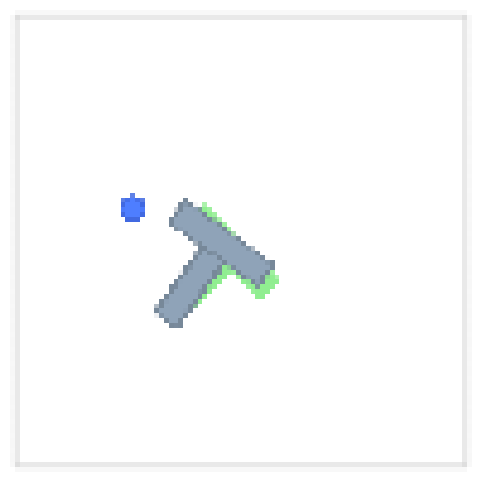

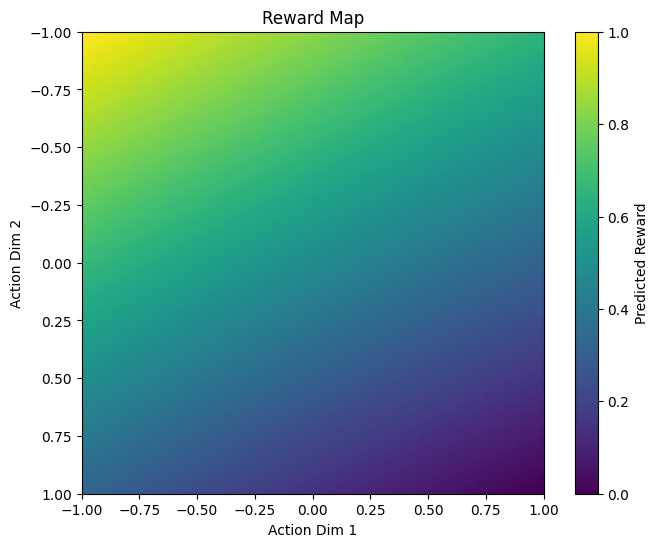

In [9]:
def generate_reward_map(policy, obs, state, resolution=100):
    """Generate a reward landscape by scanning over possible actions.
    Args:
        policy: The trained CVAE policy
        obs: Image observation tensor of shape (1,3,96,96) 
        state: State tensor of shape (1,2)
        resolution: Number of points to sample in each action dimension
        
    Returns:
        actions: (resolution*resolution, 14) tensor of sampled actions
        rewards: (resolution*resolution,) tensor of predicted rewards
    """
    # Encode state and observation
    with torch.no_grad():
        zs = policy.state_encoder(obs, state)
        
        # Create action grid from (-1,-1) to (1,1)
        x = torch.linspace(-1, 1, resolution)
        y = torch.linspace(1, -1, resolution)  # Reversed y range
        xx, yy = torch.meshgrid(x, y, indexing='ij')
        
        # Create full action tensor with zeros
        actions = torch.zeros((resolution*resolution, 14), device=obs.device)
        # Fill first two dimensions with grid values
        for i in range(1):
            actions[:, 2*i] = xx.flatten()
            actions[:, 2*i+1] = yy.flatten()

        
        # Encode each action
        za_list = []
        rewards = []

        # Process in batches to avoid memory issues
        batch_size = 100
        z = torch.randn(1,64).repeat(batch_size,1).cuda()
        for i in range(0, len(actions), batch_size):
            action_batch = actions[i:i+batch_size]
            
            # Encode action
            za = policy.action_encoder(action_batch)
            
            # # Get latent from encoder
            # z_mu, z_logvar = policy.fusing_encoder(
            #     zs.repeat(len(action_batch),1), 
            #     za
            # )

            # z = policy.reparameterize(z_mu,z_logvar)
            
            
            # Decode reward
            reward = policy.reward_decoder(
                zs.repeat(len(action_batch),1),
                za, 
                z
            )
            rewards.append(reward)
            
        rewards = torch.cat(rewards, dim=0)
        
        rewards = rewards.squeeze(-1).cpu().numpy()

        # Normalize rewards to [0,1] range
        rewards = (rewards - rewards.min()) / (rewards.max() - rewards.min())

        action = actions.cpu().numpy()

        # Reshape rewards for plotting
        reward_grid = rewards.reshape(100,100)


        
        # Plot and save observation image
        dir = "./output/img"
        plt.figure(figsize=(8,6))
        obs_img = obs.squeeze().permute(1,2,0).cpu().numpy()
        plt.imshow(obs_img)
        plt.axis('off')
        plt.savefig(f'{dir}/observation.png')
        plt.show()
        
        # Plot and save reward map
        plt.figure(figsize=(8,6))
        plt.imshow(reward_grid, extent=[-1,1,1,-1], origin='lower')
        plt.colorbar(label='Predicted Reward')
        plt.xlabel('Action Dim 1')
        plt.ylabel('Action Dim 2') 
        plt.title('Reward Map')
        plt.savefig(f'{dir}/reward_map.png')
        plt.show()

        return action, rewards

# Example usage:
obs = batch['observation.image'][0].cuda()
state = batch['observation.state'][0].cuda()/512 * 2 - 1
action, rewards = generate_reward_map(policy, obs, state)


In [94]:
# config_dict = {
#         "horizon": 7,
#         "action_dim": 2,
#         "state_dim": 512*3*3 + 2,
#         "batch_size": 16,
#         "latent_dim_state": 50,
#         "latent_dim_action": 2,  # Same as action_dim
#         "posterior_dim": 64,
#         "beta": 1.0,
#         "training_steps": 3000,
#         "learning_rate": 3e-4,
#         "max_iterations": 50,
#         "step_size": 1e-4,
#         "damping": 1e-3,
#         "min_std": 1e-4,
#         "discount": 0.9,
#         "log_freq": 1,
#         "eval_freq": 40,
#         "output_directory": "./output",
#         "device": "cuda:0",
#         "gradient_accumulation_steps": 4,  # Added gradient accumulation config
#         "eval_split": 0.05
#     }

# config = Config(config_dict)
# policy_ = CVAEWithTrajectoryOptimization(config)

In [97]:
# checkpoint = torch.load("./output/best_model_/model.pt")

/tmp/ipykernel_2867674/804462426.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./output/best_model_/model.pt")


In [100]:
# policy_.state_encoder.load_state_dict(checkpoint['state_encoder'])
# policy_.action_encoder.load_state_dict(checkpoint['action_encoder'])
# policy_.fusing_encoder.load_state_dict(checkpoint['fusing_encoder'])
# policy_.dynamics_function.load_state_dict(checkpoint['dynamics_function'])
# policy_.action_decoder.load_state_dict(checkpoint['action_decoder'])
# policy_.reward_decoder.load_state_dict(checkpoint['reward_decoder'])

<All keys matched successfully>

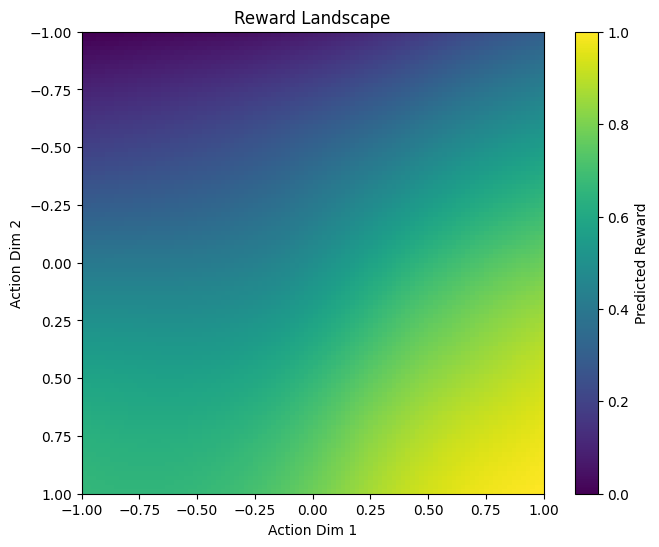

In [101]:
# action, rewards = generate_reward_map(policy_, obs, state)


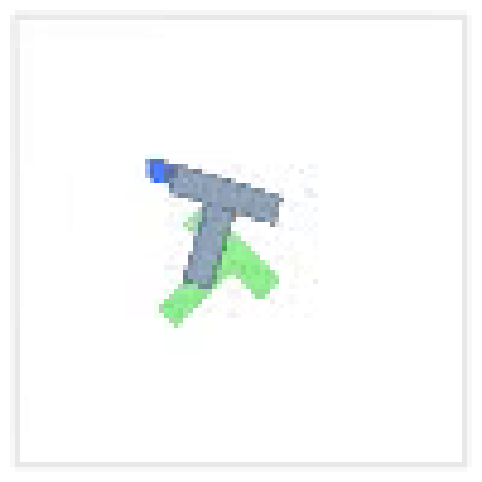

In [78]:
# plt.figure(figsize=(8,6))
# plt.imshow(obs.squeeze().permute(1,2,0).cpu().numpy())
# plt.axis('off')
# plt.show()

In [61]:
# output_dict['best_actions'][0].shape

torch.Size([7, 14])

In [13]:
import imageio
import numpy
import gym_pusht  # noqa: F401
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from collections import deque

env = gym.make(
    "gym_pusht/PushT-v0",
    obs_type="pixels_agent_pos",
    max_episode_steps=300,
    render_mode="rgb_array"
)

cfg = config

# Prepare to collect every rewards and all the frames of the episode,
# from initial state to final state.
rewards = []
frames = []
numpy_observation, info = env.reset(seed=42)

# Initialize action queue
action_queue = deque(maxlen=7)

# Render frame of the initial state
img = env.render()
frames.append(img)

step = 0
done = False
while not done:
    # Generate new actions when queue is empty
    if len(action_queue) == 0:
        # Prepare observation for the policy running in Pytorch
        state = torch.from_numpy(numpy_observation["agent_pos"])
        image = torch.from_numpy(numpy_observation["pixels"])

        # Convert to float32 with image from channel first in [0,255]
        # to channel last in [0,1]
        state = state.to(torch.float32)
        image = image.to(torch.float32) / 255
        image = image.permute(2, 0, 1)

        # Send data tensors from CPU to GPU
        state = state.to(device, non_blocking=True)
        image = image.to(device, non_blocking=True)
        action = torch.randn(1,28).cuda()

        # Add extra (empty) batch dimension, required to forward the policy
        state = state.unsqueeze(0).unsqueeze(0)/512 * 2 - 1
        obs = image.unsqueeze(0).unsqueeze(0)

        # Predict the next actions with respect to the current observation
        with torch.inference_mode():
            output_dict = policy.plan_with_theseus_update(obs, state, action, 7, cfg.discount, cfg, eval_mode=True)
        
        # Get first 3 actions and add to queue
        actions = output_dict['best_actions'][0].reshape(7,-1, 2)[:,0]
        for act in actions:
            numpy_act = (act.numpy() + 1)/2 * 512
            action_queue.append(numpy_act)

    # Get next action from queue
    numpy_action = action_queue.popleft()

    # Step through the environment and receive a new observation
    numpy_observation, reward, terminated, truncated, info = env.step(numpy_action)
    print(f"{step=} {reward=} {terminated=}")

    # Keep track of all the rewards and frames
    rewards.append(reward)
    img = env.render()
    frames.append(img)
    
    # Display the current frame
    plt.figure(figsize=(8,6))
    plt.imshow(img)
    plt.axis('off')
    display(plt.gcf())
    plt.close()
    
    clear_output(wait=True)

    # The rollout is considered done when the success state is reach (i.e. terminated is True),
    # or the maximum number of iterations is reached (i.e. truncated is True)
    done = terminated | truncated | done
    step += 1

if terminated:
    print("Success!")
else:
    print("Failure!")

# Get the speed of environment (i.e. its number of frames per second).
fps = env.metadata["render_fps"]

# Encode all frames into a mp4 video.
video_path = output_directory / "rollout.mp4"
imageio.mimsave(str(video_path), numpy.stack(frames), fps=fps)

print(f"Video of the evaluation is available in '{video_path}'.")

Failure!


NameError: name 'output_directory' is not defined

In [ ]:
# 